In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, Activation, Input, Bidirectional,SimpleRNN, Embedding, Conv1D, LSTM, MaxPooling1D, GlobalMaxPooling1D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split



from nltk.stem import PorterStemmer
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import seaborn as sns

print(tf.__version__)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


2.17.1


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# from google.colab import drive
# drive.mount('/content/drive')
import torch

print(torch.cuda.is_available())

if torch.cuda.is_available():
    print("Cuda is Availabe")
else:
    print("Cuda Can't be found")

False
Cuda Can't be found


In [4]:
#new_df=pd.read_csv('C:/Users/Administrator/OneDrive/Documents/africa/data/socialcons_all_new.csv')
new_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/socialcons_clean2_rebel5_new.csv')
# new_df=pd.read_csv('D:/senego/dataafrica/analysis/socialcons_all_new.csv')
# new_df=pd.read_csv("C:/Users/Administrator/Downloads/bert.csv")

In [5]:
new_df.shape

(66862, 20)

In [6]:
# !pip install accelerate -U

df=new_df.copy()
df=df.astype(str)

In [7]:
df.shape

(66862, 20)

In [8]:
df.rename(columns={'llama2_labelone10':'cluster','llama2_labelone': 'topic','Predicted_Categories3':'theme','llama3_sentiment':'sentiment', 'Entity_Categories2':'category' },inplace=True)
df.columns

Index(['Unnamed: 0', 'sourcetype', 'Views', 'Date', 'textid', 'alltext',
       'topic', 'cleaned_theme', 'cluster', 'theme', 'sentiment', 'Text_lemma',
       'Entities', 'Relations', 'Entity_Categories', 'Head', 'Relation_Type',
       'Tail', 'Spans', 'category'],
      dtype='object')

In [9]:
#df.groupby(['Top_n_words'])['Text_lemma'].count()
d=df['topic'].value_counts()
d.head(20)

topic
visa application process in australia for african nationals                                                                                          27000
nan                                                                                                                                                   4399
science exam questions and reactions                                                                                                                  2512
overcoming anxiety disorder                                                                                                                           1320
hacking for business                                                                                                                                   894
entrepreneurial innovation challenge                                                                                                                   665
"spiritual infertility consultation"                                                                                                                   535
"snl reactions: dangond & silvestre's monologue justice"                                                                                               406
youth unemployment and poverty in south africa                                                                                                         389
"spiritualist travels solve infertility with charm and humanity"                                                                                       387
"youth empowerment and leadership in africa"                                                                                                           383
trademarks                                                                                                                                             381
"streamed parliament reaction in february"                                                                                                             379
corruption and governance in developing countries                                                                                                      375
water & environmental challenge: innovating for climate resilience                                                                                     312
ghanaian election news                                                                                                                                 307
cricket match fails on tiktok                                                                                                                          302
"frontline documentary confusion: pb official hour reactions | secret jeff amazon divided"                                                             293
"cuba faces shortages and struggles to survive with diabetes, documenting reactions and experiences in a month-long line at an affordable price."      271
"america's got talent auditions"                                                                                                                       271
Name: count, dtype: int64

In [10]:
df = df[df['topic'].isin([
    'science exam questions and reactions',
    'hacking for business',
    'entrepreneurial innovation challenge',
    'spiritual infertility consultation',
    'youth unemployment and poverty in south africa',
    'trademarks',
    'corruption and governance in developing countries',
    'water & environmental challenge: innovating for climate resilience',
    'ghanaian election news',
    'cricket match fails on tiktok',
    'streamed parliament reaction in february'
])][['topic', 'Date', 'theme', 'Head', 'Tail', 'sentiment', 'Relations', 'category', 'Views']]
df.shape

(6137, 9)

In [11]:
df2=df.head(3)
df2.columns

Index(['topic', 'Date', 'theme', 'Head', 'Tail', 'sentiment', 'Relations',
       'category', 'Views'],
      dtype='object')

In [12]:
df2.head()

topic        Date       theme  \
95   science exam questions and reactions  2022-08-24  employment   
96   science exam questions and reactions  2022-08-24  employment   
203                  hacking for business         nan      others   

                                                  Head  \
95   abbreviation em th class abbreviation paper pa...   
96                                       abbreviations   
203  access finance smes seye olurotomi ugwumba center   

                                                  Tail sentiment  \
95   abbreviation em th class abbreviation paper pa...   neutral   
96                                        abbreviation   neutral   
203                                      great nigeria   neutral   

                                             Relations  \
95   [{'head': 'abbreviation em th class abbreviati...   
96   [{'head': 'abbreviation em th class abbreviati...   
203  [{'head': 'access finance smes seye olurotomi ...   

                           category Views  
95                               []    55  
96                               []    55  
203  ['locations', 'organisations']   253

In [13]:
import pandas as pd

# Define the possible themes
themes = ['poverty', 'hunger', 'health', 'employment', 'education', 'security', 'others']

# Function to expand the dataframe based on multilabels by duplicating rows
# Function to expand the dataframe based on multilabels by duplicating rows
def expand_multilabel(df, column):
    # Split the multilabel column and create a new row for each label
    df_expanded = df.copy()
    df_expanded[column] = df_expanded[column].str.split('|')  # Split the multilabel column
    df_expanded = df_expanded.explode(column)  # Duplicate rows for each label
    return df_expanded

# Apply the function to expand the Predicted_Categories3 column
df_expanded = expand_multilabel(df, 'theme')

# Display the expanded dataframe
print(df_expanded)

                                      topic                       Date  \
95     science exam questions and reactions                 2022-08-24   
96     science exam questions and reactions                 2022-08-24   
203                    hacking for business                        nan   
204                    hacking for business                        nan   
205                    hacking for business                        nan   
...                                     ...                        ...   
66786                            trademarks  2019-08-09 09:21:04+00:00   
66787                            trademarks  2019-08-09 09:21:04+00:00   
66809  science exam questions and reactions                 2021-08-24   
66810  science exam questions and reactions                 2021-08-24   
66811  science exam questions and reactions                 2021-08-24   

            theme                                               Head  \
95     employment  abbreviation em th c

In [14]:
df_expanded.shape

(8812, 9)

In [15]:
# # pip install folium

df_education = df_expanded[df_expanded['theme'] == 'education']
df_poverty = df_expanded[df_expanded['theme'] == 'poverty']
df_health = df_expanded[df_expanded['theme'] == 'health']
df_employment = df_expanded[df_expanded['theme'] == 'employment']
df_security = df_expanded[df_expanded['theme'] == 'security']
df_hunger = df_expanded[df_expanded['theme'] == 'hunger']
print(df_education.shape)


(1035, 9)


In [16]:
df_expanded['category']

95                                   []
96                                   []
203      ['locations', 'organisations']
204      ['locations', 'organisations']
205                   ['organisations']
                      ...              
66786                                []
66787                     ['locations']
66809                       ['persons']
66810                       ['persons']
66811                       ['persons']
Name: category, Length: 8812, dtype: object

In [17]:
# Filter rows where 'people' is in the list within the 'category' column
df_people = df_expanded[df_expanded['category'].apply(lambda x: 'persons' in x)]
df_org = df_expanded[df_expanded['category'].apply(lambda x: 'organisations' in x)]
df_country = df_expanded[df_expanded['category'].apply(lambda x: 'locations' in x)]


# Check the shape of the resulting dataframe
df_people.shape


(1265, 9)

In [18]:
df_org.shape

(865, 9)

In [19]:
df_country.shape

(732, 9)

In [20]:
# df=df_org.head(1000)
df.columns

Index(['topic', 'Date', 'theme', 'Head', 'Tail', 'sentiment', 'Relations',
       'category', 'Views'],
      dtype='object')

In [21]:
df2

topic        Date       theme  \
95   science exam questions and reactions  2022-08-24  employment   
96   science exam questions and reactions  2022-08-24  employment   
203                  hacking for business         nan      others   

                                                  Head  \
95   abbreviation em th class abbreviation paper pa...   
96                                       abbreviations   
203  access finance smes seye olurotomi ugwumba center   

                                                  Tail sentiment  \
95   abbreviation em th class abbreviation paper pa...   neutral   
96                                        abbreviation   neutral   
203                                      great nigeria   neutral   

                                             Relations  \
95   [{'head': 'abbreviation em th class abbreviati...   
96   [{'head': 'abbreviation em th class abbreviati...   
203  [{'head': 'access finance smes seye olurotomi ...   

                           category Views  
95                               []    55  
96                               []    55  
203  ['locations', 'organisations']   253

## Community Detection

In [22]:
# import ast
# import networkx as nx
# import matplotlib.pyplot as plt
# import pandas as pd  # Assuming you're using pandas

# # Load your dataset into a DataFrame named 'df2' from the uploaded file
# # Assuming df2 is already created and available
# df_subset = df2[['Head', 'Tail', 'Relation_Type', 'theme', 'sentiment', 'category', 'topic']]

# # Create a directed graph
# G = nx.DiGraph()

# # Add nodes and edges to the graph
# for _, row in df_subset.iterrows():
#     head = row['Head']
#     tail = row['Tail']
#     relation_type = row['Relation_Type']
#     theme = row['theme']
#     sentiment = row['sentiment']
#     category = row['category']
#     topic = row['topic']

#     # Add nodes for Head and Tail
#     G.add_node(head, type='Entity', label='Head')
#     G.add_node(tail, type='Entity', label='Tail')

#     # Add edge between Head and Tail with Relation_Type as edge label
#     G.add_edge(head, tail, type=relation_type)

#     # Add other attributes and edges related to the entities (except cluster)
#     G.add_node(theme, type='Theme')
#     G.add_node(sentiment, type='Sentiment')
#     G.add_node(category, type='Category')
#     G.add_node(topic, type='Topic')

#     # Add edges from Head and Tail to other attributes
#     G.add_edge(head, sentiment, type='Sentiment')
#     G.add_edge(head, theme, type='Theme')
#     G.add_edge(head, category, type='Category')
#     G.add_edge(head, topic, type='Topic')

#     G.add_edge(tail, sentiment, type='Sentiment')
#     G.add_edge(tail, theme, type='Theme')
#     G.add_edge(tail, category, type='Category')
#     G.add_edge(tail, topic, type='Topic')

# # Adjust the layout for better node spacing
# pos = nx.spring_layout(G, k=2.0)  # Increase k to spread out the nodes

# # Get edge labels (including relation types between head and tail)
# edge_labels = nx.get_edge_attributes(G, 'type')

# # Get node degrees for node size
# node_weights = {node: weight for node, weight in nx.degree(G)}

# # Draw the graph with nodes and edges
# nx.draw(G, pos, with_labels=False, node_size=[v * 100 for v in node_weights.values()], node_color='skyblue', font_color='black' )

# # Label the nodes (Head, Tail, and others)
# for node, (x, y) in pos.items():
#     if node in df_subset['Head'].values:
#         plt.text(x, y + 0.05, f"{node} (Head)", fontsize=8, ha='center', va='center', fontweight='bold', color='blue')  # Mark Head
#     elif node in df_subset['Tail'].values:
#         plt.text(x, y + 0.05, f"{node} (Tail)", fontsize=8, ha='center', va='center', fontweight='bold', color='red')  # Mark Tail
#     else:
#         plt.text(x, y + 0.02, node, fontsize=9, ha='center', va='center')  # Other nodes

# # Draw edge labels (for Relation_Type, Sentiment, Theme, etc.)
# nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# # Show the plot
# plt.show()


In [23]:
df.shape

(6137, 9)

Epoch 0, Loss: 0.9196107387542725
Epoch 10, Loss: 0.3439362943172455
Epoch 20, Loss: 0.1540113240480423
Epoch 30, Loss: 0.09499673545360565
Epoch 40, Loss: 0.07518306374549866
Epoch 50, Loss: 0.06706077605485916
Epoch 60, Loss: 0.059805650264024734
Epoch 70, Loss: 0.05349915474653244
Epoch 80, Loss: 0.04773225262761116
Epoch 90, Loss: 0.04252573102712631


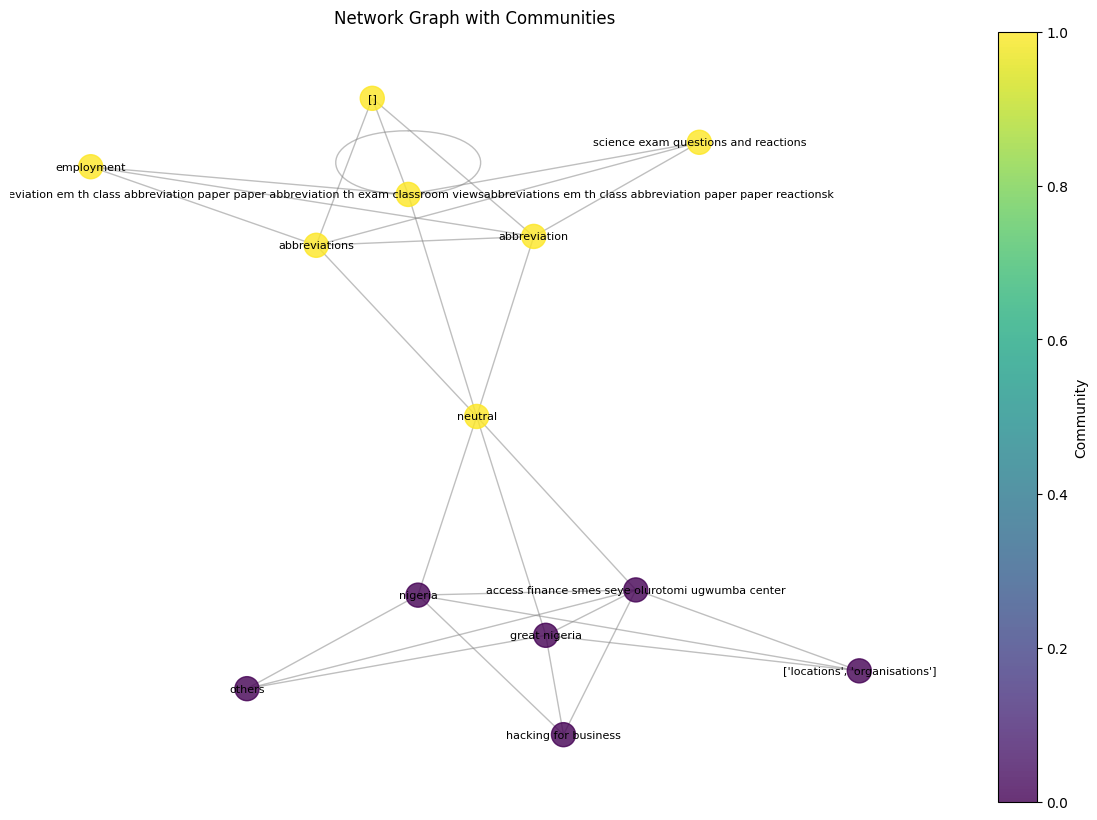

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


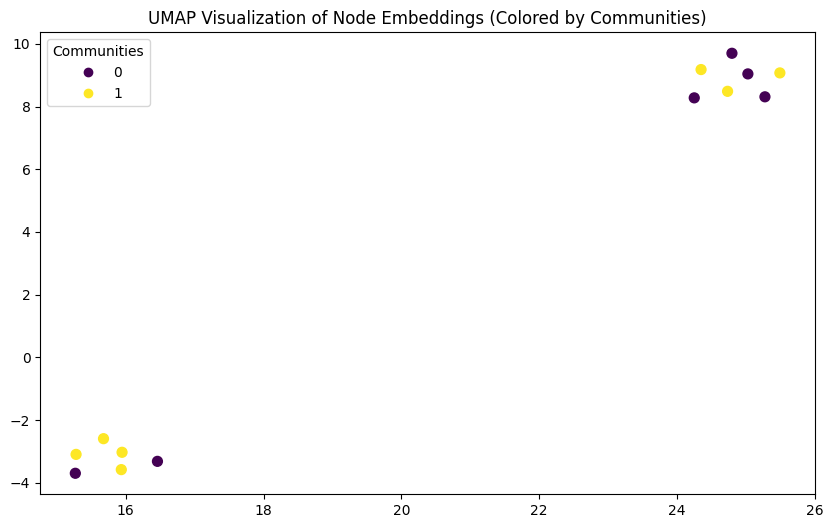

In [38]:
import ast
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import community as community_louvain  # For Louvain method
import umap  # UMAP for dimensionality reduction

# Assuming your data is stored in a DataFrame named 'df_people'
# Extract relevant columns
df_subset = df2[['topic', 'Date', 'theme', 'Head', 'Tail', 'sentiment', 'Relations', 'category', 'Views']]

# Step 1: Create a directed graph from the data
G = nx.DiGraph()

# Add nodes and edges to the graph
for _, row in df_subset.iterrows():
    topic = row['topic']
    sentiment = row['sentiment']
    relations = ast.literal_eval(row['Relations'])
    category = row['category']
    theme = row['theme']
    entities = [row['Head'], row['Tail']]
    time = row['Date']

    # Add nodes with type and time attributes
    G.add_node(topic, type='Topic', time=time)
    G.add_node(sentiment, type='Sentiment', time=time)
    G.add_node(theme, type='Theme', time=time)
    G.add_node(category, type='Category', time=time)

    for entity in entities:
        G.add_node(entity, type='Entity', time=time)

    # Add edges from Relations
    for relation in relations:
        head = relation['head']
        relation_type = relation['type']
        tail = relation['tail']
        G.add_edge(head, tail, type=relation_type, time=time)

        # Add additional edges for relationships
        G.add_edge(head, sentiment, type='Sentiment', time=time)
        G.add_edge(head, theme, type='Theme', time=time)
        G.add_edge(head, category, type='Category', time=time)
        G.add_edge(head, topic, type='Topic', time=time)

        G.add_edge(tail, sentiment, type='Sentiment', time=time)
        G.add_edge(tail, theme, type='Theme', time=time)
        G.add_edge(tail, category, type='Category', time=time)
        G.add_edge(tail, topic, type='Topic', time=time)

# Convert the directed graph to an undirected graph for community detection
G_undirected = G.to_undirected()

# Step 2: Ensure all nodes have a 'type' attribute
for node in G_undirected.nodes():
    if 'type' not in G_undirected.nodes[node]:
        G_undirected.nodes[node]['type'] = 'Unknown'  # Assign a default type if missing

# Step 3: Convert NetworkX graph to PyTorch Geometric format

# Get all unique nodes and label encode them
all_nodes = list(G_undirected.nodes)
node_encoder = LabelEncoder()
node_encoder.fit(all_nodes)
node_ids = node_encoder.transform(all_nodes)

# Create edge index (source and target nodes for each edge)
edge_index = []
for source, target in G_undirected.edges():
    edge_index.append([node_encoder.transform([source])[0], node_encoder.transform([target])[0]])

edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

# Use dummy node features (all ones)
num_nodes = len(G_undirected.nodes())
x = torch.ones((num_nodes, 1), dtype=torch.float)  # Feature matrix with a single feature

# Create the PyTorch Geometric data object
data = Data(x=x, edge_index=edge_index)

# Step 4: Define a simple Graph Convolutional Network (GCN)

class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Initialize the model
model = GCN(num_features=1, hidden_channels=16, num_classes=16)

# Step 5: Train the GCN model
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.mse_loss(out, torch.ones(out.shape))  # Dummy loss
    loss.backward()
    optimizer.step()
    return loss.item()

# Train for a few epochs
for epoch in range(100):
    loss = train()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss}')

# Step 6: Extract node embeddings from the trained model
model.eval()
with torch.no_grad():
    embeddings = model(data)

# Step 7: Detect communities using the Louvain method
node_community = community_louvain.best_partition(G_undirected)

# Assign the community as an attribute to each node
for node, community in node_community.items():
    G_undirected.nodes[node]['community'] = community

# Step 8: Visualize the graph with a clearer layout
plt.figure(figsize=(15, 10))

# Use a layout algorithm for positioning nodes
pos = nx.spring_layout(G_undirected, seed=42)  # Spring layout for visualization

# Step 9: Color nodes by community
node_colors = [node_community.get(node, -1) for node in G_undirected.nodes]

# Draw the nodes with community colors
nodes = nx.draw_networkx_nodes(
    G_undirected, pos,
    node_color=node_colors, cmap='viridis',
    node_size=300, alpha=0.8
)

# Draw the edges
nx.draw_networkx_edges(
    G_undirected, pos,
    edge_color='gray', alpha=0.5
)

# Optionally draw labels (can be omitted for large graphs)
nx.draw_networkx_labels(
    G_undirected, pos,
    font_size=8, font_color='black'
)

# Add a color bar to represent communities
plt.colorbar(nodes, label='Community')  # Directly link the color bar to the drawn nodes

# Title and axis
plt.title("Network Graph with Communities")
plt.axis("off")
plt.show()

# Step 10: Reduce the embeddings to 2D using UMAP
umap_model = umap.UMAP(n_components=2)
embeddings_2d = umap_model.fit_transform(embeddings.detach().numpy())  # Convert tensor to numpy

# Visualize the 2D embeddings colored by community
plt.figure(figsize=(10, 6))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=list(node_community.values()), cmap='viridis', s=50)
plt.legend(*scatter.legend_elements(), title="Communities")
plt.title("UMAP Visualization of Node Embeddings (Colored by Communities)")
plt.show()


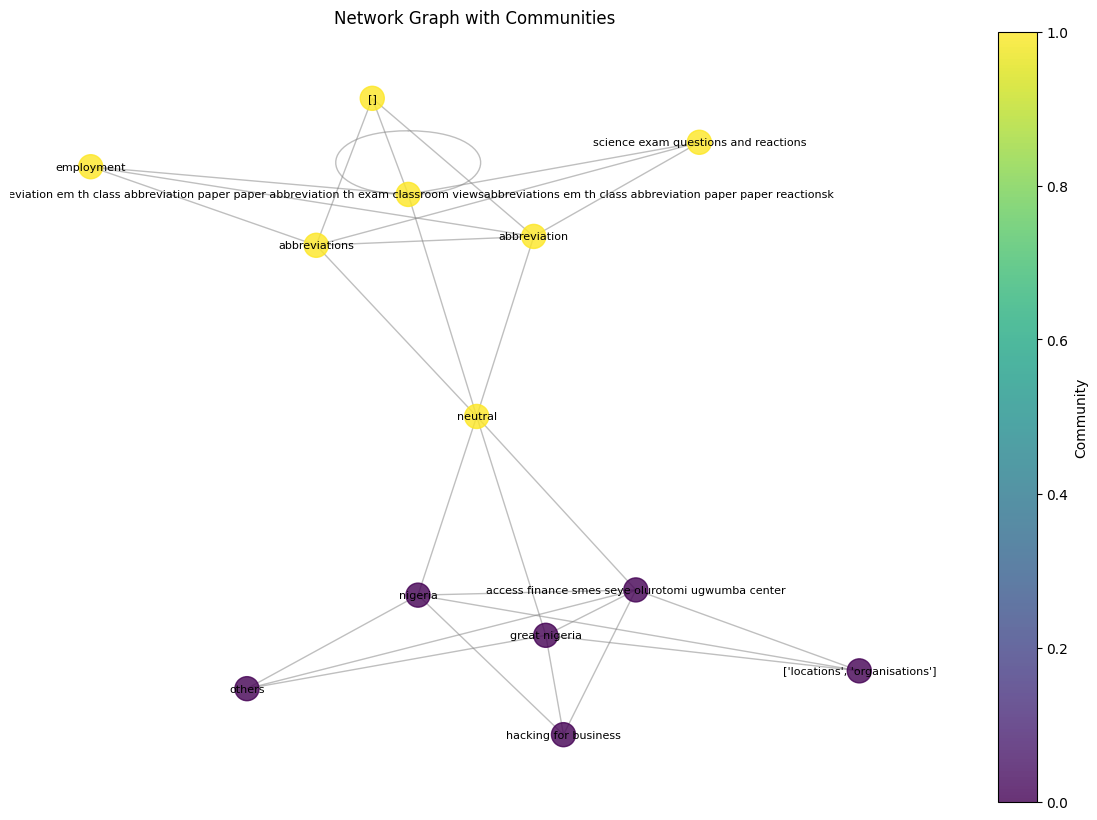

In [36]:
import matplotlib.pyplot as plt
import networkx as nx

# Step 1: Visualize the graph
plt.figure(figsize=(15, 10))

# Use a layout algorithm for positioning nodes
pos = nx.spring_layout(G_undirected, seed=42)  # Spring layout for visualization

# Step 2: Color nodes by community
node_colors = [node_community.get(node, -1) for node in G_undirected.nodes]

# Draw the nodes
nodes = nx.draw_networkx_nodes(
    G_undirected, pos,
    node_color=node_colors, cmap='viridis',
    node_size=300, alpha=0.8
)

# Draw the edges
nx.draw_networkx_edges(
    G_undirected, pos,
    edge_color='gray', alpha=0.5
)

# Optionally draw labels (can be omitted for large graphs)
nx.draw_networkx_labels(
    G_undirected, pos,
    font_size=8, font_color='black'
)

# Add a color bar to represent communities
plt.colorbar(nodes, label='Community')  # Directly link the color bar to the drawn nodes

# Title and axis
plt.title("Network Graph with Communities")
plt.axis("off")
plt.show()


In [27]:
# pip install umap-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.9 MB/s eta 0:00:00


Epoch 0, Loss: 0.9157285690307617
Epoch 10, Loss: 0.16814611852169037
Epoch 20, Loss: 0.02932453155517578
Epoch 30, Loss: 0.01985081098973751
Epoch 40, Loss: 0.01643681898713112
Epoch 50, Loss: 0.011008626781404018
Epoch 60, Loss: 0.01071010623127222
Epoch 70, Loss: 0.010150729678571224
Epoch 80, Loss: 0.00983225367963314
Epoch 90, Loss: 0.009612959809601307


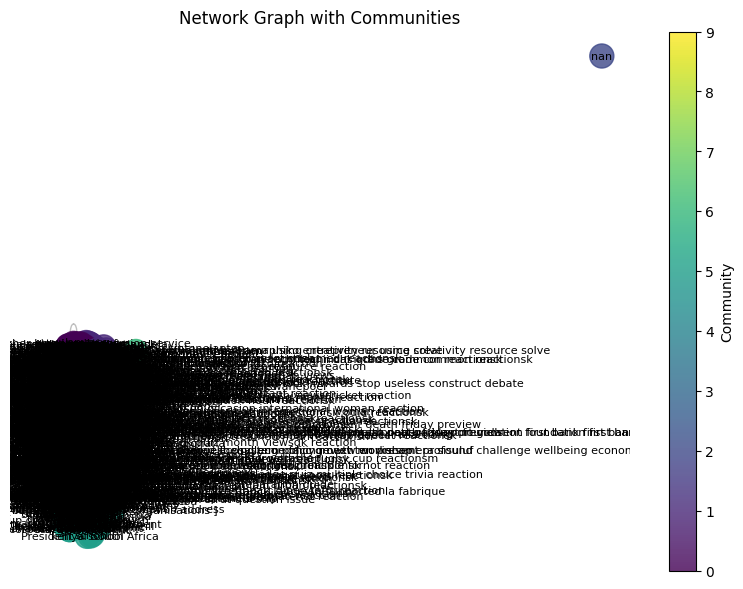

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


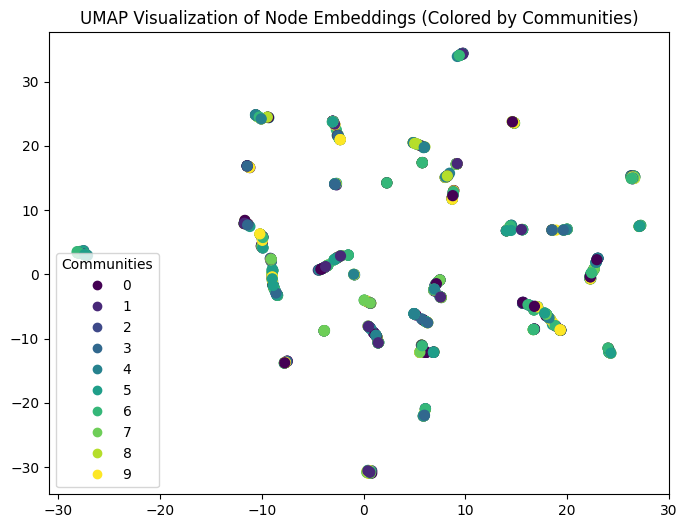

In [45]:
import ast
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import community as community_louvain  # For Louvain method
import umap  # UMAP for dimensionality reduction

# Assuming your data is stored in a DataFrame named 'df_people'
# Extract relevant columns
df_subset = df_people[['topic', 'Date', 'theme', 'Head', 'Tail', 'sentiment', 'Relations', 'category', 'Views']]

# Step 1: Create a directed graph from the data
G = nx.DiGraph()

# Add nodes and edges to the graph
for _, row in df_subset.iterrows():
    topic = row['topic']
    sentiment = row['sentiment']
    relations = ast.literal_eval(row['Relations'])
    category = row['category']
    theme = row['theme']
    entities = [row['Head'], row['Tail']]
    time = row['Date']

    # Add nodes with type and time attributes
    G.add_node(topic, type='Topic', time=time)
    G.add_node(sentiment, type='Sentiment', time=time)
    G.add_node(theme, type='Theme', time=time)
    G.add_node(category, type='Category', time=time)

    for entity in entities:
        G.add_node(entity, type='Entity', time=time)

    # Add edges from Relations
    for relation in relations:
        head = relation['head']
        relation_type = relation['type']
        tail = relation['tail']
        G.add_edge(head, tail, type=relation_type, time=time)

        # Add additional edges for relationships
        G.add_edge(head, sentiment, type='Sentiment', time=time)
        G.add_edge(head, theme, type='Theme', time=time)
        G.add_edge(head, category, type='Category', time=time)
        G.add_edge(head, topic, type='Topic', time=time)

        G.add_edge(tail, sentiment, type='Sentiment', time=time)
        G.add_edge(tail, theme, type='Theme', time=time)
        G.add_edge(tail, category, type='Category', time=time)
        G.add_edge(tail, topic, type='Topic', time=time)

# Convert the directed graph to an undirected graph for community detection
G_undirected = G.to_undirected()

# Step 2: Ensure all nodes have a 'type' attribute
for node in G_undirected.nodes():
    if 'type' not in G_undirected.nodes[node]:
        G_undirected.nodes[node]['type'] = 'Unknown'  # Assign a default type if missing

# Step 3: Convert NetworkX graph to PyTorch Geometric format

# Get all unique nodes and label encode them
all_nodes = list(G_undirected.nodes)
node_encoder = LabelEncoder()
node_encoder.fit(all_nodes)
node_ids = node_encoder.transform(all_nodes)

# Create edge index (source and target nodes for each edge)
edge_index = []
for source, target in G_undirected.edges():
    edge_index.append([node_encoder.transform([source])[0], node_encoder.transform([target])[0]])

edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

# Use dummy node features (all ones)
num_nodes = len(G_undirected.nodes())
x = torch.ones((num_nodes, 1), dtype=torch.float)  # Feature matrix with a single feature

# Create the PyTorch Geometric data object
data = Data(x=x, edge_index=edge_index)

# Step 4: Define a simple Graph Convolutional Network (GCN)

class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Initialize the model
model = GCN(num_features=1, hidden_channels=16, num_classes=16)

# Step 5: Train the GCN model
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.mse_loss(out, torch.ones(out.shape))  # Dummy loss
    loss.backward()
    optimizer.step()
    return loss.item()

# Train for a few epochs
for epoch in range(100):
    loss = train()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss}')

# Step 6: Extract node embeddings from the trained model
model.eval()
with torch.no_grad():
    embeddings = model(data)

# Step 7: Detect communities using the Louvain method
node_community = community_louvain.best_partition(G_undirected)

# Assign the community as an attribute to each node
for node, community in node_community.items():
    G_undirected.nodes[node]['community'] = community

# Step 8: Visualize the graph with a clearer layout
plt.figure(figsize=(10, 7))  # Adjusted figure size

# Use a layout algorithm for positioning nodes
pos = nx.spring_layout(G_undirected, seed=42)  # Spring layout for visualization

# Step 9: Color nodes by community
node_colors = [node_community.get(node, -1) for node in G_undirected.nodes]

# Draw the nodes with community colors
nodes = nx.draw_networkx_nodes(
    G_undirected, pos,
    node_color=node_colors, cmap='viridis',
    node_size=300, alpha=0.8
)

# Draw the edges
nx.draw_networkx_edges(
    G_undirected, pos,
    edge_color='gray', alpha=0.5
)

# Optionally draw labels (can be omitted for large graphs)
nx.draw_networkx_labels(
    G_undirected, pos,
    font_size=8, font_color='black'
)

# Add a color bar to represent communities
plt.colorbar(nodes, label='Community')  # Directly link the color bar to the drawn nodes

# Title and axis
plt.title("Network Graph with Communities")
plt.axis("off")
plt.show()

# Step 10: Reduce the embeddings to 2D using UMAP
umap_model = umap.UMAP(n_components=2)
embeddings_2d = umap_model.fit_transform(embeddings.detach().numpy())  # Convert tensor to numpy

# Visualize the 2D embeddings colored by community
plt.figure(figsize=(8, 6))  # Adjusted figure size
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=list(node_community.values()), cmap='viridis', s=50)
plt.legend(*scatter.legend_elements(), title="Communities")
plt.title("UMAP Visualization of Node Embeddings (Colored by Communities)")
plt.show()

# Step 11: Save the graph with community information
nx.write_gexf(G_undirected, "community_graph_people.gexf")

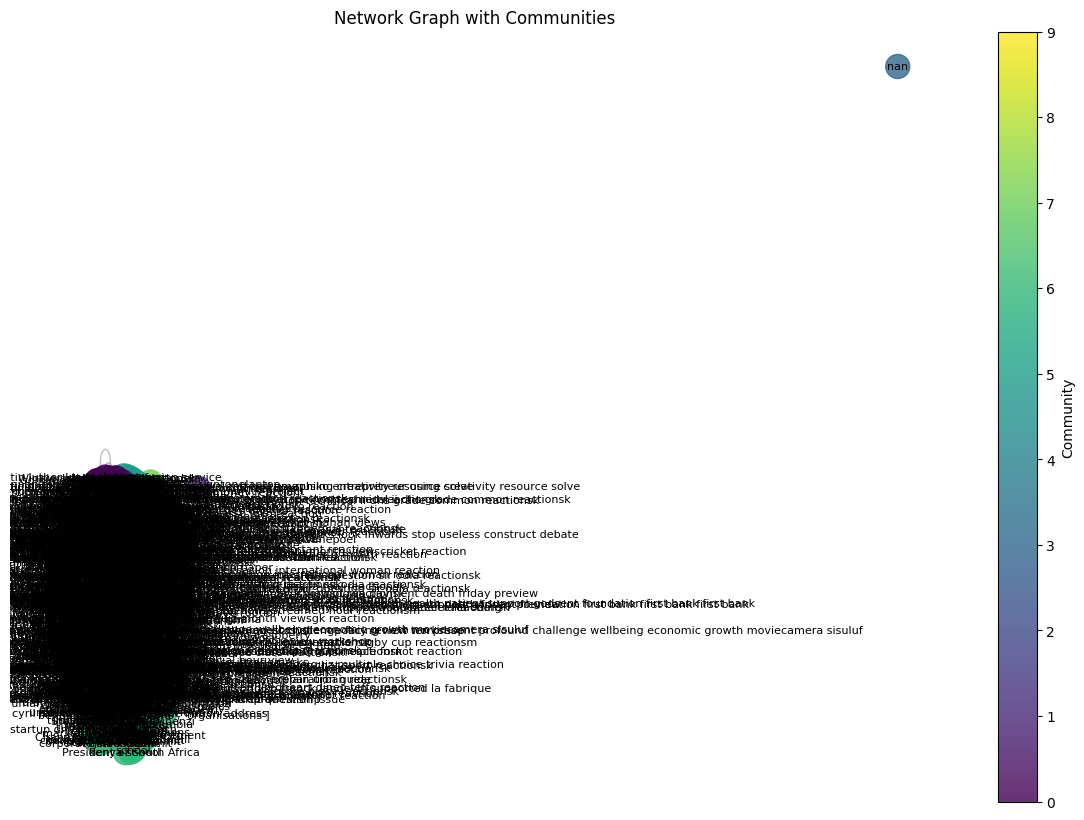

In [34]:
import matplotlib.pyplot as plt
import networkx as nx

# Step 1: Visualize the graph
plt.figure(figsize=(15, 10))

# Use a layout algorithm for positioning nodes
pos = nx.spring_layout(G_undirected, seed=42)  # Spring layout for visualization

# Step 2: Color nodes by community
node_colors = [node_community.get(node, -1) for node in G_undirected.nodes]

# Draw the nodes
nodes = nx.draw_networkx_nodes(
    G_undirected, pos,
    node_color=node_colors, cmap='viridis',
    node_size=300, alpha=0.8
)

# Draw the edges
nx.draw_networkx_edges(
    G_undirected, pos,
    edge_color='gray', alpha=0.5
)

# Optionally draw labels (can be omitted for large graphs)
nx.draw_networkx_labels(
    G_undirected, pos,
    font_size=8, font_color='black'
)

# Add a color bar to represent communities
plt.colorbar(nodes, label='Community')  # Directly link the color bar to the drawn nodes

# Title and axis
plt.title("Network Graph with Communities")
plt.axis("off")
plt.show()


In [25]:
# !pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.5 MB/s eta 0:00:00


In [41]:
import networkx as nx

# Assuming 'G' is your graph
top_nodes_by_degree = sorted(G.degree(), key=lambda x: x[1], reverse=True)[:10]

print("Top ten nodes by degree:")
for node, degree in top_nodes_by_degree:
    print(f"Node: {node}, Degree: {degree}")


Top ten nodes by degree:
Node: neutral, Degree: 1118
Node: ['persons'], Degree: 1095
Node: others, Degree: 652
Node: science exam questions and reactions, Degree: 581
Node: poverty, Degree: 491
Node: health, Degree: 347
Node: employment, Degree: 298
Node: education, Degree: 283
Node: hacking for business, Degree: 258
Node: ['persons', 'organisations'], Degree: 206


In [42]:
from operator import itemgetter

def networkStats(G):
    """
    This function prints the basic properties of the graph and additional network statistics.
    """
    print("Number of nodes:", G.number_of_nodes())
    print("Number of edges:", G.number_of_edges())

    density = nx.density(G)
    print("Network density:", density)

    triadic_closure = nx.transitivity(G)
    print("Triadic closure:", triadic_closure)

    degree_dict = dict(G.degree(G.nodes()))
    nx.set_node_attributes(G, degree_dict, 'degree')

    sorted_degree = sorted(degree_dict.items(), key=itemgetter(1), reverse=True)
    print("\nTop 5 nodes by degree:\n")
    for d in sorted_degree[:5]:
        print(d)

    betweenness_dict = nx.betweenness_centrality(G)  # Compute betweenness centrality
    eigenvector_dict = nx.eigenvector_centrality(G)  # Compute eigenvector centrality

    sorted_betweenness = sorted(betweenness_dict.items(), key=itemgetter(1), reverse=True)

    print("\nTop 5 nodes by betweenness centrality:\n")
    for b in sorted_betweenness[:5]:
        print(b)

# Assuming G is the graph you created in the previous code
networkStats(G)


Number of nodes: 1336
Number of edges: 7424
Network density: 0.0041624615936665995
Triadic closure: 0.1670102547838038

Top 5 nodes by degree:

('neutral', 1118)
("['persons']", 1095)
('others', 652)
('science exam questions and reactions', 581)
('poverty', 491)

Top 5 nodes by betweenness centrality:

('poverty', 0.0017213303460629232)
('education', 0.00046605910527882126)
('reactionsk', 0.00016985889077932942)
('Nigeria', 0.00014402910904098512)
('business', 0.00013897545609217862)


In [43]:
s= df_people['topic'].unique()
s

array(['hacking for business', 'science exam questions and reactions',
       'ghanaian election news', 'trademarks',
       'entrepreneurial innovation challenge',
       'water & environmental challenge: innovating for climate resilience',
       'cricket match fails on tiktok',
       'youth unemployment and poverty in south africa',
       'corruption and governance in developing countries'], dtype=object)

Epoch 0, Loss: 1.0273375511169434
Epoch 10, Loss: 0.19923162460327148
Epoch 20, Loss: 0.13300850987434387
Epoch 30, Loss: 0.0980796068906784
Epoch 40, Loss: 0.08749128133058548
Epoch 50, Loss: 0.07597757875919342
Epoch 60, Loss: 0.06897144019603729
Epoch 70, Loss: 0.06185780465602875
Epoch 80, Loss: 0.0556604266166687
Epoch 90, Loss: 0.049896642565727234


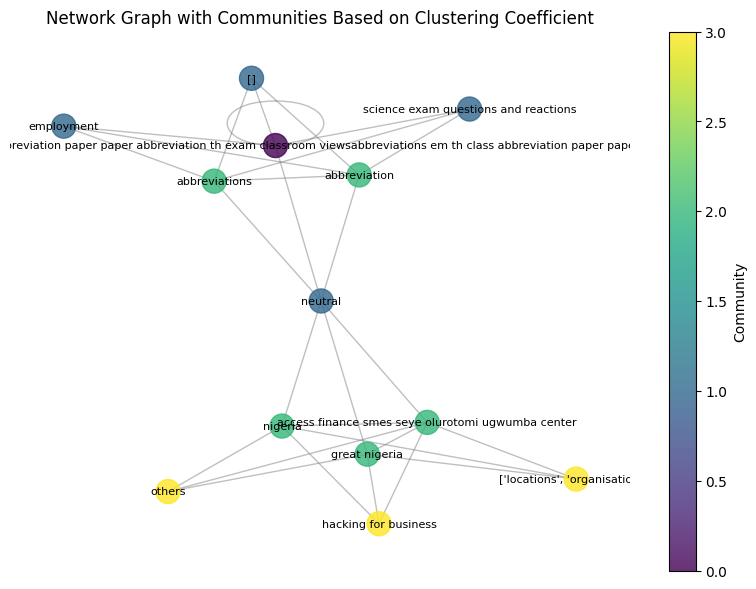

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


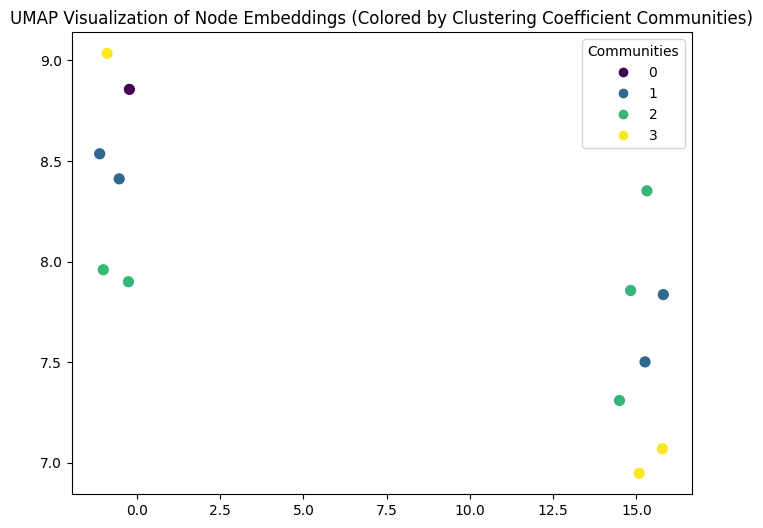

In [46]:
import ast
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import umap  # UMAP for dimensionality reduction

# Assuming your data is stored in a DataFrame named 'df_people'
# Extract relevant columns
df_subset = df2[['topic', 'Date', 'theme', 'Head', 'Tail', 'sentiment', 'Relations', 'category', 'Views']]

# Step 1: Create a directed graph from the data
G = nx.DiGraph()

# Add nodes and edges to the graph
for _, row in df_subset.iterrows():
    topic = row['topic']
    sentiment = row['sentiment']
    relations = ast.literal_eval(row['Relations'])
    category = row['category']
    theme = row['theme']
    entities = [row['Head'], row['Tail']]
    time = row['Date']

    # Add nodes with type and time attributes
    G.add_node(topic, type='Topic', time=time)
    G.add_node(sentiment, type='Sentiment', time=time)
    G.add_node(theme, type='Theme', time=time)
    G.add_node(category, type='Category', time=time)

    for entity in entities:
        G.add_node(entity, type='Entity', time=time)

    # Add edges from Relations
    for relation in relations:
        head = relation['head']
        relation_type = relation['type']
        tail = relation['tail']
        G.add_edge(head, tail, type=relation_type, time=time)

        # Add additional edges for relationships
        G.add_edge(head, sentiment, type='Sentiment', time=time)
        G.add_edge(head, theme, type='Theme', time=time)
        G.add_edge(head, category, type='Category', time=time)
        G.add_edge(head, topic, type='Topic', time=time)

        G.add_edge(tail, sentiment, type='Sentiment', time=time)
        G.add_edge(tail, theme, type='Theme', time=time)
        G.add_edge(tail, category, type='Category', time=time)
        G.add_edge(tail, topic, type='Topic', time=time)

# Convert the directed graph to an undirected graph for community detection
G_undirected = G.to_undirected()

# Step 2: Ensure all nodes have a 'type' attribute
for node in G_undirected.nodes():
    if 'type' not in G_undirected.nodes[node]:
        G_undirected.nodes[node]['type'] = 'Unknown'  # Assign a default type if missing

# Step 3: Convert NetworkX graph to PyTorch Geometric format

# Get all unique nodes and label encode them
all_nodes = list(G_undirected.nodes)
node_encoder = LabelEncoder()
node_encoder.fit(all_nodes)
node_ids = node_encoder.transform(all_nodes)

# Create edge index (source and target nodes for each edge)
edge_index = []
for source, target in G_undirected.edges():
    edge_index.append([node_encoder.transform([source])[0], node_encoder.transform([target])[0]])

edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

# Use dummy node features (all ones)
num_nodes = len(G_undirected.nodes())
x = torch.ones((num_nodes, 1), dtype=torch.float)  # Feature matrix with a single feature

# Create the PyTorch Geometric data object
data = Data(x=x, edge_index=edge_index)

# Step 4: Define a simple Graph Convolutional Network (GCN)

class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Initialize the model
model = GCN(num_features=1, hidden_channels=16, num_classes=16)

# Step 5: Train the GCN model
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.mse_loss(out, torch.ones(out.shape))  # Dummy loss
    loss.backward()
    optimizer.step()
    return loss.item()

# Train for a few epochs
for epoch in range(100):
    loss = train()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss}')

# Step 6: Extract node embeddings from the trained model
model.eval()
with torch.no_grad():
    embeddings = model(data)

# Step 7: Compute the clustering coefficient for each node
clustering_coeff = nx.clustering(G_undirected)

# Assign the clustering coefficient as an attribute to each node
for node, coeff in clustering_coeff.items():
    G_undirected.nodes[node]['clustering_coefficient'] = coeff

# Step 8: Group nodes by their clustering coefficient (thresholding)
# Let's use simple binning to group nodes into communities based on clustering coefficient
thresholds = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]  # You can modify these thresholds
node_community = {}

for node, coeff in clustering_coeff.items():
    # Assign nodes to a community based on their clustering coefficient
    for i in range(len(thresholds) - 1):
        if thresholds[i] <= coeff < thresholds[i + 1]:
            node_community[node] = i
            break

# Step 9: Visualize the graph with a clearer layout
plt.figure(figsize=(10, 7))  # Adjusted figure size

# Use a layout algorithm for positioning nodes
pos = nx.spring_layout(G_undirected, seed=42)  # Spring layout for visualization

# Step 10: Color nodes by their community (based on clustering coefficient)
node_colors = [node_community.get(node, -1) for node in G_undirected.nodes]

# Draw the nodes with community colors
nodes = nx.draw_networkx_nodes(
    G_undirected, pos,
    node_color=node_colors, cmap='viridis',
    node_size=300, alpha=0.8
)

# Draw the edges
nx.draw_networkx_edges(
    G_undirected, pos,
    edge_color='gray', alpha=0.5
)

# Optionally draw labels (can be omitted for large graphs)
nx.draw_networkx_labels(
    G_undirected, pos,
    font_size=8, font_color='black'
)

# Add a color bar to represent communities
plt.colorbar(nodes, label='Community')  # Directly link the color bar to the drawn nodes

# Title and axis
plt.title("Network Graph with Communities Based on Clustering Coefficient")
plt.axis("off")
plt.show()

# Step 11: Save the graph with community information
nx.write_gexf(G_undirected, "community_graph_clustering.gexf")

# Step 12: Reduce the embeddings to 2D using UMAP for better visualization
umap_model = umap.UMAP(n_components=2)
embeddings_2d = umap_model.fit_transform(embeddings.detach().numpy())  # Convert tensor to numpy

# Visualize the 2D embeddings colored by community
plt.figure(figsize=(8, 6))  # Adjusted figure size
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=list(node_community.values()), cmap='viridis', s=50)
plt.legend(*scatter.legend_elements(), title="Communities")
plt.title("UMAP Visualization of Node Embeddings (Colored by Clustering Coefficient Communities)")
plt.show()


Epoch 0, Loss: 1.646207571029663
Epoch 10, Loss: 0.24379193782806396
Epoch 20, Loss: 0.03785928711295128
Epoch 30, Loss: 0.022839529439806938
Epoch 40, Loss: 0.01702810637652874
Epoch 50, Loss: 0.012553472071886063
Epoch 60, Loss: 0.011503592133522034
Epoch 70, Loss: 0.010896161198616028
Epoch 80, Loss: 0.010614253580570221
Epoch 90, Loss: 0.01036564726382494


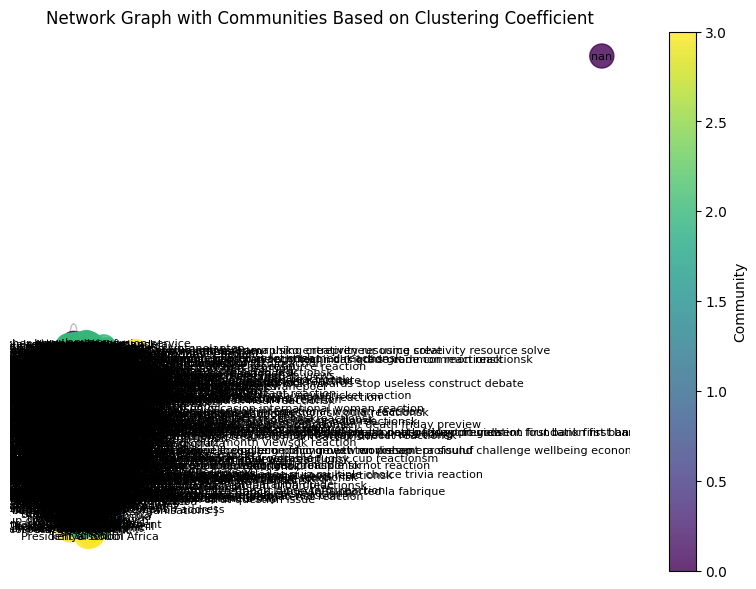

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


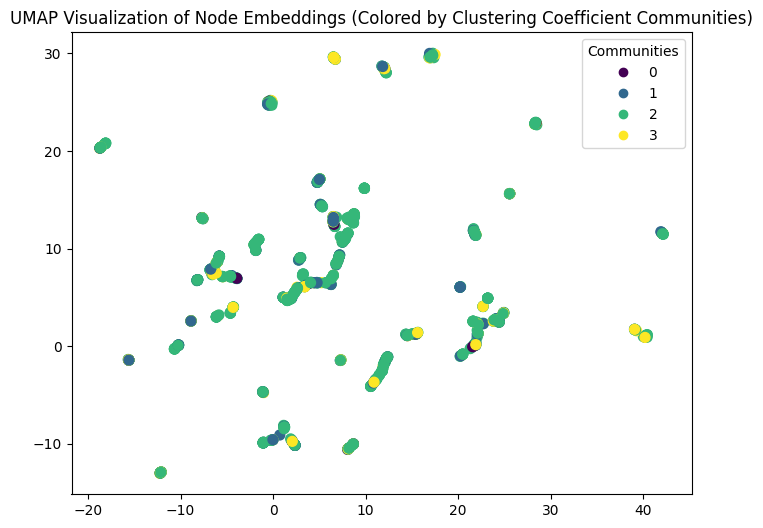

In [47]:
import ast
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import umap  # UMAP for dimensionality reduction

# Assuming your data is stored in a DataFrame named 'df_people'
# Extract relevant columns
df_subset = df_people[['topic', 'Date', 'theme', 'Head', 'Tail', 'sentiment', 'Relations', 'category', 'Views']]

# Step 1: Create a directed graph from the data
G = nx.DiGraph()

# Add nodes and edges to the graph
for _, row in df_subset.iterrows():
    topic = row['topic']
    sentiment = row['sentiment']
    relations = ast.literal_eval(row['Relations'])
    category = row['category']
    theme = row['theme']
    entities = [row['Head'], row['Tail']]
    time = row['Date']

    # Add nodes with type and time attributes
    G.add_node(topic, type='Topic', time=time)
    G.add_node(sentiment, type='Sentiment', time=time)
    G.add_node(theme, type='Theme', time=time)
    G.add_node(category, type='Category', time=time)

    for entity in entities:
        G.add_node(entity, type='Entity', time=time)

    # Add edges from Relations
    for relation in relations:
        head = relation['head']
        relation_type = relation['type']
        tail = relation['tail']
        G.add_edge(head, tail, type=relation_type, time=time)

        # Add additional edges for relationships
        G.add_edge(head, sentiment, type='Sentiment', time=time)
        G.add_edge(head, theme, type='Theme', time=time)
        G.add_edge(head, category, type='Category', time=time)
        G.add_edge(head, topic, type='Topic', time=time)

        G.add_edge(tail, sentiment, type='Sentiment', time=time)
        G.add_edge(tail, theme, type='Theme', time=time)
        G.add_edge(tail, category, type='Category', time=time)
        G.add_edge(tail, topic, type='Topic', time=time)

# Convert the directed graph to an undirected graph for community detection
G_undirected = G.to_undirected()

# Step 2: Ensure all nodes have a 'type' attribute
for node in G_undirected.nodes():
    if 'type' not in G_undirected.nodes[node]:
        G_undirected.nodes[node]['type'] = 'Unknown'  # Assign a default type if missing

# Step 3: Convert NetworkX graph to PyTorch Geometric format

# Get all unique nodes and label encode them
all_nodes = list(G_undirected.nodes)
node_encoder = LabelEncoder()
node_encoder.fit(all_nodes)
node_ids = node_encoder.transform(all_nodes)

# Create edge index (source and target nodes for each edge)
edge_index = []
for source, target in G_undirected.edges():
    edge_index.append([node_encoder.transform([source])[0], node_encoder.transform([target])[0]])

edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

# Use dummy node features (all ones)
num_nodes = len(G_undirected.nodes())
x = torch.ones((num_nodes, 1), dtype=torch.float)  # Feature matrix with a single feature

# Create the PyTorch Geometric data object
data = Data(x=x, edge_index=edge_index)

# Step 4: Define a simple Graph Convolutional Network (GCN)

class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Initialize the model
model = GCN(num_features=1, hidden_channels=16, num_classes=16)

# Step 5: Train the GCN model
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.mse_loss(out, torch.ones(out.shape))  # Dummy loss
    loss.backward()
    optimizer.step()
    return loss.item()

# Train for a few epochs
for epoch in range(100):
    loss = train()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss}')

# Step 6: Extract node embeddings from the trained model
model.eval()
with torch.no_grad():
    embeddings = model(data)

# Step 7: Compute the clustering coefficient for each node
clustering_coeff = nx.clustering(G_undirected)

# Assign the clustering coefficient as an attribute to each node
for node, coeff in clustering_coeff.items():
    G_undirected.nodes[node]['clustering_coefficient'] = coeff

# Step 8: Group nodes by their clustering coefficient (thresholding)
# Let's use simple binning to group nodes into communities based on clustering coefficient
thresholds = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]  # You can modify these thresholds
node_community = {}

for node, coeff in clustering_coeff.items():
    # Assign nodes to a community based on their clustering coefficient
    for i in range(len(thresholds) - 1):
        if thresholds[i] <= coeff < thresholds[i + 1]:
            node_community[node] = i
            break

# Step 9: Visualize the graph with a clearer layout
plt.figure(figsize=(10, 7))  # Adjusted figure size

# Use a layout algorithm for positioning nodes
pos = nx.spring_layout(G_undirected, seed=42)  # Spring layout for visualization

# Step 10: Color nodes by their community (based on clustering coefficient)
node_colors = [node_community.get(node, -1) for node in G_undirected.nodes]

# Draw the nodes with community colors
nodes = nx.draw_networkx_nodes(
    G_undirected, pos,
    node_color=node_colors, cmap='viridis',
    node_size=300, alpha=0.8
)

# Draw the edges
nx.draw_networkx_edges(
    G_undirected, pos,
    edge_color='gray', alpha=0.5
)

# Optionally draw labels (can be omitted for large graphs)
nx.draw_networkx_labels(
    G_undirected, pos,
    font_size=8, font_color='black'
)

# Add a color bar to represent communities
plt.colorbar(nodes, label='Community')  # Directly link the color bar to the drawn nodes

# Title and axis
plt.title("Network Graph with Communities Based on Clustering Coefficient")
plt.axis("off")
plt.show()

# Step 11: Save the graph with community information
nx.write_gexf(G_undirected, "community_graph_clustering.gexf")

# Step 12: Reduce the embeddings to 2D using UMAP for better visualization
umap_model = umap.UMAP(n_components=2)
embeddings_2d = umap_model.fit_transform(embeddings.detach().numpy())  # Convert tensor to numpy

# Visualize the 2D embeddings colored by community
plt.figure(figsize=(8, 6))  # Adjusted figure size
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=list(node_community.values()), cmap='viridis', s=50)
plt.legend(*scatter.legend_elements(), title="Communities")
plt.title("UMAP Visualization of Node Embeddings (Colored by Clustering Coefficient Communities)")
plt.show()


In [48]:
import networkx as nx

# Assuming 'G' is your graph
# Calculate clustering coefficient for each node
clustering_coefficients = nx.clustering(G)

# Sort nodes based on clustering coefficient
top_nodes_by_clustering_coefficient = sorted(clustering_coefficients, key=clustering_coefficients.get, reverse=True)[:10]

print("Top ten nodes by clustering coefficient:")
for node in top_nodes_by_clustering_coefficient:
    print(f"Node: {node}")


Top ten nodes by clustering coefficient:
Node: tedx talk speech
Node: sean stephenson
Node: viewspresident
Node: durban
Node: political participation
Node: golf
Node: past question answer mark
Node: month reactionsk
Node: sigi regency
Node: sigi


Epoch 0, Loss: 1.4556368589401245
Epoch 10, Loss: 0.24071598052978516
Epoch 20, Loss: 0.1452951729297638
Epoch 30, Loss: 0.09740262478590012
Epoch 40, Loss: 0.08955568820238113
Epoch 50, Loss: 0.0777985006570816
Epoch 60, Loss: 0.07112058997154236
Epoch 70, Loss: 0.06547968089580536
Epoch 80, Loss: 0.06000228226184845
Epoch 90, Loss: 0.055001772940158844


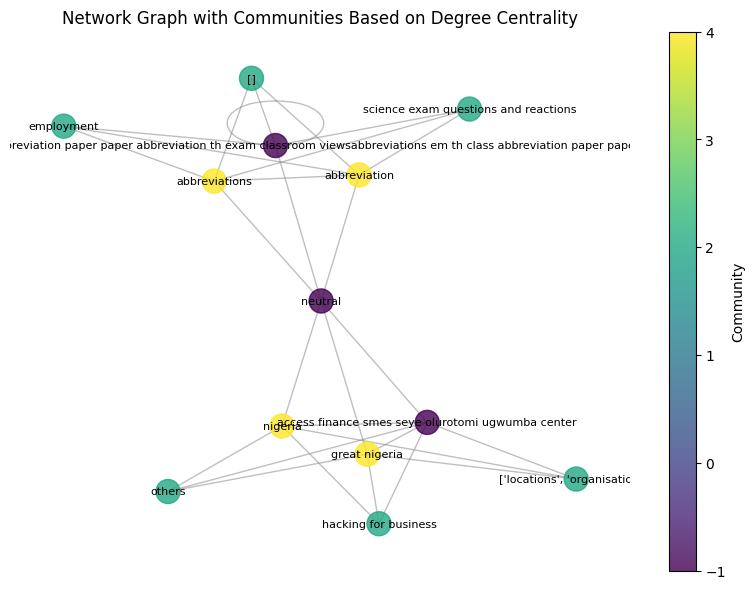

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


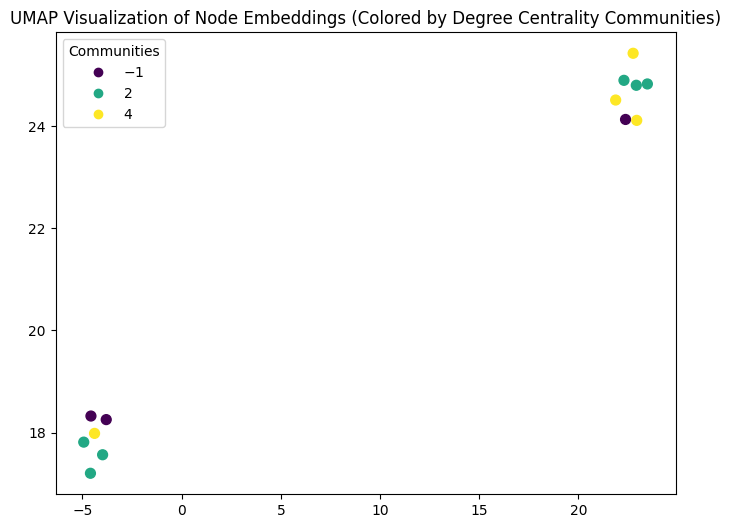

In [51]:
import ast
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import umap  # UMAP for dimensionality reduction

# Assuming your data is stored in a DataFrame named 'df_people'
# Extract relevant columns
df_subset = df2[['topic', 'Date', 'theme', 'Head', 'Tail', 'sentiment', 'Relations', 'category', 'Views']]

# Step 1: Create a directed graph from the data
G = nx.DiGraph()

# Add nodes and edges to the graph
for _, row in df_subset.iterrows():
    topic = row['topic']
    sentiment = row['sentiment']
    relations = ast.literal_eval(row['Relations'])
    category = row['category']
    theme = row['theme']
    entities = [row['Head'], row['Tail']]
    time = row['Date']

    # Add nodes with type and time attributes
    G.add_node(topic, type='Topic', time=time)
    G.add_node(sentiment, type='Sentiment', time=time)
    G.add_node(theme, type='Theme', time=time)
    G.add_node(category, type='Category', time=time)

    for entity in entities:
        G.add_node(entity, type='Entity', time=time)

    # Add edges from Relations
    for relation in relations:
        head = relation['head']
        relation_type = relation['type']
        tail = relation['tail']
        G.add_edge(head, tail, type=relation_type, time=time)

        # Add additional edges for relationships
        G.add_edge(head, sentiment, type='Sentiment', time=time)
        G.add_edge(head, theme, type='Theme', time=time)
        G.add_edge(head, category, type='Category', time=time)
        G.add_edge(head, topic, type='Topic', time=time)

        G.add_edge(tail, sentiment, type='Sentiment', time=time)
        G.add_edge(tail, theme, type='Theme', time=time)
        G.add_edge(tail, category, type='Category', time=time)
        G.add_edge(tail, topic, type='Topic', time=time)

# Convert the directed graph to an undirected graph for community detection
G_undirected = G.to_undirected()

# Step 2: Ensure all nodes have a 'type' attribute
for node in G_undirected.nodes():
    if 'type' not in G_undirected.nodes[node]:
        G_undirected.nodes[node]['type'] = 'Unknown'  # Assign a default type if missing

# Step 3: Convert NetworkX graph to PyTorch Geometric format

# Get all unique nodes and label encode them
all_nodes = list(G_undirected.nodes)
node_encoder = LabelEncoder()
node_encoder.fit(all_nodes)
node_ids = node_encoder.transform(all_nodes)

# Create edge index (source and target nodes for each edge)
edge_index = []
for source, target in G_undirected.edges():
    edge_index.append([node_encoder.transform([source])[0], node_encoder.transform([target])[0]])

edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

# Use dummy node features (all ones)
num_nodes = len(G_undirected.nodes())
x = torch.ones((num_nodes, 1), dtype=torch.float)  # Feature matrix with a single feature

# Create the PyTorch Geometric data object
data = Data(x=x, edge_index=edge_index)

# Step 4: Define a simple Graph Convolutional Network (GCN)

class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Initialize the model
model = GCN(num_features=1, hidden_channels=16, num_classes=16)

# Step 5: Train the GCN model
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.mse_loss(out, torch.ones(out.shape))  # Dummy loss
    loss.backward()
    optimizer.step()
    return loss.item()

# Train for a few epochs
for epoch in range(100):
    loss = train()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss}')

# Step 6: Extract node embeddings from the trained model
model.eval()
with torch.no_grad():
    embeddings = model(data)

# Step 7: Compute the degree centrality for each node
degree_centrality = nx.degree_centrality(G_undirected)

# Assign the degree centrality as an attribute to each node
for node, degree in degree_centrality.items():
    G_undirected.nodes[node]['degree_centrality'] = degree

# Step 8: Group nodes by their degree centrality (thresholding)
# Let's use simple binning to group nodes into communities based on degree centrality
thresholds = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]  # You can modify these thresholds
node_community = {}

for node, degree in degree_centrality.items():
    # Assign nodes to a community based on their degree centrality
    for i in range(len(thresholds) - 1):
        if thresholds[i] <= degree < thresholds[i + 1]:
            node_community[node] = i
            break

# Ensure node_community matches the number of nodes in embeddings
community_values = [node_community.get(node, -1) for node in all_nodes]

# Step 9: Visualize the graph with a clearer layout
plt.figure(figsize=(10, 7))  # Adjusted figure size

# Use a layout algorithm for positioning nodes
pos = nx.spring_layout(G_undirected, seed=42)  # Spring layout for visualization

# Step 10: Color nodes by their community (based on degree centrality)
node_colors = [node_community.get(node, -1) for node in G_undirected.nodes]

# Draw the nodes with community colors
nodes = nx.draw_networkx_nodes(
    G_undirected, pos,
    node_color=node_colors, cmap='viridis',
    node_size=300, alpha=0.8
)

# Draw the edges
nx.draw_networkx_edges(
    G_undirected, pos,
    edge_color='gray', alpha=0.5
)

# Optionally draw labels (can be omitted for large graphs)
nx.draw_networkx_labels(
    G_undirected, pos,
    font_size=8, font_color='black'
)

# Add a color bar to represent communities
plt.colorbar(nodes, label='Community')  # Directly link the color bar to the drawn nodes

# Title and axis
plt.title("Network Graph with Communities Based on Degree Centrality")
plt.axis("off")
plt.show()

# Step 11: Save the graph with community information
nx.write_gexf(G_undirected, "community_graph_degree.gexf")

# Step 12: Reduce the embeddings to 2D using UMAP for better visualization
umap_model = umap.UMAP(n_components=2)
embeddings_2d = umap_model.fit_transform(embeddings.detach().numpy())  # Convert tensor to numpy

# Visualize the 2D embeddings colored by community
plt.figure(figsize=(8, 6))  # Adjusted figure size
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=community_values, cmap='viridis', s=50)
plt.legend(*scatter.legend_elements(), title="Communities")
plt.title("UMAP Visualization of Node Embeddings (Colored by Degree Centrality Communities)")
plt.show()


Epoch 0, Loss: 1.2708418369293213
Epoch 10, Loss: 0.24743515253067017
Epoch 20, Loss: 0.06168169528245926
Epoch 30, Loss: 0.02341475710272789
Epoch 40, Loss: 0.017832960933446884
Epoch 50, Loss: 0.011746909469366074
Epoch 60, Loss: 0.010822744108736515
Epoch 70, Loss: 0.010366164147853851
Epoch 80, Loss: 0.010039642453193665
Epoch 90, Loss: 0.009849646128714085


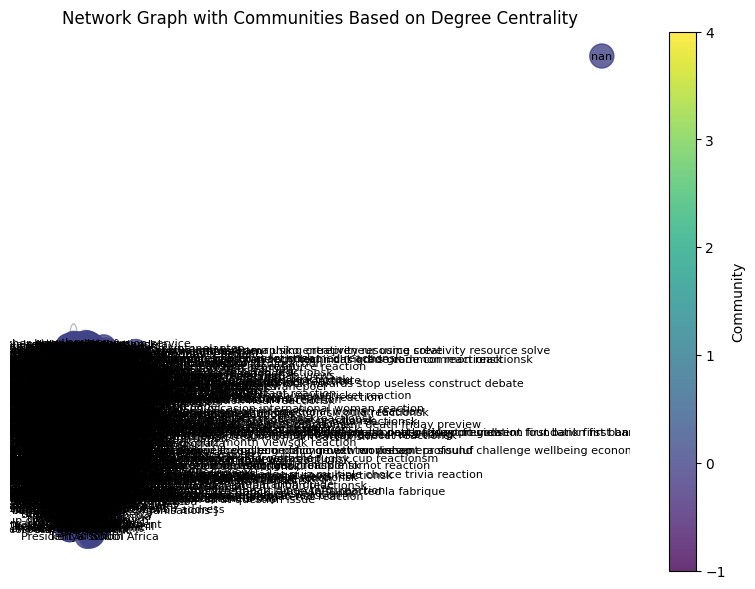

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


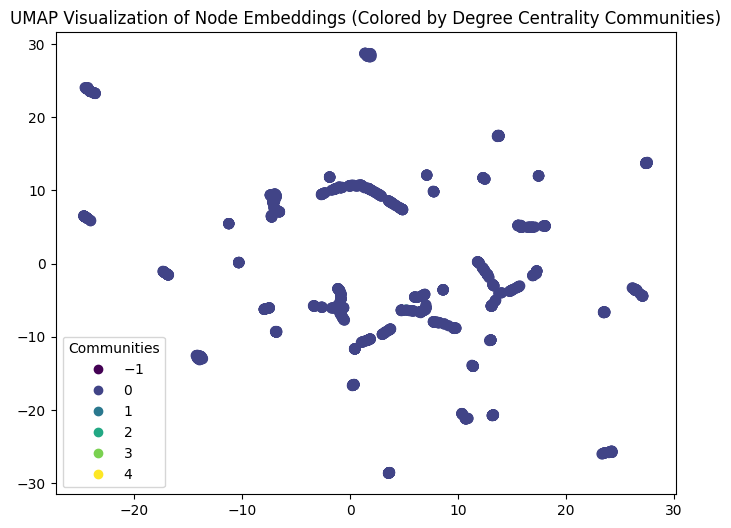

In [52]:
import ast
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import umap  # UMAP for dimensionality reduction

# Assuming your data is stored in a DataFrame named 'df_people'
# Extract relevant columns
df_subset = df_people[['topic', 'Date', 'theme', 'Head', 'Tail', 'sentiment', 'Relations', 'category', 'Views']]

# Step 1: Create a directed graph from the data
G = nx.DiGraph()

# Add nodes and edges to the graph
for _, row in df_subset.iterrows():
    topic = row['topic']
    sentiment = row['sentiment']
    relations = ast.literal_eval(row['Relations'])
    category = row['category']
    theme = row['theme']
    entities = [row['Head'], row['Tail']]
    time = row['Date']

    # Add nodes with type and time attributes
    G.add_node(topic, type='Topic', time=time)
    G.add_node(sentiment, type='Sentiment', time=time)
    G.add_node(theme, type='Theme', time=time)
    G.add_node(category, type='Category', time=time)

    for entity in entities:
        G.add_node(entity, type='Entity', time=time)

    # Add edges from Relations
    for relation in relations:
        head = relation['head']
        relation_type = relation['type']
        tail = relation['tail']
        G.add_edge(head, tail, type=relation_type, time=time)

        # Add additional edges for relationships
        G.add_edge(head, sentiment, type='Sentiment', time=time)
        G.add_edge(head, theme, type='Theme', time=time)
        G.add_edge(head, category, type='Category', time=time)
        G.add_edge(head, topic, type='Topic', time=time)

        G.add_edge(tail, sentiment, type='Sentiment', time=time)
        G.add_edge(tail, theme, type='Theme', time=time)
        G.add_edge(tail, category, type='Category', time=time)
        G.add_edge(tail, topic, type='Topic', time=time)

# Convert the directed graph to an undirected graph for community detection
G_undirected = G.to_undirected()

# Step 2: Ensure all nodes have a 'type' attribute
for node in G_undirected.nodes():
    if 'type' not in G_undirected.nodes[node]:
        G_undirected.nodes[node]['type'] = 'Unknown'  # Assign a default type if missing

# Step 3: Convert NetworkX graph to PyTorch Geometric format

# Get all unique nodes and label encode them
all_nodes = list(G_undirected.nodes)
node_encoder = LabelEncoder()
node_encoder.fit(all_nodes)
node_ids = node_encoder.transform(all_nodes)

# Create edge index (source and target nodes for each edge)
edge_index = []
for source, target in G_undirected.edges():
    edge_index.append([node_encoder.transform([source])[0], node_encoder.transform([target])[0]])

edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

# Use dummy node features (all ones)
num_nodes = len(G_undirected.nodes())
x = torch.ones((num_nodes, 1), dtype=torch.float)  # Feature matrix with a single feature

# Create the PyTorch Geometric data object
data = Data(x=x, edge_index=edge_index)

# Step 4: Define a simple Graph Convolutional Network (GCN)

class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Initialize the model
model = GCN(num_features=1, hidden_channels=16, num_classes=16)

# Step 5: Train the GCN model
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.mse_loss(out, torch.ones(out.shape))  # Dummy loss
    loss.backward()
    optimizer.step()
    return loss.item()

# Train for a few epochs
for epoch in range(100):
    loss = train()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss}')

# Step 6: Extract node embeddings from the trained model
model.eval()
with torch.no_grad():
    embeddings = model(data)

# Step 7: Compute the degree centrality for each node
degree_centrality = nx.degree_centrality(G_undirected)

# Assign the degree centrality as an attribute to each node
for node, degree in degree_centrality.items():
    G_undirected.nodes[node]['degree_centrality'] = degree

# Step 8: Group nodes by their degree centrality (thresholding)
# Let's use simple binning to group nodes into communities based on degree centrality
thresholds = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]  # You can modify these thresholds
node_community = {}

for node, degree in degree_centrality.items():
    # Assign nodes to a community based on their degree centrality
    for i in range(len(thresholds) - 1):
        if thresholds[i] <= degree < thresholds[i + 1]:
            node_community[node] = i
            break

# Ensure node_community matches the number of nodes in embeddings
community_values = [node_community.get(node, -1) for node in all_nodes]

# Step 9: Visualize the graph with a clearer layout
plt.figure(figsize=(10, 7))  # Adjusted figure size

# Use a layout algorithm for positioning nodes
pos = nx.spring_layout(G_undirected, seed=42)  # Spring layout for visualization

# Step 10: Color nodes by their community (based on degree centrality)
node_colors = [node_community.get(node, -1) for node in G_undirected.nodes]

# Draw the nodes with community colors
nodes = nx.draw_networkx_nodes(
    G_undirected, pos,
    node_color=node_colors, cmap='viridis',
    node_size=300, alpha=0.8
)

# Draw the edges
nx.draw_networkx_edges(
    G_undirected, pos,
    edge_color='gray', alpha=0.5
)

# Optionally draw labels (can be omitted for large graphs)
nx.draw_networkx_labels(
    G_undirected, pos,
    font_size=8, font_color='black'
)

# Add a color bar to represent communities
plt.colorbar(nodes, label='Community')  # Directly link the color bar to the drawn nodes

# Title and axis
plt.title("Network Graph with Communities Based on Degree Centrality")
plt.axis("off")
plt.show()

# Step 11: Save the graph with community information
nx.write_gexf(G_undirected, "community_graph_degree.gexf")

# Step 12: Reduce the embeddings to 2D using UMAP for better visualization
umap_model = umap.UMAP(n_components=2)
embeddings_2d = umap_model.fit_transform(embeddings.detach().numpy())  # Convert tensor to numpy

# Visualize the 2D embeddings colored by community
plt.figure(figsize=(8, 6))  # Adjusted figure size
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=community_values, cmap='viridis', s=50)
plt.legend(*scatter.legend_elements(), title="Communities")
plt.title("UMAP Visualization of Node Embeddings (Colored by Degree Centrality Communities)")
plt.show()


In [53]:
import networkx as nx

# Assuming 'G' is your graph
# Calculate degree for each node
node_degrees = dict(G.degree())

# Sort nodes based on degree
top_nodes_by_degree = sorted(node_degrees, key=node_degrees.get, reverse=True)[:10]

print("Top ten nodes by degree:")
for node in top_nodes_by_degree:
    print(f"Node: {node}, Degree: {node_degrees[node]}")


Top ten nodes by degree:
Node: neutral, Degree: 1118
Node: ['persons'], Degree: 1095
Node: others, Degree: 652
Node: science exam questions and reactions, Degree: 581
Node: poverty, Degree: 491
Node: health, Degree: 347
Node: employment, Degree: 298
Node: education, Degree: 283
Node: hacking for business, Degree: 258
Node: ['persons', 'organisations'], Degree: 206


## Influence- centrality

In [ ]:
df2=df_people.head(50)

Epoch 0, Loss: 1.0137600898742676
Epoch 10, Loss: 0.4011434018611908
Epoch 20, Loss: 0.15271513164043427
Epoch 30, Loss: 0.09689510613679886
Epoch 40, Loss: 0.07938845455646515
Epoch 50, Loss: 0.06876491010189056
Epoch 60, Loss: 0.06254740804433823
Epoch 70, Loss: 0.05599474161863327
Epoch 80, Loss: 0.05031121149659157
Epoch 90, Loss: 0.045190032571554184


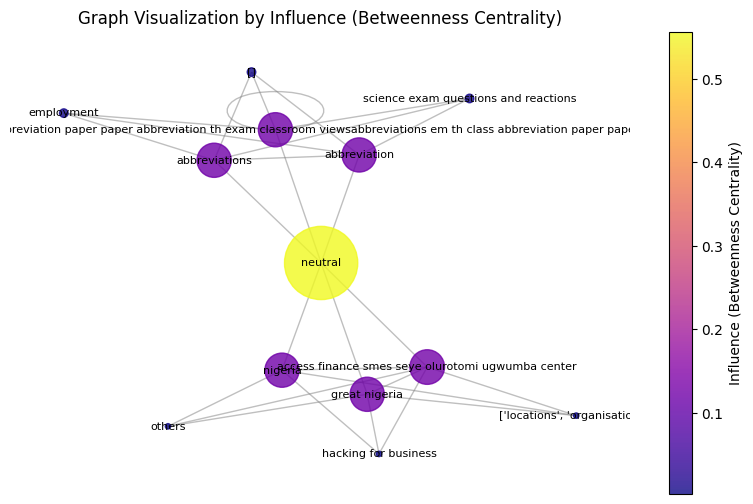

In [57]:
import ast
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Assuming your data is stored in a DataFrame named 'df_people'
# Extract relevant columns
df_subset = df2[['topic', 'Date', 'theme', 'Head', 'Tail', 'sentiment', 'Relations', 'category', 'Views']]

# Step 1: Create a directed graph from the data
G = nx.DiGraph()

# Add nodes and edges to the graph
for _, row in df_subset.iterrows():
    topic = row['topic']
    sentiment = row['sentiment']
    relations = ast.literal_eval(row['Relations'])
    category = row['category']
    theme = row['theme']
    entities = [row['Head'], row['Tail']]
    time = row['Date']

    # Add nodes with type and time attributes
    G.add_node(topic, type='Topic', time=time)
    G.add_node(sentiment, type='Sentiment', time=time)
    G.add_node(theme, type='Theme', time=time)
    G.add_node(category, type='Category', time=time)

    for entity in entities:
        G.add_node(entity, type='Entity', time=time)

    # Add edges from Relations
    for relation in relations:
        head = relation['head']
        relation_type = relation['type']
        tail = relation['tail']
        G.add_edge(head, tail, type=relation_type, time=time)

        # Add additional edges for relationships
        G.add_edge(head, sentiment, type='Sentiment', time=time)
        G.add_edge(head, theme, type='Theme', time=time)
        G.add_edge(head, category, type='Category', time=time)
        G.add_edge(head, topic, type='Topic', time=time)

        G.add_edge(tail, sentiment, type='Sentiment', time=time)
        G.add_edge(tail, theme, type='Theme', time=time)
        G.add_edge(tail, category, type='Category', time=time)
        G.add_edge(tail, topic, type='Topic', time=time)

# Convert the directed graph to an undirected graph for influence analysis
G_undirected = G.to_undirected()

# Step 2: Ensure all nodes have a 'type' attribute
for node in G_undirected.nodes():
    if 'type' not in G_undirected.nodes[node]:
        G_undirected.nodes[node]['type'] = 'Unknown'  # Assign a default type if missing

# Step 3: Convert NetworkX graph to PyTorch Geometric format
# Get all unique nodes and label encode them
all_nodes = list(G_undirected.nodes)
node_encoder = LabelEncoder()
node_encoder.fit(all_nodes)
node_ids = node_encoder.transform(all_nodes)

# Create edge index (source and target nodes for each edge)
edge_index = []
for source, target in G_undirected.edges():
    edge_index.append([node_encoder.transform([source])[0], node_encoder.transform([target])[0]])

edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

# Use dummy node features (all ones)
num_nodes = len(G_undirected.nodes())
x = torch.ones((num_nodes, 1), dtype=torch.float)  # Feature matrix with a single feature

# Create the PyTorch Geometric data object
data = Data(x=x, edge_index=edge_index)

# Step 4: Define a simple Graph Convolutional Network (GCN)
class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Initialize the model
model = GCN(num_features=1, hidden_channels=16, num_classes=16)

# Step 5: Train the GCN model
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.mse_loss(out, torch.ones(out.shape))  # Dummy loss
    loss.backward()
    optimizer.step()
    return loss.item()

# Train for a few epochs
for epoch in range(100):
    loss = train()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss}')

# Step 6: Extract node embeddings from the trained model
model.eval()
with torch.no_grad():
    embeddings = model(data).numpy()

# Step 7: Analyze influence using betweenness centrality
betweenness_centrality = nx.betweenness_centrality(G_undirected)

# Assign the betweenness centrality as an attribute to each node
nx.set_node_attributes(G_undirected, betweenness_centrality, "influence")

# Assign embeddings to the nodes
embedding_as_string = {node: ','.join(map(str, embedding)) for node, embedding in zip(G_undirected.nodes, embeddings)}
nx.set_node_attributes(G_undirected, embedding_as_string, "embedding")

# Step 8: Save the Graph with Embeddings and Influence
nx.write_gexf(G_undirected, "influence_graph_with_embeddings.gexf")

# Step 9: Visualize the Graph by Influence
plt.figure(figsize=(10, 6))

# Use a layout algorithm for positioning nodes
pos = nx.spring_layout(G_undirected, seed=42)

# Scale node sizes by betweenness centrality
node_sizes = [5000 * betweenness_centrality[node] for node in G_undirected.nodes()]

# Draw the graph
nodes = nx.draw_networkx_nodes(
    G_undirected, pos,
    node_size=node_sizes,
    node_color=list(betweenness_centrality.values()),
    cmap='plasma', alpha=0.8
)
nx.draw_networkx_edges(G_undirected, pos, alpha=0.5, edge_color='gray')
nx.draw_networkx_labels(G_undirected, pos, font_size=8, font_color='black')

# Add a color bar for influence
plt.colorbar(nodes, label="Influence (Betweenness Centrality)")
plt.title("Graph Visualization by Influence (Betweenness Centrality)")
plt.axis("off")
plt.show()


Epoch 0, Loss: 0.91411292552948
Epoch 10, Loss: 0.09816520661115646
Epoch 20, Loss: 0.03354505077004433
Epoch 30, Loss: 0.02353224717080593
Epoch 40, Loss: 0.015859486535191536
Epoch 50, Loss: 0.011889108456671238
Epoch 60, Loss: 0.011751796118915081
Epoch 70, Loss: 0.011058488860726357
Epoch 80, Loss: 0.010806858539581299
Epoch 90, Loss: 0.010602040216326714


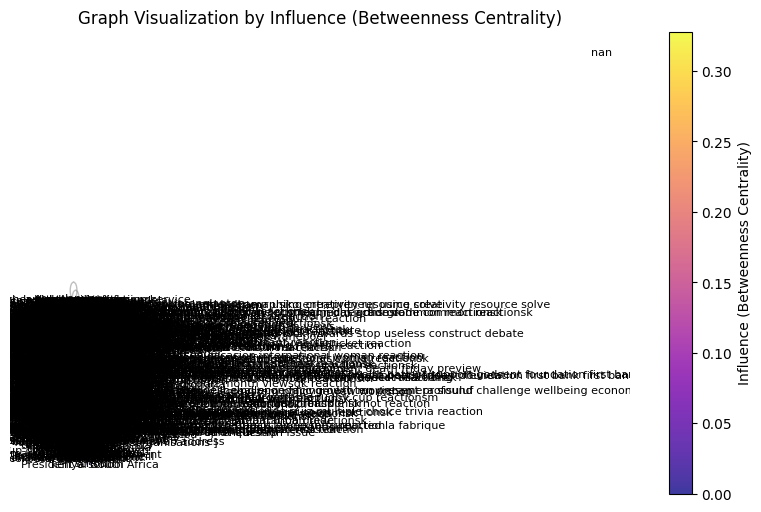

In [58]:
import ast
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Assuming your data is stored in a DataFrame named 'df_people'
# Extract relevant columns
df_subset = df_people[['topic', 'Date', 'theme', 'Head', 'Tail', 'sentiment', 'Relations', 'category', 'Views']]

# Step 1: Create a directed graph from the data
G = nx.DiGraph()

# Add nodes and edges to the graph
for _, row in df_subset.iterrows():
    topic = row['topic']
    sentiment = row['sentiment']
    relations = ast.literal_eval(row['Relations'])
    category = row['category']
    theme = row['theme']
    entities = [row['Head'], row['Tail']]
    time = row['Date']

    # Add nodes with type and time attributes
    G.add_node(topic, type='Topic', time=time)
    G.add_node(sentiment, type='Sentiment', time=time)
    G.add_node(theme, type='Theme', time=time)
    G.add_node(category, type='Category', time=time)

    for entity in entities:
        G.add_node(entity, type='Entity', time=time)

    # Add edges from Relations
    for relation in relations:
        head = relation['head']
        relation_type = relation['type']
        tail = relation['tail']
        G.add_edge(head, tail, type=relation_type, time=time)

        # Add additional edges for relationships
        G.add_edge(head, sentiment, type='Sentiment', time=time)
        G.add_edge(head, theme, type='Theme', time=time)
        G.add_edge(head, category, type='Category', time=time)
        G.add_edge(head, topic, type='Topic', time=time)

        G.add_edge(tail, sentiment, type='Sentiment', time=time)
        G.add_edge(tail, theme, type='Theme', time=time)
        G.add_edge(tail, category, type='Category', time=time)
        G.add_edge(tail, topic, type='Topic', time=time)

# Convert the directed graph to an undirected graph for influence analysis
G_undirected = G.to_undirected()

# Step 2: Ensure all nodes have a 'type' attribute
for node in G_undirected.nodes():
    if 'type' not in G_undirected.nodes[node]:
        G_undirected.nodes[node]['type'] = 'Unknown'  # Assign a default type if missing

# Step 3: Convert NetworkX graph to PyTorch Geometric format
# Get all unique nodes and label encode them
all_nodes = list(G_undirected.nodes)
node_encoder = LabelEncoder()
node_encoder.fit(all_nodes)
node_ids = node_encoder.transform(all_nodes)

# Create edge index (source and target nodes for each edge)
edge_index = []
for source, target in G_undirected.edges():
    edge_index.append([node_encoder.transform([source])[0], node_encoder.transform([target])[0]])

edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

# Use dummy node features (all ones)
num_nodes = len(G_undirected.nodes())
x = torch.ones((num_nodes, 1), dtype=torch.float)  # Feature matrix with a single feature

# Create the PyTorch Geometric data object
data = Data(x=x, edge_index=edge_index)

# Step 4: Define a simple Graph Convolutional Network (GCN)
class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Initialize the model
model = GCN(num_features=1, hidden_channels=16, num_classes=16)

# Step 5: Train the GCN model
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.mse_loss(out, torch.ones(out.shape))  # Dummy loss
    loss.backward()
    optimizer.step()
    return loss.item()

# Train for a few epochs
for epoch in range(100):
    loss = train()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss}')

# Step 6: Extract node embeddings from the trained model
model.eval()
with torch.no_grad():
    embeddings = model(data).numpy()

# Step 7: Analyze influence using betweenness centrality
betweenness_centrality = nx.betweenness_centrality(G_undirected)

# Assign the betweenness centrality as an attribute to each node
nx.set_node_attributes(G_undirected, betweenness_centrality, "influence")

# Assign embeddings to the nodes
embedding_as_string = {node: ','.join(map(str, embedding)) for node, embedding in zip(G_undirected.nodes, embeddings)}
nx.set_node_attributes(G_undirected, embedding_as_string, "embedding")

# Step 8: Save the Graph with Embeddings and Influence
nx.write_gexf(G_undirected, "influence_graph_with_embeddings.gexf")

# Step 9: Visualize the Graph by Influence
plt.figure(figsize=(10, 6))

# Use a layout algorithm for positioning nodes
pos = nx.spring_layout(G_undirected, seed=42)

# Scale node sizes by betweenness centrality
node_sizes = [5000 * betweenness_centrality[node] for node in G_undirected.nodes()]

# Draw the graph
nodes = nx.draw_networkx_nodes(
    G_undirected, pos,
    node_size=node_sizes,
    node_color=list(betweenness_centrality.values()),
    cmap='plasma', alpha=0.8
)
nx.draw_networkx_edges(G_undirected, pos, alpha=0.5, edge_color='gray')
nx.draw_networkx_labels(G_undirected, pos, font_size=8, font_color='black')

# Add a color bar for influence
plt.colorbar(nodes, label="Influence (Betweenness Centrality)")
plt.title("Graph Visualization by Influence (Betweenness Centrality)")
plt.axis("off")
plt.show()


In [59]:
import networkx as nx

# Assuming 'G' is your graph
# Calculate betweenness centrality for each node
betweenness_centralities = nx.betweenness_centrality(G)

# Sort nodes based on betweenness centrality
top_nodes_by_betweenness_centrality = sorted(betweenness_centralities.items(), key=lambda x: x[1], reverse=True)[:10]

print("Top ten nodes by betweenness centrality:")
for node, centrality in top_nodes_by_betweenness_centrality:
    print(f"Node: {node}")


Top ten nodes by betweenness centrality:
Node: poverty
Node: education
Node: reactionsk
Node: Nigeria
Node: business
Node: entrepreneurship
Node: president
Node: Entrepreneur
Node: President
Node: science


In [ ]:
df2=df_expanded.tail(20)

Epoch 0, Loss: 1.0172977447509766
Epoch 10, Loss: 0.4110924005508423
Epoch 20, Loss: 0.15635189414024353
Epoch 30, Loss: 0.09117250144481659
Epoch 40, Loss: 0.08095870912075043
Epoch 50, Loss: 0.0707833468914032
Epoch 60, Loss: 0.06488393247127533
Epoch 70, Loss: 0.05929394066333771
Epoch 80, Loss: 0.05457613989710808
Epoch 90, Loss: 0.050088755786418915


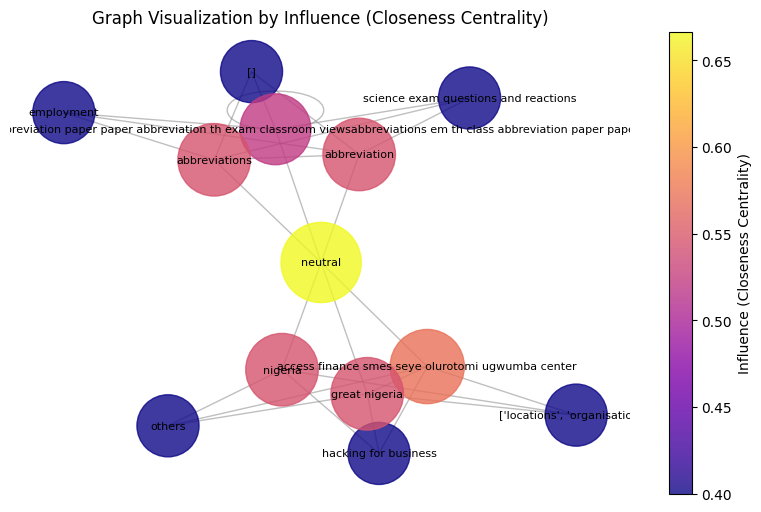

In [60]:
import ast
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Assuming your data is stored in a DataFrame named 'df_people'
# Extract relevant columns
df_subset = df2[['topic', 'Date', 'theme', 'Head', 'Tail', 'sentiment', 'Relations', 'category', 'Views']]

# Step 1: Create a directed graph from the data
G = nx.DiGraph()

# Add nodes and edges to the graph
for _, row in df_subset.iterrows():
    topic = row['topic']
    sentiment = row['sentiment']
    relations = ast.literal_eval(row['Relations'])
    category = row['category']
    theme = row['theme']
    entities = [row['Head'], row['Tail']]
    time = row['Date']

    # Add nodes with type and time attributes
    G.add_node(topic, type='Topic', time=time)
    G.add_node(sentiment, type='Sentiment', time=time)
    G.add_node(theme, type='Theme', time=time)
    G.add_node(category, type='Category', time=time)

    for entity in entities:
        G.add_node(entity, type='Entity', time=time)

    # Add edges from Relations
    for relation in relations:
        head = relation['head']
        relation_type = relation['type']
        tail = relation['tail']
        G.add_edge(head, tail, type=relation_type, time=time)

        # Add additional edges for relationships
        G.add_edge(head, sentiment, type='Sentiment', time=time)
        G.add_edge(head, theme, type='Theme', time=time)
        G.add_edge(head, category, type='Category', time=time)
        G.add_edge(head, topic, type='Topic', time=time)

        G.add_edge(tail, sentiment, type='Sentiment', time=time)
        G.add_edge(tail, theme, type='Theme', time=time)
        G.add_edge(tail, category, type='Category', time=time)
        G.add_edge(tail, topic, type='Topic', time=time)

# Convert the directed graph to an undirected graph for influence analysis
G_undirected = G.to_undirected()

# Step 2: Ensure all nodes have a 'type' attribute
for node in G_undirected.nodes():
    if 'type' not in G_undirected.nodes[node]:
        G_undirected.nodes[node]['type'] = 'Unknown'  # Assign a default type if missing

# Step 3: Convert NetworkX graph to PyTorch Geometric format
# Get all unique nodes and label encode them
all_nodes = list(G_undirected.nodes)
node_encoder = LabelEncoder()
node_encoder.fit(all_nodes)
node_ids = node_encoder.transform(all_nodes)

# Create edge index (source and target nodes for each edge)
edge_index = []
for source, target in G_undirected.edges():
    edge_index.append([node_encoder.transform([source])[0], node_encoder.transform([target])[0]])

edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

# Use dummy node features (all ones)
num_nodes = len(G_undirected.nodes())
x = torch.ones((num_nodes, 1), dtype=torch.float)  # Feature matrix with a single feature

# Create the PyTorch Geometric data object
data = Data(x=x, edge_index=edge_index)

# Step 4: Define a simple Graph Convolutional Network (GCN)
class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Initialize the model
model = GCN(num_features=1, hidden_channels=16, num_classes=16)

# Step 5: Train the GCN model
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.mse_loss(out, torch.ones(out.shape))  # Dummy loss
    loss.backward()
    optimizer.step()
    return loss.item()

# Train for a few epochs
for epoch in range(100):
    loss = train()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss}')

# Step 6: Extract node embeddings from the trained model
model.eval()
with torch.no_grad():
    embeddings = model(data).numpy()

# Step 7: Analyze influence using closeness centrality
closeness_centrality = nx.closeness_centrality(G_undirected)

# Assign the closeness centrality as an attribute to each node
nx.set_node_attributes(G_undirected, closeness_centrality, "influence")

# Assign embeddings to the nodes
embedding_as_string = {node: ','.join(map(str, embedding)) for node, embedding in zip(G_undirected.nodes, embeddings)}
nx.set_node_attributes(G_undirected, embedding_as_string, "embedding")

# Step 8: Save the Graph with Embeddings and Influence
nx.write_gexf(G_undirected, "influence_graph_with_embeddings_closeness.gexf")

# Step 9: Visualize the Graph by Influence
plt.figure(figsize=(10, 6))

# Use a layout algorithm for positioning nodes
pos = nx.spring_layout(G_undirected, seed=42)

# Scale node sizes by closeness centrality
node_sizes = [5000 * closeness_centrality[node] for node in G_undirected.nodes()]

# Draw the graph
nodes = nx.draw_networkx_nodes(
    G_undirected, pos,
    node_size=node_sizes,
    node_color=list(closeness_centrality.values()),
    cmap='plasma', alpha=0.8
)
nx.draw_networkx_edges(G_undirected, pos, alpha=0.5, edge_color='gray')
nx.draw_networkx_labels(G_undirected, pos, font_size=8, font_color='black')

# Add a color bar for influence
plt.colorbar(nodes, label="Influence (Closeness Centrality)")
plt.title("Graph Visualization by Influence (Closeness Centrality)")
plt.axis("off")
plt.show()


Epoch 0, Loss: 0.9426794052124023
Epoch 10, Loss: 0.10981212556362152
Epoch 20, Loss: 0.05610610544681549
Epoch 30, Loss: 0.02588466741144657
Epoch 40, Loss: 0.01385631412267685
Epoch 50, Loss: 0.012591193430125713
Epoch 60, Loss: 0.010978054255247116
Epoch 70, Loss: 0.01026959903538227
Epoch 80, Loss: 0.010022061876952648
Epoch 90, Loss: 0.009877854958176613


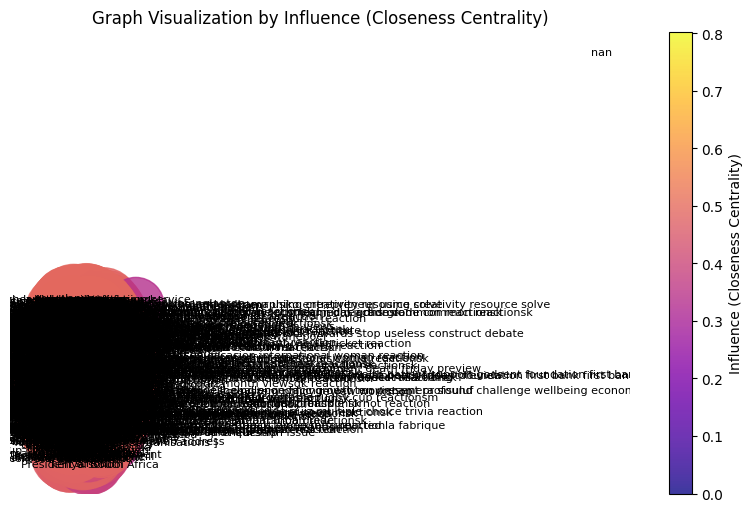

In [61]:
import ast
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Assuming your data is stored in a DataFrame named 'df_people'
# Extract relevant columns
df_subset = df_people[['topic', 'Date', 'theme', 'Head', 'Tail', 'sentiment', 'Relations', 'category', 'Views']]

# Step 1: Create a directed graph from the data
G = nx.DiGraph()

# Add nodes and edges to the graph
for _, row in df_subset.iterrows():
    topic = row['topic']
    sentiment = row['sentiment']
    relations = ast.literal_eval(row['Relations'])
    category = row['category']
    theme = row['theme']
    entities = [row['Head'], row['Tail']]
    time = row['Date']

    # Add nodes with type and time attributes
    G.add_node(topic, type='Topic', time=time)
    G.add_node(sentiment, type='Sentiment', time=time)
    G.add_node(theme, type='Theme', time=time)
    G.add_node(category, type='Category', time=time)

    for entity in entities:
        G.add_node(entity, type='Entity', time=time)

    # Add edges from Relations
    for relation in relations:
        head = relation['head']
        relation_type = relation['type']
        tail = relation['tail']
        G.add_edge(head, tail, type=relation_type, time=time)

        # Add additional edges for relationships
        G.add_edge(head, sentiment, type='Sentiment', time=time)
        G.add_edge(head, theme, type='Theme', time=time)
        G.add_edge(head, category, type='Category', time=time)
        G.add_edge(head, topic, type='Topic', time=time)

        G.add_edge(tail, sentiment, type='Sentiment', time=time)
        G.add_edge(tail, theme, type='Theme', time=time)
        G.add_edge(tail, category, type='Category', time=time)
        G.add_edge(tail, topic, type='Topic', time=time)

# Convert the directed graph to an undirected graph for influence analysis
G_undirected = G.to_undirected()

# Step 2: Ensure all nodes have a 'type' attribute
for node in G_undirected.nodes():
    if 'type' not in G_undirected.nodes[node]:
        G_undirected.nodes[node]['type'] = 'Unknown'  # Assign a default type if missing

# Step 3: Convert NetworkX graph to PyTorch Geometric format
# Get all unique nodes and label encode them
all_nodes = list(G_undirected.nodes)
node_encoder = LabelEncoder()
node_encoder.fit(all_nodes)
node_ids = node_encoder.transform(all_nodes)

# Create edge index (source and target nodes for each edge)
edge_index = []
for source, target in G_undirected.edges():
    edge_index.append([node_encoder.transform([source])[0], node_encoder.transform([target])[0]])

edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

# Use dummy node features (all ones)
num_nodes = len(G_undirected.nodes())
x = torch.ones((num_nodes, 1), dtype=torch.float)  # Feature matrix with a single feature

# Create the PyTorch Geometric data object
data = Data(x=x, edge_index=edge_index)

# Step 4: Define a simple Graph Convolutional Network (GCN)
class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Initialize the model
model = GCN(num_features=1, hidden_channels=16, num_classes=16)

# Step 5: Train the GCN model
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.mse_loss(out, torch.ones(out.shape))  # Dummy loss
    loss.backward()
    optimizer.step()
    return loss.item()

# Train for a few epochs
for epoch in range(100):
    loss = train()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss}')

# Step 6: Extract node embeddings from the trained model
model.eval()
with torch.no_grad():
    embeddings = model(data).numpy()

# Step 7: Analyze influence using closeness centrality
closeness_centrality = nx.closeness_centrality(G_undirected)

# Assign the closeness centrality as an attribute to each node
nx.set_node_attributes(G_undirected, closeness_centrality, "influence")

# Assign embeddings to the nodes
embedding_as_string = {node: ','.join(map(str, embedding)) for node, embedding in zip(G_undirected.nodes, embeddings)}
nx.set_node_attributes(G_undirected, embedding_as_string, "embedding")

# Step 8: Save the Graph with Embeddings and Influence
nx.write_gexf(G_undirected, "influence_graph_with_embeddings_closeness.gexf")

# Step 9: Visualize the Graph by Influence
plt.figure(figsize=(10, 6))

# Use a layout algorithm for positioning nodes
pos = nx.spring_layout(G_undirected, seed=42)

# Scale node sizes by closeness centrality
node_sizes = [5000 * closeness_centrality[node] for node in G_undirected.nodes()]

# Draw the graph
nodes = nx.draw_networkx_nodes(
    G_undirected, pos,
    node_size=node_sizes,
    node_color=list(closeness_centrality.values()),
    cmap='plasma', alpha=0.8
)
nx.draw_networkx_edges(G_undirected, pos, alpha=0.5, edge_color='gray')
nx.draw_networkx_labels(G_undirected, pos, font_size=8, font_color='black')

# Add a color bar for influence
plt.colorbar(nodes, label="Influence (Closeness Centrality)")
plt.title("Graph Visualization by Influence (Closeness Centrality)")
plt.axis("off")
plt.show()


In [62]:
import networkx as nx

# Assuming 'G' is your graph
# Calculate closeness centrality for each node
closeness_centralities = nx.closeness_centrality(G)

# Sort nodes based on closeness centrality
top_nodes_by_closeness_centrality = sorted(closeness_centralities.items(), key=lambda x: x[1], reverse=True)[:10]

print("Top ten nodes by closeness centrality:")
for node, centrality in top_nodes_by_closeness_centrality:
    print(f"Node: {node}")


Top ten nodes by closeness centrality:
Node: neutral
Node: ['persons']
Node: others
Node: science exam questions and reactions
Node: poverty
Node: employment
Node: hacking for business
Node: ['persons', 'organisations']
Node: health
Node: youth unemployment and poverty in south africa


Epoch 0, Loss: 0.9262371063232422
Epoch 10, Loss: 0.41527190804481506
Epoch 20, Loss: 0.19231504201889038
Epoch 30, Loss: 0.1120627373456955
Epoch 40, Loss: 0.07962273061275482
Epoch 50, Loss: 0.0666491836309433
Epoch 60, Loss: 0.060412824153900146
Epoch 70, Loss: 0.05455130711197853
Epoch 80, Loss: 0.04916677996516228
Epoch 90, Loss: 0.04424463212490082


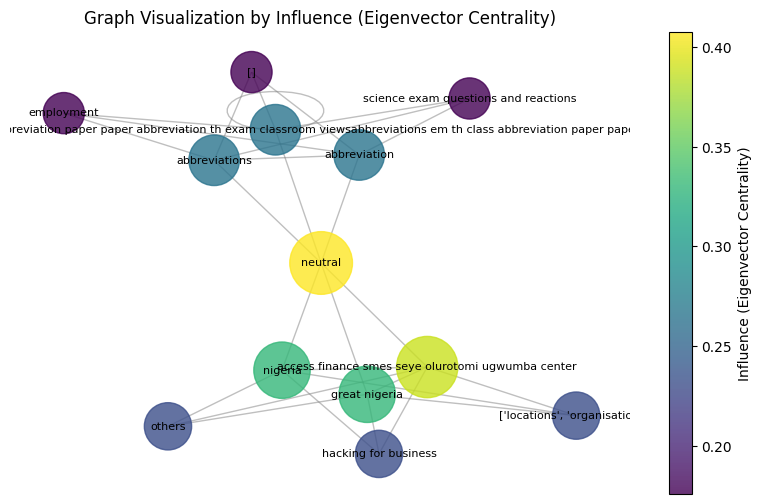

In [63]:
import ast
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Assuming your data is stored in a DataFrame named 'df_people'
# Extract relevant columns
df_subset = df2[['topic', 'Date', 'theme', 'Head', 'Tail', 'sentiment', 'Relations', 'category', 'Views']]

# Step 1: Create a directed graph from the data
G = nx.DiGraph()

# Add nodes and edges to the graph
for _, row in df_subset.iterrows():
    topic = row['topic']
    sentiment = row['sentiment']
    relations = ast.literal_eval(row['Relations'])
    category = row['category']
    theme = row['theme']
    entities = [row['Head'], row['Tail']]
    time = row['Date']

    # Add nodes with type and time attributes
    G.add_node(topic, type='Topic', time=time)
    G.add_node(sentiment, type='Sentiment', time=time)
    G.add_node(theme, type='Theme', time=time)
    G.add_node(category, type='Category', time=time)

    for entity in entities:
        G.add_node(entity, type='Entity', time=time)

    # Add edges from Relations
    for relation in relations:
        head = relation['head']
        relation_type = relation['type']
        tail = relation['tail']
        G.add_edge(head, tail, type=relation_type, time=time)

        # Add additional edges for relationships
        G.add_edge(head, sentiment, type='Sentiment', time=time)
        G.add_edge(head, theme, type='Theme', time=time)
        G.add_edge(head, category, type='Category', time=time)
        G.add_edge(head, topic, type='Topic', time=time)

        G.add_edge(tail, sentiment, type='Sentiment', time=time)
        G.add_edge(tail, theme, type='Theme', time=time)
        G.add_edge(tail, category, type='Category', time=time)
        G.add_edge(tail, topic, type='Topic', time=time)

# Convert the directed graph to an undirected graph for influence analysis
G_undirected = G.to_undirected()

# Step 2: Ensure all nodes have a 'type' attribute
for node in G_undirected.nodes():
    if 'type' not in G_undirected.nodes[node]:
        G_undirected.nodes[node]['type'] = 'Unknown'  # Assign a default type if missing

# Step 3: Convert NetworkX graph to PyTorch Geometric format
# Get all unique nodes and label encode them
all_nodes = list(G_undirected.nodes)
node_encoder = LabelEncoder()
node_encoder.fit(all_nodes)
node_ids = node_encoder.transform(all_nodes)

# Create edge index (source and target nodes for each edge)
edge_index = []
for source, target in G_undirected.edges():
    edge_index.append([node_encoder.transform([source])[0], node_encoder.transform([target])[0]])

edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

# Use dummy node features (all ones)
num_nodes = len(G_undirected.nodes())
x = torch.ones((num_nodes, 1), dtype=torch.float)  # Feature matrix with a single feature

# Create the PyTorch Geometric data object
data = Data(x=x, edge_index=edge_index)

# Step 4: Define a simple Graph Convolutional Network (GCN)
class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Initialize the model
model = GCN(num_features=1, hidden_channels=16, num_classes=16)

# Step 5: Train the GCN model
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.mse_loss(out, torch.ones(out.shape))  # Dummy loss
    loss.backward()
    optimizer.step()
    return loss.item()

# Train for a few epochs
for epoch in range(100):
    loss = train()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss}')

# Step 6: Extract node embeddings from the trained model
model.eval()
with torch.no_grad():
    embeddings = model(data).numpy()

# Step 7: Analyze influence using eigenvector centrality
eigenvector_centrality = nx.eigenvector_centrality(G_undirected, max_iter=1000)

# Assign the eigenvector centrality as an attribute to each node
nx.set_node_attributes(G_undirected, eigenvector_centrality, "influence")

# Assign embeddings to the nodes
embedding_as_string = {node: ','.join(map(str, embedding)) for node, embedding in zip(G_undirected.nodes, embeddings)}
nx.set_node_attributes(G_undirected, embedding_as_string, "embedding")

# Step 8: Save the Graph with Embeddings and Influence
nx.write_gexf(G_undirected, "influence_graph_with_embeddings_eigenvector.gexf")

# Step 9: Visualize the Graph by Influence
plt.figure(figsize=(10, 6))

# Use a layout algorithm for positioning nodes
pos = nx.spring_layout(G_undirected, seed=42)

# Scale node sizes by eigenvector centrality
node_sizes = [5000 * eigenvector_centrality[node] for node in G_undirected.nodes()]

# Draw the graph
nodes = nx.draw_networkx_nodes(
    G_undirected, pos,
    node_size=node_sizes,
    node_color=list(eigenvector_centrality.values()),
    cmap='viridis', alpha=0.8
)
nx.draw_networkx_edges(G_undirected, pos, alpha=0.5, edge_color='gray')
nx.draw_networkx_labels(G_undirected, pos, font_size=8, font_color='black')

# Add a color bar for influence
plt.colorbar(nodes, label="Influence (Eigenvector Centrality)")
plt.title("Graph Visualization by Influence (Eigenvector Centrality)")
plt.axis("off")
plt.show()


Epoch 0, Loss: 0.9963135123252869
Epoch 10, Loss: 0.38953879475593567
Epoch 20, Loss: 0.13614723086357117
Epoch 30, Loss: 0.03673853352665901
Epoch 40, Loss: 0.015809012576937675
Epoch 50, Loss: 0.01251062098890543
Epoch 60, Loss: 0.010295994579792023
Epoch 70, Loss: 0.009613140486180782
Epoch 80, Loss: 0.009302235208451748
Epoch 90, Loss: 0.008995773270726204


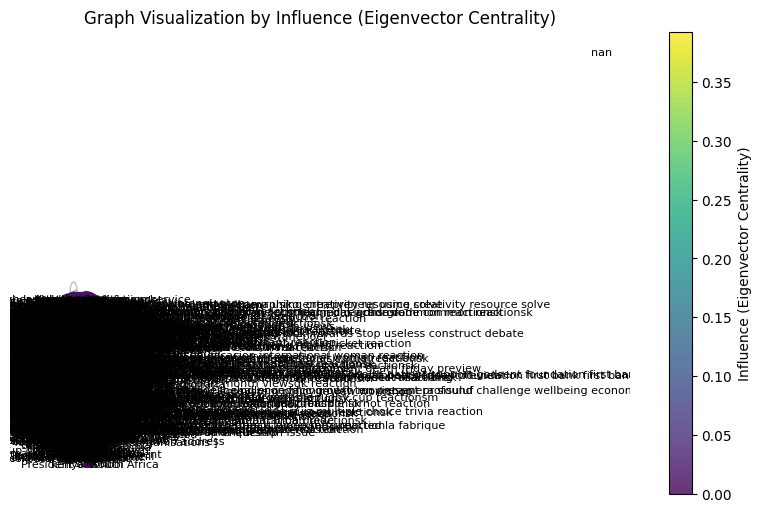

In [64]:
import ast
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Assuming your data is stored in a DataFrame named 'df_people'
# Extract relevant columns
df_subset = df_people[['topic', 'Date', 'theme', 'Head', 'Tail', 'sentiment', 'Relations', 'category', 'Views']]

# Step 1: Create a directed graph from the data
G = nx.DiGraph()

# Add nodes and edges to the graph
for _, row in df_subset.iterrows():
    topic = row['topic']
    sentiment = row['sentiment']
    relations = ast.literal_eval(row['Relations'])
    category = row['category']
    theme = row['theme']
    entities = [row['Head'], row['Tail']]
    time = row['Date']

    # Add nodes with type and time attributes
    G.add_node(topic, type='Topic', time=time)
    G.add_node(sentiment, type='Sentiment', time=time)
    G.add_node(theme, type='Theme', time=time)
    G.add_node(category, type='Category', time=time)

    for entity in entities:
        G.add_node(entity, type='Entity', time=time)

    # Add edges from Relations
    for relation in relations:
        head = relation['head']
        relation_type = relation['type']
        tail = relation['tail']
        G.add_edge(head, tail, type=relation_type, time=time)

        # Add additional edges for relationships
        G.add_edge(head, sentiment, type='Sentiment', time=time)
        G.add_edge(head, theme, type='Theme', time=time)
        G.add_edge(head, category, type='Category', time=time)
        G.add_edge(head, topic, type='Topic', time=time)

        G.add_edge(tail, sentiment, type='Sentiment', time=time)
        G.add_edge(tail, theme, type='Theme', time=time)
        G.add_edge(tail, category, type='Category', time=time)
        G.add_edge(tail, topic, type='Topic', time=time)

# Convert the directed graph to an undirected graph for influence analysis
G_undirected = G.to_undirected()

# Step 2: Ensure all nodes have a 'type' attribute
for node in G_undirected.nodes():
    if 'type' not in G_undirected.nodes[node]:
        G_undirected.nodes[node]['type'] = 'Unknown'  # Assign a default type if missing

# Step 3: Convert NetworkX graph to PyTorch Geometric format
# Get all unique nodes and label encode them
all_nodes = list(G_undirected.nodes)
node_encoder = LabelEncoder()
node_encoder.fit(all_nodes)
node_ids = node_encoder.transform(all_nodes)

# Create edge index (source and target nodes for each edge)
edge_index = []
for source, target in G_undirected.edges():
    edge_index.append([node_encoder.transform([source])[0], node_encoder.transform([target])[0]])

edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

# Use dummy node features (all ones)
num_nodes = len(G_undirected.nodes())
x = torch.ones((num_nodes, 1), dtype=torch.float)  # Feature matrix with a single feature

# Create the PyTorch Geometric data object
data = Data(x=x, edge_index=edge_index)

# Step 4: Define a simple Graph Convolutional Network (GCN)
class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Initialize the model
model = GCN(num_features=1, hidden_channels=16, num_classes=16)

# Step 5: Train the GCN model
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.mse_loss(out, torch.ones(out.shape))  # Dummy loss
    loss.backward()
    optimizer.step()
    return loss.item()

# Train for a few epochs
for epoch in range(100):
    loss = train()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss}')

# Step 6: Extract node embeddings from the trained model
model.eval()
with torch.no_grad():
    embeddings = model(data).numpy()

# Step 7: Analyze influence using eigenvector centrality
eigenvector_centrality = nx.eigenvector_centrality(G_undirected, max_iter=1000)

# Assign the eigenvector centrality as an attribute to each node
nx.set_node_attributes(G_undirected, eigenvector_centrality, "influence")

# Assign embeddings to the nodes
embedding_as_string = {node: ','.join(map(str, embedding)) for node, embedding in zip(G_undirected.nodes, embeddings)}
nx.set_node_attributes(G_undirected, embedding_as_string, "embedding")

# Step 8: Save the Graph with Embeddings and Influence
nx.write_gexf(G_undirected, "influence_graph_with_embeddings_eigenvector.gexf")

# Step 9: Visualize the Graph by Influence
plt.figure(figsize=(10, 6))

# Use a layout algorithm for positioning nodes
pos = nx.spring_layout(G_undirected, seed=42)

# Scale node sizes by eigenvector centrality
node_sizes = [5000 * eigenvector_centrality[node] for node in G_undirected.nodes()]

# Draw the graph
nodes = nx.draw_networkx_nodes(
    G_undirected, pos,
    node_size=node_sizes,
    node_color=list(eigenvector_centrality.values()),
    cmap='viridis', alpha=0.8
)
nx.draw_networkx_edges(G_undirected, pos, alpha=0.5, edge_color='gray')
nx.draw_networkx_labels(G_undirected, pos, font_size=8, font_color='black')

# Add a color bar for influence
plt.colorbar(nodes, label="Influence (Eigenvector Centrality)")
plt.title("Graph Visualization by Influence (Eigenvector Centrality)")
plt.axis("off")
plt.show()


In [65]:
import networkx as nx

# Assuming 'G' is your graph
# Calculate eigenvector centrality for each node
eigenvector_centralities = nx.eigenvector_centrality(G)

# Sort nodes based on eigenvector centrality
top_nodes_by_eigenvector_centrality = sorted(eigenvector_centralities.items(), key=lambda x: x[1], reverse=True)[:10]

print("Top ten nodes by eigenvector centrality:")
for node, centrality in top_nodes_by_eigenvector_centrality:
    print(f"Node: {node}")


Top ten nodes by eigenvector centrality:
Node: neutral
Node: ['persons']
Node: poverty
Node: employment
Node: hacking for business
Node: ['persons', 'organisations']
Node: youth unemployment and poverty in south africa
Node: entrepreneurial innovation challenge
Node: others
Node: positive


## link analysis

Epoch 0, Loss: 1.4069513082504272
Epoch 10, Loss: 0.4678579568862915
Epoch 20, Loss: 0.12974412739276886
Epoch 30, Loss: 0.10192251950502396
Epoch 40, Loss: 0.08460958302021027
Epoch 50, Loss: 0.07423365861177444
Epoch 60, Loss: 0.06875864416360855
Epoch 70, Loss: 0.06308026611804962
Epoch 80, Loss: 0.05858830362558365
Epoch 90, Loss: 0.05417698249220848


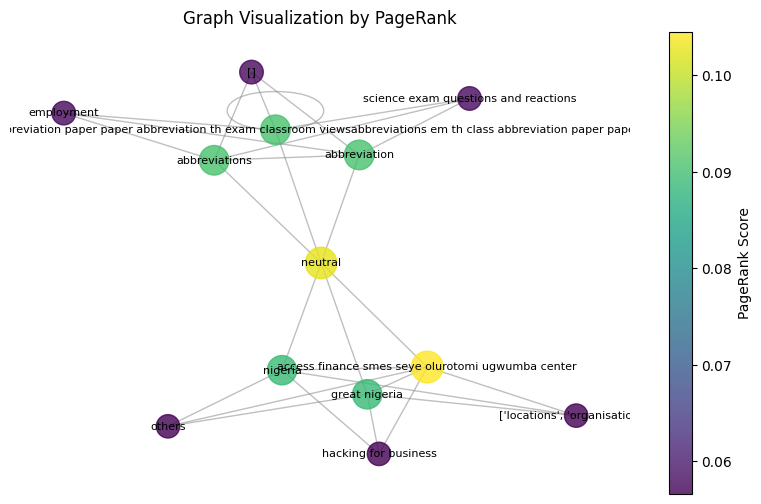

In [66]:
import ast
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Assuming your data is stored in a DataFrame named 'df_people'
# Extract relevant columns
df_subset = df2[['topic', 'Date', 'theme', 'Head', 'Tail', 'sentiment', 'Relations', 'category', 'Views']]

# Step 1: Create a directed graph from the data
G = nx.DiGraph()

# Add nodes and edges to the graph
for _, row in df_subset.iterrows():
    topic = row['topic']
    sentiment = row['sentiment']
    relations = ast.literal_eval(row['Relations'])
    category = row['category']
    theme = row['theme']
    entities = [row['Head'], row['Tail']]
    time = row['Date']

    # Add nodes with type and time attributes
    G.add_node(topic, type='Topic', time=time)
    G.add_node(sentiment, type='Sentiment', time=time)
    G.add_node(theme, type='Theme', time=time)
    G.add_node(category, type='Category', time=time)

    for entity in entities:
        G.add_node(entity, type='Entity', time=time)

    # Add edges from Relations
    for relation in relations:
        head = relation['head']
        relation_type = relation['type']
        tail = relation['tail']
        G.add_edge(head, tail, type=relation_type, time=time)

        # Add additional edges for relationships
        G.add_edge(head, sentiment, type='Sentiment', time=time)
        G.add_edge(head, theme, type='Theme', time=time)
        G.add_edge(head, category, type='Category', time=time)
        G.add_edge(head, topic, type='Topic', time=time)

        G.add_edge(tail, sentiment, type='Sentiment', time=time)
        G.add_edge(tail, theme, type='Theme', time=time)
        G.add_edge(tail, category, type='Category', time=time)
        G.add_edge(tail, topic, type='Topic', time=time)

# Convert the directed graph to an undirected graph
G_undirected = G.to_undirected()

# Step 2: Ensure all nodes have a 'type' attribute
for node in G_undirected.nodes():
    if 'type' not in G_undirected.nodes[node]:
        G_undirected.nodes[node]['type'] = 'Unknown'  # Assign a default type if missing

# Step 3: Convert NetworkX graph to PyTorch Geometric format
# Get all unique nodes and label encode them
all_nodes = list(G_undirected.nodes)
node_encoder = LabelEncoder()
node_encoder.fit(all_nodes)
node_ids = node_encoder.transform(all_nodes)

# Create edge index (source and target nodes for each edge)
edge_index = []
for source, target in G_undirected.edges():
    edge_index.append([node_encoder.transform([source])[0], node_encoder.transform([target])[0]])

edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

# Use dummy node features (all ones)
num_nodes = len(G_undirected.nodes())
x = torch.ones((num_nodes, 1), dtype=torch.float)  # Feature matrix with a single feature

# Create the PyTorch Geometric data object
data = Data(x=x, edge_index=edge_index)

# Step 4: Define a simple Graph Convolutional Network (GCN)
class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Initialize the model
model = GCN(num_features=1, hidden_channels=16, num_classes=16)

# Step 5: Train the GCN model
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.mse_loss(out, torch.ones(out.shape))  # Dummy loss
    loss.backward()
    optimizer.step()
    return loss.item()

# Train for a few epochs
for epoch in range(100):
    loss = train()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss}')

# Step 6: Extract node embeddings from the trained model
model.eval()
with torch.no_grad():
    embeddings = model(data).numpy()

# Step 7: Perform link analysis using PageRank
pagerank_scores = nx.pagerank(G_undirected)

# Assign the PageRank scores as an attribute to each node
nx.set_node_attributes(G_undirected, pagerank_scores, "pagerank")

# Assign embeddings to the nodes
embedding_as_string = {node: ','.join(map(str, embedding)) for node, embedding in zip(G_undirected.nodes, embeddings)}
nx.set_node_attributes(G_undirected, embedding_as_string, "embedding")

# Step 8: Save the Graph with PageRank and Embeddings
nx.write_gexf(G_undirected, "pagerank_graph_with_embeddings.gexf")

# Step 9: Visualize the Graph by PageRank
plt.figure(figsize=(10, 6))

# Use a layout algorithm for positioning nodes
pos = nx.spring_layout(G_undirected, seed=42)

# Scale node sizes by PageRank scores
node_sizes = [5000 * pagerank_scores[node] for node in G_undirected.nodes()]

# Draw the graph
nodes = nx.draw_networkx_nodes(
    G_undirected, pos,
    node_size=node_sizes,
    node_color=list(pagerank_scores.values()),
    cmap='viridis', alpha=0.8
)
nx.draw_networkx_edges(G_undirected, pos, alpha=0.5, edge_color='gray')
nx.draw_networkx_labels(G_undirected, pos, font_size=8, font_color='black')

# Add a color bar for PageRank scores
plt.colorbar(nodes, label="PageRank Score")
plt.title("Graph Visualization by PageRank")
plt.axis("off")
plt.show()


Epoch 0, Loss: 1.1778684854507446
Epoch 10, Loss: 0.4563465118408203
Epoch 20, Loss: 0.16260412335395813
Epoch 30, Loss: 0.05470753461122513
Epoch 40, Loss: 0.026319848373532295
Epoch 50, Loss: 0.013050679117441177
Epoch 60, Loss: 0.009583940729498863
Epoch 70, Loss: 0.009452215395867825
Epoch 80, Loss: 0.00913822278380394
Epoch 90, Loss: 0.008792961947619915


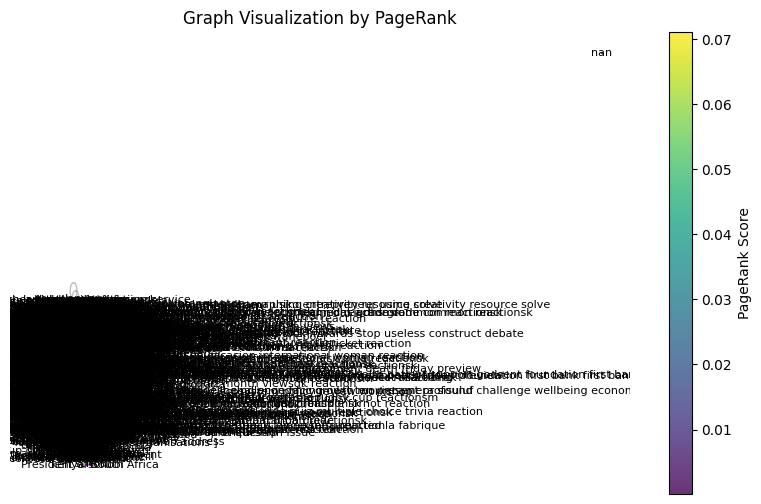

In [67]:
import ast
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Assuming your data is stored in a DataFrame named 'df_people'
# Extract relevant columns
df_subset = df_people[['topic', 'Date', 'theme', 'Head', 'Tail', 'sentiment', 'Relations', 'category', 'Views']]

# Step 1: Create a directed graph from the data
G = nx.DiGraph()

# Add nodes and edges to the graph
for _, row in df_subset.iterrows():
    topic = row['topic']
    sentiment = row['sentiment']
    relations = ast.literal_eval(row['Relations'])
    category = row['category']
    theme = row['theme']
    entities = [row['Head'], row['Tail']]
    time = row['Date']

    # Add nodes with type and time attributes
    G.add_node(topic, type='Topic', time=time)
    G.add_node(sentiment, type='Sentiment', time=time)
    G.add_node(theme, type='Theme', time=time)
    G.add_node(category, type='Category', time=time)

    for entity in entities:
        G.add_node(entity, type='Entity', time=time)

    # Add edges from Relations
    for relation in relations:
        head = relation['head']
        relation_type = relation['type']
        tail = relation['tail']
        G.add_edge(head, tail, type=relation_type, time=time)

        # Add additional edges for relationships
        G.add_edge(head, sentiment, type='Sentiment', time=time)
        G.add_edge(head, theme, type='Theme', time=time)
        G.add_edge(head, category, type='Category', time=time)
        G.add_edge(head, topic, type='Topic', time=time)

        G.add_edge(tail, sentiment, type='Sentiment', time=time)
        G.add_edge(tail, theme, type='Theme', time=time)
        G.add_edge(tail, category, type='Category', time=time)
        G.add_edge(tail, topic, type='Topic', time=time)

# Convert the directed graph to an undirected graph
G_undirected = G.to_undirected()

# Step 2: Ensure all nodes have a 'type' attribute
for node in G_undirected.nodes():
    if 'type' not in G_undirected.nodes[node]:
        G_undirected.nodes[node]['type'] = 'Unknown'  # Assign a default type if missing

# Step 3: Convert NetworkX graph to PyTorch Geometric format
# Get all unique nodes and label encode them
all_nodes = list(G_undirected.nodes)
node_encoder = LabelEncoder()
node_encoder.fit(all_nodes)
node_ids = node_encoder.transform(all_nodes)

# Create edge index (source and target nodes for each edge)
edge_index = []
for source, target in G_undirected.edges():
    edge_index.append([node_encoder.transform([source])[0], node_encoder.transform([target])[0]])

edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

# Use dummy node features (all ones)
num_nodes = len(G_undirected.nodes())
x = torch.ones((num_nodes, 1), dtype=torch.float)  # Feature matrix with a single feature

# Create the PyTorch Geometric data object
data = Data(x=x, edge_index=edge_index)

# Step 4: Define a simple Graph Convolutional Network (GCN)
class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Initialize the model
model = GCN(num_features=1, hidden_channels=16, num_classes=16)

# Step 5: Train the GCN model
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.mse_loss(out, torch.ones(out.shape))  # Dummy loss
    loss.backward()
    optimizer.step()
    return loss.item()

# Train for a few epochs
for epoch in range(100):
    loss = train()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss}')

# Step 6: Extract node embeddings from the trained model
model.eval()
with torch.no_grad():
    embeddings = model(data).numpy()

# Step 7: Perform link analysis using PageRank
pagerank_scores = nx.pagerank(G_undirected)

# Assign the PageRank scores as an attribute to each node
nx.set_node_attributes(G_undirected, pagerank_scores, "pagerank")

# Assign embeddings to the nodes
embedding_as_string = {node: ','.join(map(str, embedding)) for node, embedding in zip(G_undirected.nodes, embeddings)}
nx.set_node_attributes(G_undirected, embedding_as_string, "embedding")

# Step 8: Save the Graph with PageRank and Embeddings
nx.write_gexf(G_undirected, "pagerank_graph_with_embeddings.gexf")

# Step 9: Visualize the Graph by PageRank
plt.figure(figsize=(10, 6))

# Use a layout algorithm for positioning nodes
pos = nx.spring_layout(G_undirected, seed=42)

# Scale node sizes by PageRank scores
node_sizes = [5000 * pagerank_scores[node] for node in G_undirected.nodes()]

# Draw the graph
nodes = nx.draw_networkx_nodes(
    G_undirected, pos,
    node_size=node_sizes,
    node_color=list(pagerank_scores.values()),
    cmap='viridis', alpha=0.8
)
nx.draw_networkx_edges(G_undirected, pos, alpha=0.5, edge_color='gray')
nx.draw_networkx_labels(G_undirected, pos, font_size=8, font_color='black')

# Add a color bar for PageRank scores
plt.colorbar(nodes, label="PageRank Score")
plt.title("Graph Visualization by PageRank")
plt.axis("off")
plt.show()


In [68]:
import networkx as nx

# Assuming 'G' is your graph
# Calculate PageRank for each node
pageranks = nx.pagerank(G)

# Sort nodes based on PageRank
top_nodes_by_pagerank = sorted(pageranks.items(), key=lambda x: x[1], reverse=True)[:10]

print("Top ten nodes by PageRank:")
for node, rank in top_nodes_by_pagerank:
    print(f"Node: {node}")


Top ten nodes by PageRank:
Node: ['persons']
Node: neutral
Node: others
Node: science exam questions and reactions
Node: poverty
Node: employment
Node: hacking for business
Node: health
Node: ['persons', 'organisations']
Node: education


Epoch 0, Loss: 1.2747467756271362
Epoch 10, Loss: 0.3872916102409363
Epoch 20, Loss: 0.12560990452766418
Epoch 30, Loss: 0.1007644310593605
Epoch 40, Loss: 0.08232888579368591
Epoch 50, Loss: 0.07516869157552719
Epoch 60, Loss: 0.06718452274799347
Epoch 70, Loss: 0.061960045248270035
Epoch 80, Loss: 0.05691039562225342
Epoch 90, Loss: 0.05217154324054718


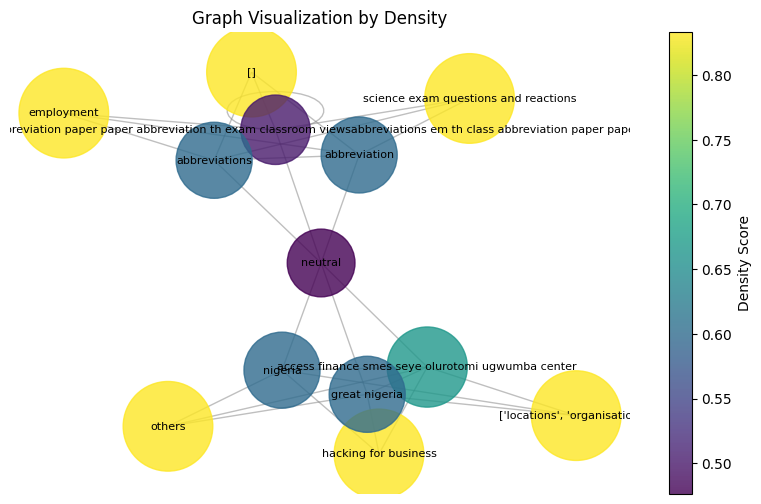

In [69]:
import ast
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Assuming your data is stored in a DataFrame named 'df_people'
# Extract relevant columns
df_subset = df2[['topic', 'Date', 'theme', 'Head', 'Tail', 'sentiment', 'Relations', 'category', 'Views']]

# Step 1: Create a directed graph from the data
G = nx.DiGraph()

# Add nodes and edges to the graph
for _, row in df_subset.iterrows():
    topic = row['topic']
    sentiment = row['sentiment']
    relations = ast.literal_eval(row['Relations'])
    category = row['category']
    theme = row['theme']
    entities = [row['Head'], row['Tail']]
    time = row['Date']

    # Add nodes with type and time attributes
    G.add_node(topic, type='Topic', time=time)
    G.add_node(sentiment, type='Sentiment', time=time)
    G.add_node(theme, type='Theme', time=time)
    G.add_node(category, type='Category', time=time)

    for entity in entities:
        G.add_node(entity, type='Entity', time=time)

    # Add edges from Relations
    for relation in relations:
        head = relation['head']
        relation_type = relation['type']
        tail = relation['tail']
        G.add_edge(head, tail, type=relation_type, time=time)

        # Add additional edges for relationships
        G.add_edge(head, sentiment, type='Sentiment', time=time)
        G.add_edge(head, theme, type='Theme', time=time)
        G.add_edge(head, category, type='Category', time=time)
        G.add_edge(head, topic, type='Topic', time=time)

        G.add_edge(tail, sentiment, type='Sentiment', time=time)
        G.add_edge(tail, theme, type='Theme', time=time)
        G.add_edge(tail, category, type='Category', time=time)
        G.add_edge(tail, topic, type='Topic', time=time)

# Convert the directed graph to an undirected graph
G_undirected = G.to_undirected()

# Step 2: Ensure all nodes have a 'type' attribute
for node in G_undirected.nodes():
    if 'type' not in G_undirected.nodes[node]:
        G_undirected.nodes[node]['type'] = 'Unknown'  # Assign a default type if missing

# Step 3: Convert NetworkX graph to PyTorch Geometric format
# Get all unique nodes and label encode them
all_nodes = list(G_undirected.nodes)
node_encoder = LabelEncoder()
node_encoder.fit(all_nodes)
node_ids = node_encoder.transform(all_nodes)

# Create edge index (source and target nodes for each edge)
edge_index = []
for source, target in G_undirected.edges():
    edge_index.append([node_encoder.transform([source])[0], node_encoder.transform([target])[0]])

edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

# Use dummy node features (all ones)
num_nodes = len(G_undirected.nodes())
x = torch.ones((num_nodes, 1), dtype=torch.float)  # Feature matrix with a single feature

# Create the PyTorch Geometric data object
data = Data(x=x, edge_index=edge_index)

# Step 4: Define a simple Graph Convolutional Network (GCN)
class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Initialize the model
model = GCN(num_features=1, hidden_channels=16, num_classes=16)

# Step 5: Train the GCN model
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.mse_loss(out, torch.ones(out.shape))  # Dummy loss
    loss.backward()
    optimizer.step()
    return loss.item()

# Train for a few epochs
for epoch in range(100):
    loss = train()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss}')

# Step 6: Extract node embeddings from the trained model
model.eval()
with torch.no_grad():
    embeddings = model(data).numpy()

# Step 7: Calculate density for each node's neighborhood
density_scores = {}
for node in G_undirected.nodes:
    neighbors = list(G_undirected.neighbors(node))
    subgraph = G_undirected.subgraph(neighbors + [node])  # Include the node itself
    density_scores[node] = nx.density(subgraph)

# Assign the density scores as an attribute to each node
nx.set_node_attributes(G_undirected, density_scores, "density")

# Assign embeddings to the nodes
embedding_as_string = {node: ','.join(map(str, embedding)) for node, embedding in zip(G_undirected.nodes, embeddings)}
nx.set_node_attributes(G_undirected, embedding_as_string, "embedding")

# Step 8: Save the Graph with Density and Embeddings
nx.write_gexf(G_undirected, "density_graph_with_embeddings.gexf")

# Step 9: Visualize the Graph by Density
plt.figure(figsize=(10, 6))

# Use a layout algorithm for positioning nodes
pos = nx.spring_layout(G_undirected, seed=42)

# Scale node sizes by density scores
node_sizes = [5000 * density_scores[node] for node in G_undirected.nodes()]

# Draw the graph
nodes = nx.draw_networkx_nodes(
    G_undirected, pos,
    node_size=node_sizes,
    node_color=list(density_scores.values()),
    cmap='viridis', alpha=0.8
)
nx.draw_networkx_edges(G_undirected, pos, alpha=0.5, edge_color='gray')
nx.draw_networkx_labels(G_undirected, pos, font_size=8, font_color='black')

# Add a color bar for density scores
plt.colorbar(nodes, label="Density Score")
plt.title("Graph Visualization by Density")
plt.axis("off")
plt.show()


Epoch 0, Loss: 0.8549890518188477
Epoch 10, Loss: 0.2729156017303467
Epoch 20, Loss: 0.0817987397313118
Epoch 30, Loss: 0.024334661662578583
Epoch 40, Loss: 0.013441973365843296
Epoch 50, Loss: 0.010690419003367424
Epoch 60, Loss: 0.010002213530242443
Epoch 70, Loss: 0.009393815882503986
Epoch 80, Loss: 0.009120008908212185
Epoch 90, Loss: 0.008885757997632027


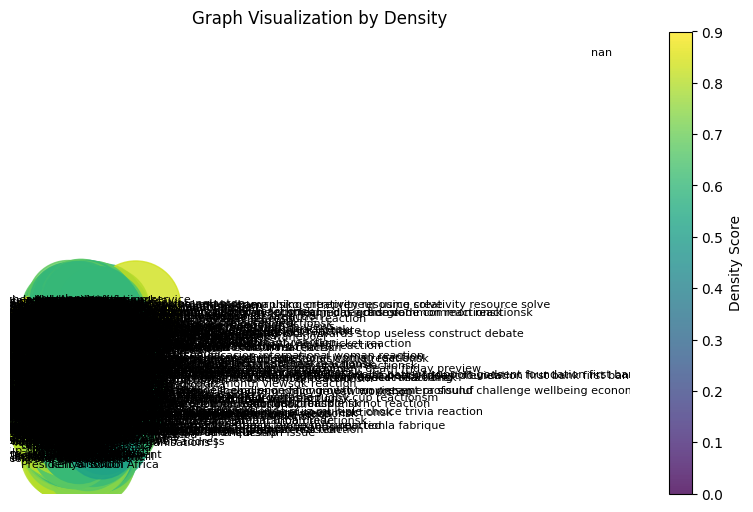

In [70]:
import ast
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Assuming your data is stored in a DataFrame named 'df_people'
# Extract relevant columns
df_subset = df_people[['topic', 'Date', 'theme', 'Head', 'Tail', 'sentiment', 'Relations', 'category', 'Views']]

# Step 1: Create a directed graph from the data
G = nx.DiGraph()

# Add nodes and edges to the graph
for _, row in df_subset.iterrows():
    topic = row['topic']
    sentiment = row['sentiment']
    relations = ast.literal_eval(row['Relations'])
    category = row['category']
    theme = row['theme']
    entities = [row['Head'], row['Tail']]
    time = row['Date']

    # Add nodes with type and time attributes
    G.add_node(topic, type='Topic', time=time)
    G.add_node(sentiment, type='Sentiment', time=time)
    G.add_node(theme, type='Theme', time=time)
    G.add_node(category, type='Category', time=time)

    for entity in entities:
        G.add_node(entity, type='Entity', time=time)

    # Add edges from Relations
    for relation in relations:
        head = relation['head']
        relation_type = relation['type']
        tail = relation['tail']
        G.add_edge(head, tail, type=relation_type, time=time)

        # Add additional edges for relationships
        G.add_edge(head, sentiment, type='Sentiment', time=time)
        G.add_edge(head, theme, type='Theme', time=time)
        G.add_edge(head, category, type='Category', time=time)
        G.add_edge(head, topic, type='Topic', time=time)

        G.add_edge(tail, sentiment, type='Sentiment', time=time)
        G.add_edge(tail, theme, type='Theme', time=time)
        G.add_edge(tail, category, type='Category', time=time)
        G.add_edge(tail, topic, type='Topic', time=time)

# Convert the directed graph to an undirected graph
G_undirected = G.to_undirected()

# Step 2: Ensure all nodes have a 'type' attribute
for node in G_undirected.nodes():
    if 'type' not in G_undirected.nodes[node]:
        G_undirected.nodes[node]['type'] = 'Unknown'  # Assign a default type if missing

# Step 3: Convert NetworkX graph to PyTorch Geometric format
# Get all unique nodes and label encode them
all_nodes = list(G_undirected.nodes)
node_encoder = LabelEncoder()
node_encoder.fit(all_nodes)
node_ids = node_encoder.transform(all_nodes)

# Create edge index (source and target nodes for each edge)
edge_index = []
for source, target in G_undirected.edges():
    edge_index.append([node_encoder.transform([source])[0], node_encoder.transform([target])[0]])

edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

# Use dummy node features (all ones)
num_nodes = len(G_undirected.nodes())
x = torch.ones((num_nodes, 1), dtype=torch.float)  # Feature matrix with a single feature

# Create the PyTorch Geometric data object
data = Data(x=x, edge_index=edge_index)

# Step 4: Define a simple Graph Convolutional Network (GCN)
class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Initialize the model
model = GCN(num_features=1, hidden_channels=16, num_classes=16)

# Step 5: Train the GCN model
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.mse_loss(out, torch.ones(out.shape))  # Dummy loss
    loss.backward()
    optimizer.step()
    return loss.item()

# Train for a few epochs
for epoch in range(100):
    loss = train()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss}')

# Step 6: Extract node embeddings from the trained model
model.eval()
with torch.no_grad():
    embeddings = model(data).numpy()

# Step 7: Calculate density for each node's neighborhood
density_scores = {}
for node in G_undirected.nodes:
    neighbors = list(G_undirected.neighbors(node))
    subgraph = G_undirected.subgraph(neighbors + [node])  # Include the node itself
    density_scores[node] = nx.density(subgraph)

# Assign the density scores as an attribute to each node
nx.set_node_attributes(G_undirected, density_scores, "density")

# Assign embeddings to the nodes
embedding_as_string = {node: ','.join(map(str, embedding)) for node, embedding in zip(G_undirected.nodes, embeddings)}
nx.set_node_attributes(G_undirected, embedding_as_string, "embedding")

# Step 8: Save the Graph with Density and Embeddings
nx.write_gexf(G_undirected, "density_graph_with_embeddings.gexf")

# Step 9: Visualize the Graph by Density
plt.figure(figsize=(10, 6))

# Use a layout algorithm for positioning nodes
pos = nx.spring_layout(G_undirected, seed=42)

# Scale node sizes by density scores
node_sizes = [5000 * density_scores[node] for node in G_undirected.nodes()]

# Draw the graph
nodes = nx.draw_networkx_nodes(
    G_undirected, pos,
    node_size=node_sizes,
    node_color=list(density_scores.values()),
    cmap='viridis', alpha=0.8
)
nx.draw_networkx_edges(G_undirected, pos, alpha=0.5, edge_color='gray')
nx.draw_networkx_labels(G_undirected, pos, font_size=8, font_color='black')

# Add a color bar for density scores
plt.colorbar(nodes, label="Density Score")
plt.title("Graph Visualization by Density")
plt.axis("off")
plt.show()


In [71]:
import networkx as nx

# Assuming 'G' is your graph
# Calculate density for each node
density = {node: nx.density(nx.ego_graph(G, node)) for node in G.nodes()}

# Sort nodes based on density
top_nodes_by_density = sorted(density.items(), key=lambda x: x[1], reverse=True)[:10]

print("Top ten nodes by density:")
for node, dens in top_nodes_by_density:
    print(f"Node: {node}")


Top ten nodes by density:
Node: tedx talk speech
Node: sean stephenson
Node: itrademarkm
Node: central sulawesi
Node: wealth concentration
Node: star war undercover bos starkiller base snl saturday night live reactionsm
Node: tedx talk speech said ne
Node: tiktok keller williams
Node: professor muhammad yunus
Node: zero net carbon emission


Epoch 0, Loss: 1.2115312814712524
Epoch 10, Loss: 0.371639221906662
Epoch 20, Loss: 0.1503167599439621
Epoch 30, Loss: 0.09428652375936508
Epoch 40, Loss: 0.0809444859623909
Epoch 50, Loss: 0.07358004152774811
Epoch 60, Loss: 0.06614145636558533
Epoch 70, Loss: 0.06067474186420441
Epoch 80, Loss: 0.05557398125529289
Epoch 90, Loss: 0.050839636474847794


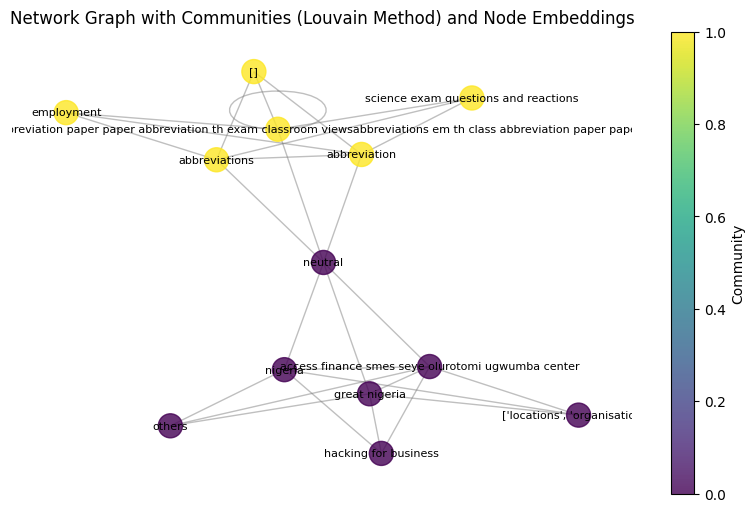

In [73]:
import ast
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import community as community_louvain  # For Louvain method

# Assuming your data is stored in a DataFrame named 'df_people'
# Extract relevant columns
df_subset = df2[['topic', 'Date', 'theme', 'Head', 'Tail', 'sentiment', 'Relations', 'category', 'Views']]

# Step 1: Create a directed graph from the data
G = nx.DiGraph()

# Add nodes and edges to the graph
for _, row in df_subset.iterrows():
    topic = row['topic']
    sentiment = row['sentiment']
    relations = ast.literal_eval(row['Relations'])
    category = row['category']
    theme = row['theme']
    entities = [row['Head'], row['Tail']]
    time = row['Date']

    # Add nodes with type and time attributes
    G.add_node(topic, type='Topic', time=time)
    G.add_node(sentiment, type='Sentiment', time=time)
    G.add_node(theme, type='Theme', time=time)
    G.add_node(category, type='Category', time=time)

    for entity in entities:
        G.add_node(entity, type='Entity', time=time)

    # Add edges from Relations
    for relation in relations:
        head = relation['head']
        relation_type = relation['type']
        tail = relation['tail']
        G.add_edge(head, tail, type=relation_type, time=time)

        # Add additional edges for relationships
        G.add_edge(head, sentiment, type='Sentiment', time=time)
        G.add_edge(head, theme, type='Theme', time=time)
        G.add_edge(head, category, type='Category', time=time)
        G.add_edge(head, topic, type='Topic', time=time)

        G.add_edge(tail, sentiment, type='Sentiment', time=time)
        G.add_edge(tail, theme, type='Theme', time=time)
        G.add_edge(tail, category, type='Category', time=time)
        G.add_edge(tail, topic, type='Topic', time=time)

# Convert the directed graph to an undirected graph
G_undirected = G.to_undirected()

# Step 2: Ensure all nodes have a 'type' attribute
for node in G_undirected.nodes():
    if 'type' not in G_undirected.nodes[node]:
        G_undirected.nodes[node]['type'] = 'Unknown'  # Assign a default type if missing

# Step 3: Convert NetworkX graph to PyTorch Geometric format
# Get all unique nodes and label encode them
all_nodes = list(G_undirected.nodes)
node_encoder = LabelEncoder()
node_encoder.fit(all_nodes)
node_ids = node_encoder.transform(all_nodes)

# Create edge index (source and target nodes for each edge)
edge_index = []
for source, target in G_undirected.edges():
    edge_index.append([node_encoder.transform([source])[0], node_encoder.transform([target])[0]])

edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

# Use dummy node features (all ones)
num_nodes = len(G_undirected.nodes())
x = torch.ones((num_nodes, 1), dtype=torch.float)  # Feature matrix with a single feature

# Create the PyTorch Geometric data object
data = Data(x=x, edge_index=edge_index)

# Step 4: Define a simple Graph Convolutional Network (GCN)
class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Initialize the model
model = GCN(num_features=1, hidden_channels=16, num_classes=16)

# Step 5: Train the GCN model
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.mse_loss(out, torch.ones(out.shape))  # Dummy loss
    loss.backward()
    optimizer.step()
    return loss.item()

# Train for a few epochs
for epoch in range(100):
    loss = train()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss}')

# Step 6: Extract node embeddings from the trained model
model.eval()
with torch.no_grad():
    embeddings = model(data).numpy()

# Step 7: Perform Community Detection using Louvain Method
# Detect communities using Louvain method
partition = community_louvain.best_partition(G_undirected)

# Assign community to each node
nx.set_node_attributes(G_undirected, partition, "community")

# Assign embeddings to each node, converting lists to strings for GEXF compatibility
for node, embedding in zip(G_undirected.nodes, embeddings):
    G_undirected.nodes[node]['embedding'] = str(embedding.tolist())  # Convert embedding to a string

# Step 8: Save the Graph with Embeddings and Communities
nx.write_gexf(G_undirected, "community_graph_with_embeddings.gexf")

# Step 9: Visualize the Community-based Graph with Embeddings
plt.figure(figsize=(10, 6))

# Use a layout algorithm for positioning nodes
pos = nx.spring_layout(G_undirected, seed=42)

# Color nodes based on community
node_colors = [partition.get(node, -1) for node in G_undirected.nodes()]

# Draw the nodes
nodes = nx.draw_networkx_nodes(
    G_undirected, pos,
    node_color=node_colors, cmap='viridis',
    node_size=300, alpha=0.8
)

# Draw edges
nx.draw_networkx_edges(G_undirected, pos, edge_color='gray', alpha=0.5)

# Optionally draw labels (can be omitted for large graphs)
nx.draw_networkx_labels(G_undirected, pos, font_size=8, font_color='black')

# Add a color bar for community colors
plt.colorbar(nodes, label='Community')

# Title and axis
plt.title("Network Graph with Communities (Louvain Method) and Node Embeddings")
plt.axis("off")
plt.show()


In [ ]:
df_people

topic                 Date      theme  \
335                    hacking for business  2022-06-13 00:00:00    poverty   
335                    hacking for business  2022-06-13 00:00:00  education   
335                    hacking for business  2022-06-13 00:00:00     health   
766                    hacking for business  2022-02-17 00:00:00     others   
767                    hacking for business  2022-02-17 00:00:00     others   
...                                     ...                  ...        ...   
65622                  hacking for business  2022-11-25 00:00:00  education   
65623                  hacking for business  2022-11-25 00:00:00  education   
66809  science exam questions and reactions           2021-08-24  education   
66810  science exam questions and reactions           2021-08-24  education   
66811  science exam questions and reactions           2021-08-24  education   

                               Head                          Tail sentiment  \
335            jonathan oppenheimer            executive chairman   neutral   
335            jonathan oppenheimer            executive chairman   neutral   
335            jonathan oppenheimer            executive chairman   neutral   
766              anton jeftha boity       david jeftha boitythulo  positive   
767         david jeftha boitythulo            anton jeftha boity  positive   
...                             ...                           ...       ...   
65622                viewspresident               cyril ramaphosa   neutral   
65623               Cyril ramaphosa                viewspresident   neutral   
66809  black market afrika reaction                        afrika   neutral   
66810  black market afrika reaction                  black market   neutral   
66811  black market afrika reaction  black market afrika reaction   neutral   

                                               Relations  \
335    [{'head': 'executive chairman', 'type': 'subcl...   
335    [{'head': 'executive chairman', 'type': 'subcl...   
335    [{'head': 'executive chairman', 'type': 'subcl...   
766    [{'head': 'anton jeftha boity', 'type': 'spous...   
767    [{'head': 'anton jeftha boity', 'type': 'spous...   
...                                                  ...   
65622  [{'head': 'cyril ramaphosa', 'type': 'position...   
65623  [{'head': 'cyril ramaphosa', 'type': 'position...   
66809  [{'head': 'black market afrika reaction', 'typ...   
66810  [{'head': 'black market afrika reaction', 'typ...   
66811  [{'head': 'black market afrika reaction', 'typ...   

                           category Views  
335                     ['persons']    29  
335                     ['persons']    29  
335                     ['persons']    29  
766    ['persons', 'organisations']   625  
767    ['persons', 'organisations']   625  
...                             ...   ...  
65622                   ['persons']   107  
65623                   ['persons']   107  
66809                   ['persons']   858  
66810                   ['persons']   858  
66811                   ['persons']   858  

[1265 rows x 9 columns]

In [74]:
df_org

topic                       Date       theme  \
203      hacking for business                        nan      others   
204      hacking for business                        nan      others   
205      hacking for business                        nan      others   
248      hacking for business        2019-12-06 00:00:00   education   
249      hacking for business        2019-12-06 00:00:00   education   
...                       ...                        ...         ...   
66280  ghanaian election news                 2019-08-24    security   
66280  ghanaian election news                 2019-08-24      health   
66349    hacking for business        2018-11-05 00:00:00  employment   
66480              trademarks  2020-09-05 14:36:43+00:00      others   
66481              trademarks  2020-09-05 14:36:43+00:00      others   

                                                    Head             Tail  \
203    access finance smes seye olurotomi ugwumba center    great nigeria   
204    access finance smes seye olurotomi ugwumba center    great nigeria   
205    access finance smes seye olurotomi ugwumba center          nigeria   
248                                          accor group            accor   
249                                     dec k viewsaccor      accor group   
...                                                  ...              ...   
66280             Young population challenge development      issafricatv   
66280             Young population challenge development      issafricatv   
66349                          Un office special adviser  special adviser   
66480                                china design museum       minimalism   
66481                                china design museum       minimalism   

      sentiment                                          Relations  \
203     neutral  [{'head': 'access finance smes seye olurotomi ...   
204     neutral  [{'head': 'access finance smes seye olurotomi ...   
205     neutral  [{'head': 'access finance smes seye olurotomi ...   
248     neutral  [{'head': 'willis', 'type': 'instance of', 'ta...   
249     neutral  [{'head': 'willis', 'type': 'instance of', 'ta...   
...         ...                                                ...   
66280   neutral  [{'head': 'youth population challenge developm...   
66280   neutral  [{'head': 'youth population challenge developm...   
66349   neutral  [{'head': 'sustainable peace development', 'ty...   
66480   neutral  [{'head': 'surging tide', 'type': 'genre', 'ta...   
66481   neutral  [{'head': 'surging tide', 'type': 'genre', 'ta...   

                             category Views  
203    ['locations', 'organisations']   253  
204    ['locations', 'organisations']   253  
205                 ['organisations']   253  
248                 ['organisations']  2800  
249                 ['organisations']  2800  
...                               ...   ...  
66280               ['organisations']   831  
66280               ['organisations']   831  
66349               ['organisations']  2200  
66480               ['organisations']     8  
66481               ['organisations']     8  

[865 rows x 9 columns]

Epoch 0, Loss: 1.052272915840149
Epoch 10, Loss: 0.3363148868083954
Epoch 20, Loss: 0.0678657665848732
Epoch 30, Loss: 0.025570601224899292
Epoch 40, Loss: 0.025470774620771408
Epoch 50, Loss: 0.01643138937652111
Epoch 60, Loss: 0.01473834365606308
Epoch 70, Loss: 0.014340410009026527
Epoch 80, Loss: 0.01377949770539999
Epoch 90, Loss: 0.013464602641761303


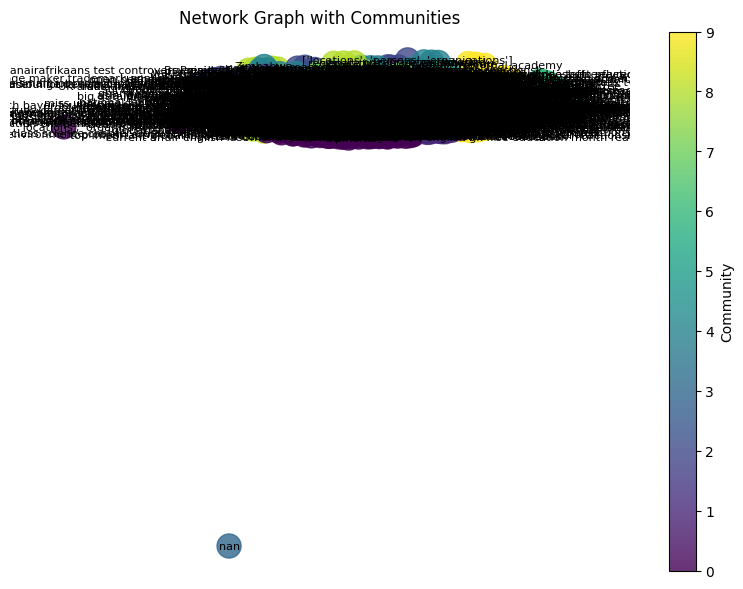

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


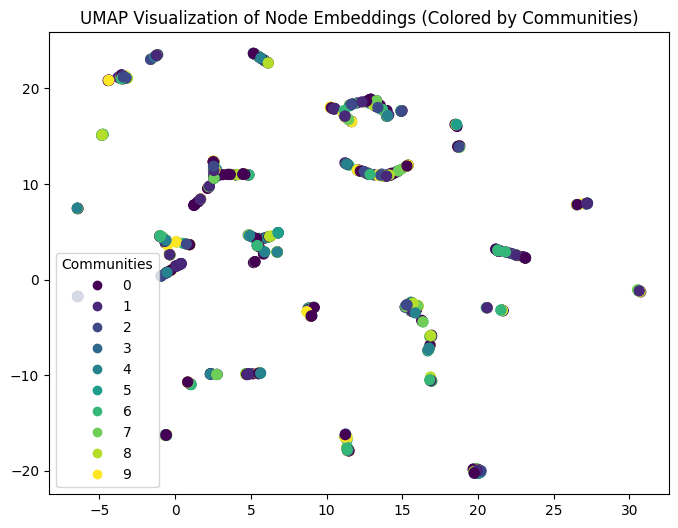

In [75]:
import ast
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import community as community_louvain  # For Louvain method
import umap  # UMAP for dimensionality reduction

# Assuming your data is stored in a DataFrame named 'df_people'
# Extract relevant columns
df_subset = df_org[['topic', 'Date', 'theme', 'Head', 'Tail', 'sentiment', 'Relations', 'category', 'Views']]

# Step 1: Create a directed graph from the data
G = nx.DiGraph()

# Add nodes and edges to the graph
for _, row in df_subset.iterrows():
    topic = row['topic']
    sentiment = row['sentiment']
    relations = ast.literal_eval(row['Relations'])
    category = row['category']
    theme = row['theme']
    entities = [row['Head'], row['Tail']]
    time = row['Date']

    # Add nodes with type and time attributes
    G.add_node(topic, type='Topic', time=time)
    G.add_node(sentiment, type='Sentiment', time=time)
    G.add_node(theme, type='Theme', time=time)
    G.add_node(category, type='Category', time=time)

    for entity in entities:
        G.add_node(entity, type='Entity', time=time)

    # Add edges from Relations
    for relation in relations:
        head = relation['head']
        relation_type = relation['type']
        tail = relation['tail']
        G.add_edge(head, tail, type=relation_type, time=time)

        # Add additional edges for relationships
        G.add_edge(head, sentiment, type='Sentiment', time=time)
        G.add_edge(head, theme, type='Theme', time=time)
        G.add_edge(head, category, type='Category', time=time)
        G.add_edge(head, topic, type='Topic', time=time)

        G.add_edge(tail, sentiment, type='Sentiment', time=time)
        G.add_edge(tail, theme, type='Theme', time=time)
        G.add_edge(tail, category, type='Category', time=time)
        G.add_edge(tail, topic, type='Topic', time=time)

# Convert the directed graph to an undirected graph for community detection
G_undirected = G.to_undirected()

# Step 2: Ensure all nodes have a 'type' attribute
for node in G_undirected.nodes():
    if 'type' not in G_undirected.nodes[node]:
        G_undirected.nodes[node]['type'] = 'Unknown'  # Assign a default type if missing

# Step 3: Convert NetworkX graph to PyTorch Geometric format

# Get all unique nodes and label encode them
all_nodes = list(G_undirected.nodes)
node_encoder = LabelEncoder()
node_encoder.fit(all_nodes)
node_ids = node_encoder.transform(all_nodes)

# Create edge index (source and target nodes for each edge)
edge_index = []
for source, target in G_undirected.edges():
    edge_index.append([node_encoder.transform([source])[0], node_encoder.transform([target])[0]])

edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

# Use dummy node features (all ones)
num_nodes = len(G_undirected.nodes())
x = torch.ones((num_nodes, 1), dtype=torch.float)  # Feature matrix with a single feature

# Create the PyTorch Geometric data object
data = Data(x=x, edge_index=edge_index)

# Step 4: Define a simple Graph Convolutional Network (GCN)

class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Initialize the model
model = GCN(num_features=1, hidden_channels=16, num_classes=16)

# Step 5: Train the GCN model
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.mse_loss(out, torch.ones(out.shape))  # Dummy loss
    loss.backward()
    optimizer.step()
    return loss.item()

# Train for a few epochs
for epoch in range(100):
    loss = train()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss}')

# Step 6: Extract node embeddings from the trained model
model.eval()
with torch.no_grad():
    embeddings = model(data)

# Step 7: Detect communities using the Louvain method
node_community = community_louvain.best_partition(G_undirected)

# Assign the community as an attribute to each node
for node, community in node_community.items():
    G_undirected.nodes[node]['community'] = community

# Step 8: Visualize the graph with a clearer layout
plt.figure(figsize=(10, 7))  # Adjusted figure size

# Use a layout algorithm for positioning nodes
pos = nx.spring_layout(G_undirected, seed=42)  # Spring layout for visualization

# Step 9: Color nodes by community
node_colors = [node_community.get(node, -1) for node in G_undirected.nodes]

# Draw the nodes with community colors
nodes = nx.draw_networkx_nodes(
    G_undirected, pos,
    node_color=node_colors, cmap='viridis',
    node_size=300, alpha=0.8
)

# Draw the edges
nx.draw_networkx_edges(
    G_undirected, pos,
    edge_color='gray', alpha=0.5
)

# Optionally draw labels (can be omitted for large graphs)
nx.draw_networkx_labels(
    G_undirected, pos,
    font_size=8, font_color='black'
)

# Add a color bar to represent communities
plt.colorbar(nodes, label='Community')  # Directly link the color bar to the drawn nodes

# Title and axis
plt.title("Network Graph with Communities")
plt.axis("off")
plt.show()

# Step 10: Reduce the embeddings to 2D using UMAP
umap_model = umap.UMAP(n_components=2)
embeddings_2d = umap_model.fit_transform(embeddings.detach().numpy())  # Convert tensor to numpy

# Visualize the 2D embeddings colored by community
plt.figure(figsize=(8, 6))  # Adjusted figure size
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=list(node_community.values()), cmap='viridis', s=50)
plt.legend(*scatter.legend_elements(), title="Communities")
plt.title("UMAP Visualization of Node Embeddings (Colored by Communities)")
plt.show()

# Step 11: Save the graph with community information
nx.write_gexf(G_undirected, "community_graph_org.gexf")

Epoch 0, Loss: 0.9721243977546692
Epoch 10, Loss: 0.16461081802845
Epoch 20, Loss: 0.0415351428091526
Epoch 30, Loss: 0.028807636350393295
Epoch 40, Loss: 0.020217079669237137
Epoch 50, Loss: 0.017740489915013313
Epoch 60, Loss: 0.016180213540792465
Epoch 70, Loss: 0.015490252524614334
Epoch 80, Loss: 0.01512793730944395
Epoch 90, Loss: 0.014699705876410007


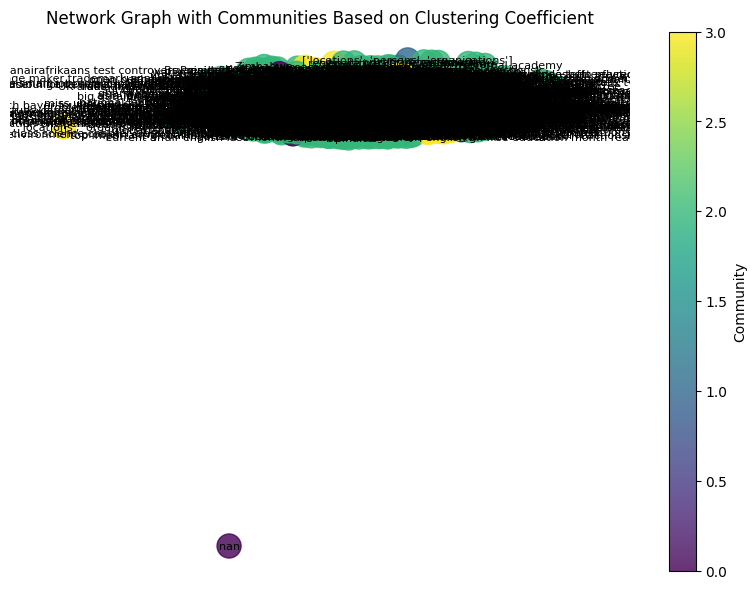

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


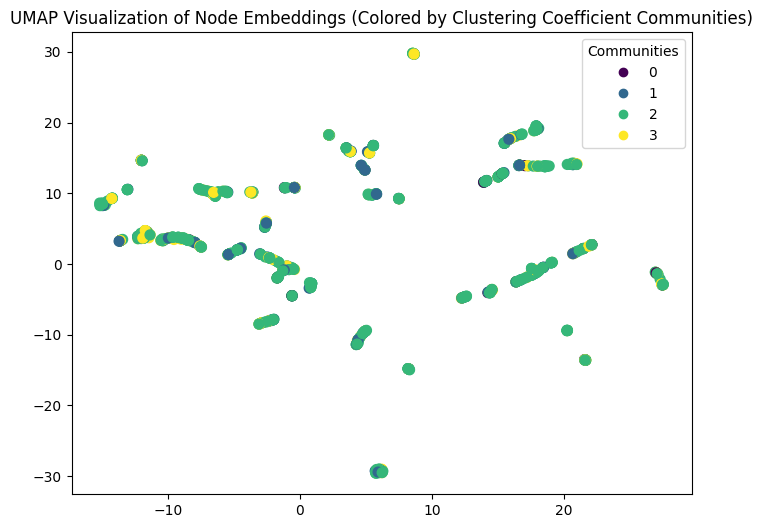

In [76]:
import ast
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import umap  # UMAP for dimensionality reduction

# Assuming your data is stored in a DataFrame named 'df_people'
# Extract relevant columns
df_subset = df_org[['topic', 'Date', 'theme', 'Head', 'Tail', 'sentiment', 'Relations', 'category', 'Views']]

# Step 1: Create a directed graph from the data
G = nx.DiGraph()

# Add nodes and edges to the graph
for _, row in df_subset.iterrows():
    topic = row['topic']
    sentiment = row['sentiment']
    relations = ast.literal_eval(row['Relations'])
    category = row['category']
    theme = row['theme']
    entities = [row['Head'], row['Tail']]
    time = row['Date']

    # Add nodes with type and time attributes
    G.add_node(topic, type='Topic', time=time)
    G.add_node(sentiment, type='Sentiment', time=time)
    G.add_node(theme, type='Theme', time=time)
    G.add_node(category, type='Category', time=time)

    for entity in entities:
        G.add_node(entity, type='Entity', time=time)

    # Add edges from Relations
    for relation in relations:
        head = relation['head']
        relation_type = relation['type']
        tail = relation['tail']
        G.add_edge(head, tail, type=relation_type, time=time)

        # Add additional edges for relationships
        G.add_edge(head, sentiment, type='Sentiment', time=time)
        G.add_edge(head, theme, type='Theme', time=time)
        G.add_edge(head, category, type='Category', time=time)
        G.add_edge(head, topic, type='Topic', time=time)

        G.add_edge(tail, sentiment, type='Sentiment', time=time)
        G.add_edge(tail, theme, type='Theme', time=time)
        G.add_edge(tail, category, type='Category', time=time)
        G.add_edge(tail, topic, type='Topic', time=time)

# Convert the directed graph to an undirected graph for community detection
G_undirected = G.to_undirected()

# Step 2: Ensure all nodes have a 'type' attribute
for node in G_undirected.nodes():
    if 'type' not in G_undirected.nodes[node]:
        G_undirected.nodes[node]['type'] = 'Unknown'  # Assign a default type if missing

# Step 3: Convert NetworkX graph to PyTorch Geometric format

# Get all unique nodes and label encode them
all_nodes = list(G_undirected.nodes)
node_encoder = LabelEncoder()
node_encoder.fit(all_nodes)
node_ids = node_encoder.transform(all_nodes)

# Create edge index (source and target nodes for each edge)
edge_index = []
for source, target in G_undirected.edges():
    edge_index.append([node_encoder.transform([source])[0], node_encoder.transform([target])[0]])

edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

# Use dummy node features (all ones)
num_nodes = len(G_undirected.nodes())
x = torch.ones((num_nodes, 1), dtype=torch.float)  # Feature matrix with a single feature

# Create the PyTorch Geometric data object
data = Data(x=x, edge_index=edge_index)

# Step 4: Define a simple Graph Convolutional Network (GCN)

class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Initialize the model
model = GCN(num_features=1, hidden_channels=16, num_classes=16)

# Step 5: Train the GCN model
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.mse_loss(out, torch.ones(out.shape))  # Dummy loss
    loss.backward()
    optimizer.step()
    return loss.item()

# Train for a few epochs
for epoch in range(100):
    loss = train()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss}')

# Step 6: Extract node embeddings from the trained model
model.eval()
with torch.no_grad():
    embeddings = model(data)

# Step 7: Compute the clustering coefficient for each node
clustering_coeff = nx.clustering(G_undirected)

# Assign the clustering coefficient as an attribute to each node
for node, coeff in clustering_coeff.items():
    G_undirected.nodes[node]['clustering_coefficient'] = coeff

# Step 8: Group nodes by their clustering coefficient (thresholding)
# Let's use simple binning to group nodes into communities based on clustering coefficient
thresholds = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]  # You can modify these thresholds
node_community = {}

for node, coeff in clustering_coeff.items():
    # Assign nodes to a community based on their clustering coefficient
    for i in range(len(thresholds) - 1):
        if thresholds[i] <= coeff < thresholds[i + 1]:
            node_community[node] = i
            break

# Step 9: Visualize the graph with a clearer layout
plt.figure(figsize=(10, 7))  # Adjusted figure size

# Use a layout algorithm for positioning nodes
pos = nx.spring_layout(G_undirected, seed=42)  # Spring layout for visualization

# Step 10: Color nodes by their community (based on clustering coefficient)
node_colors = [node_community.get(node, -1) for node in G_undirected.nodes]

# Draw the nodes with community colors
nodes = nx.draw_networkx_nodes(
    G_undirected, pos,
    node_color=node_colors, cmap='viridis',
    node_size=300, alpha=0.8
)

# Draw the edges
nx.draw_networkx_edges(
    G_undirected, pos,
    edge_color='gray', alpha=0.5
)

# Optionally draw labels (can be omitted for large graphs)
nx.draw_networkx_labels(
    G_undirected, pos,
    font_size=8, font_color='black'
)

# Add a color bar to represent communities
plt.colorbar(nodes, label='Community')  # Directly link the color bar to the drawn nodes

# Title and axis
plt.title("Network Graph with Communities Based on Clustering Coefficient")
plt.axis("off")
plt.show()

# Step 11: Save the graph with community information
nx.write_gexf(G_undirected, "community_graph_clustering_org.gexf")

# Step 12: Reduce the embeddings to 2D using UMAP for better visualization
umap_model = umap.UMAP(n_components=2)
embeddings_2d = umap_model.fit_transform(embeddings.detach().numpy())  # Convert tensor to numpy

# Visualize the 2D embeddings colored by community
plt.figure(figsize=(8, 6))  # Adjusted figure size
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=list(node_community.values()), cmap='viridis', s=50)
plt.legend(*scatter.legend_elements(), title="Communities")
plt.title("UMAP Visualization of Node Embeddings (Colored by Clustering Coefficient Communities)")
plt.show()


In [77]:
import networkx as nx

# Assuming 'G' is your graph
# Calculate clustering coefficient for each node
clustering_coefficients = nx.clustering(G)

# Sort nodes based on clustering coefficient
top_nodes_by_clustering_coefficient = sorted(clustering_coefficients, key=clustering_coefficients.get, reverse=True)[:10]

print("Top ten nodes by clustering coefficient:")
for node in top_nodes_by_clustering_coefficient:
    print(f"Node: {node}")


Top ten nodes by clustering coefficient:
Node: viewsi reactionsk
Node: academic science
Node: accor group
Node: jayshree pandiya
Node: jayshree pandiya reaction
Node: television
Node: channel
Node: ind v au st test
Node: india v australia st test
Node: un general assembly


Epoch 0, Loss: 0.9057345986366272
Epoch 10, Loss: 0.24226999282836914
Epoch 20, Loss: 0.05098079890012741
Epoch 30, Loss: 0.025703763589262962
Epoch 40, Loss: 0.021876968443393707
Epoch 50, Loss: 0.016892941668629646
Epoch 60, Loss: 0.015765398740768433
Epoch 70, Loss: 0.015211567282676697
Epoch 80, Loss: 0.014723005704581738
Epoch 90, Loss: 0.014382503926753998


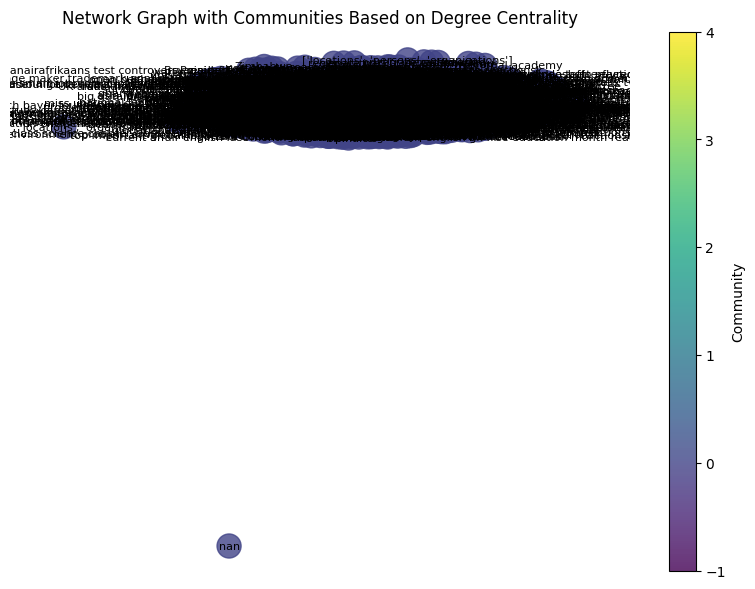

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


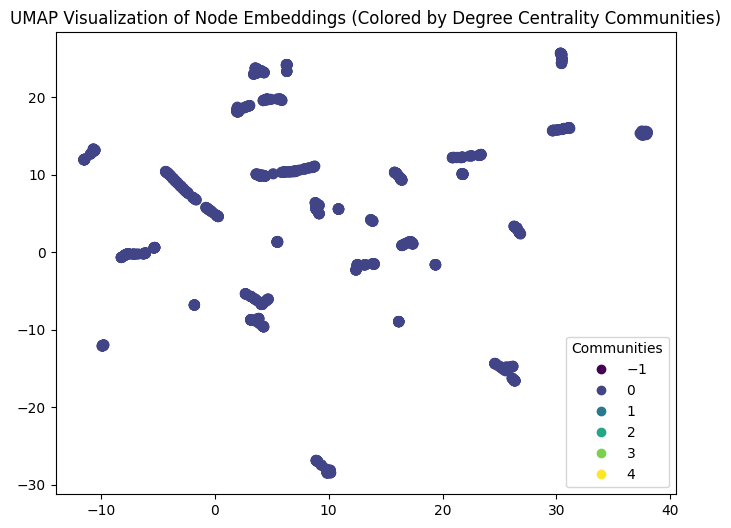

In [78]:
import ast
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import umap  # UMAP for dimensionality reduction

# Assuming your data is stored in a DataFrame named 'df_people'
# Extract relevant columns
df_subset = df_org[['topic', 'Date', 'theme', 'Head', 'Tail', 'sentiment', 'Relations', 'category', 'Views']]

# Step 1: Create a directed graph from the data
G = nx.DiGraph()

# Add nodes and edges to the graph
for _, row in df_subset.iterrows():
    topic = row['topic']
    sentiment = row['sentiment']
    relations = ast.literal_eval(row['Relations'])
    category = row['category']
    theme = row['theme']
    entities = [row['Head'], row['Tail']]
    time = row['Date']

    # Add nodes with type and time attributes
    G.add_node(topic, type='Topic', time=time)
    G.add_node(sentiment, type='Sentiment', time=time)
    G.add_node(theme, type='Theme', time=time)
    G.add_node(category, type='Category', time=time)

    for entity in entities:
        G.add_node(entity, type='Entity', time=time)

    # Add edges from Relations
    for relation in relations:
        head = relation['head']
        relation_type = relation['type']
        tail = relation['tail']
        G.add_edge(head, tail, type=relation_type, time=time)

        # Add additional edges for relationships
        G.add_edge(head, sentiment, type='Sentiment', time=time)
        G.add_edge(head, theme, type='Theme', time=time)
        G.add_edge(head, category, type='Category', time=time)
        G.add_edge(head, topic, type='Topic', time=time)

        G.add_edge(tail, sentiment, type='Sentiment', time=time)
        G.add_edge(tail, theme, type='Theme', time=time)
        G.add_edge(tail, category, type='Category', time=time)
        G.add_edge(tail, topic, type='Topic', time=time)

# Convert the directed graph to an undirected graph for community detection
G_undirected = G.to_undirected()

# Step 2: Ensure all nodes have a 'type' attribute
for node in G_undirected.nodes():
    if 'type' not in G_undirected.nodes[node]:
        G_undirected.nodes[node]['type'] = 'Unknown'  # Assign a default type if missing

# Step 3: Convert NetworkX graph to PyTorch Geometric format

# Get all unique nodes and label encode them
all_nodes = list(G_undirected.nodes)
node_encoder = LabelEncoder()
node_encoder.fit(all_nodes)
node_ids = node_encoder.transform(all_nodes)

# Create edge index (source and target nodes for each edge)
edge_index = []
for source, target in G_undirected.edges():
    edge_index.append([node_encoder.transform([source])[0], node_encoder.transform([target])[0]])

edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

# Use dummy node features (all ones)
num_nodes = len(G_undirected.nodes())
x = torch.ones((num_nodes, 1), dtype=torch.float)  # Feature matrix with a single feature

# Create the PyTorch Geometric data object
data = Data(x=x, edge_index=edge_index)

# Step 4: Define a simple Graph Convolutional Network (GCN)

class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Initialize the model
model = GCN(num_features=1, hidden_channels=16, num_classes=16)

# Step 5: Train the GCN model
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.mse_loss(out, torch.ones(out.shape))  # Dummy loss
    loss.backward()
    optimizer.step()
    return loss.item()

# Train for a few epochs
for epoch in range(100):
    loss = train()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss}')

# Step 6: Extract node embeddings from the trained model
model.eval()
with torch.no_grad():
    embeddings = model(data)

# Step 7: Compute the degree centrality for each node
degree_centrality = nx.degree_centrality(G_undirected)

# Assign the degree centrality as an attribute to each node
for node, degree in degree_centrality.items():
    G_undirected.nodes[node]['degree_centrality'] = degree

# Step 8: Group nodes by their degree centrality (thresholding)
# Let's use simple binning to group nodes into communities based on degree centrality
thresholds = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]  # You can modify these thresholds
node_community = {}

for node, degree in degree_centrality.items():
    # Assign nodes to a community based on their degree centrality
    for i in range(len(thresholds) - 1):
        if thresholds[i] <= degree < thresholds[i + 1]:
            node_community[node] = i
            break

# Ensure node_community matches the number of nodes in embeddings
community_values = [node_community.get(node, -1) for node in all_nodes]

# Step 9: Visualize the graph with a clearer layout
plt.figure(figsize=(10, 7))  # Adjusted figure size

# Use a layout algorithm for positioning nodes
pos = nx.spring_layout(G_undirected, seed=42)  # Spring layout for visualization

# Step 10: Color nodes by their community (based on degree centrality)
node_colors = [node_community.get(node, -1) for node in G_undirected.nodes]

# Draw the nodes with community colors
nodes = nx.draw_networkx_nodes(
    G_undirected, pos,
    node_color=node_colors, cmap='viridis',
    node_size=300, alpha=0.8
)

# Draw the edges
nx.draw_networkx_edges(
    G_undirected, pos,
    edge_color='gray', alpha=0.5
)

# Optionally draw labels (can be omitted for large graphs)
nx.draw_networkx_labels(
    G_undirected, pos,
    font_size=8, font_color='black'
)

# Add a color bar to represent communities
plt.colorbar(nodes, label='Community')  # Directly link the color bar to the drawn nodes

# Title and axis
plt.title("Network Graph with Communities Based on Degree Centrality")
plt.axis("off")
plt.show()

# Step 11: Save the graph with community information
nx.write_gexf(G_undirected, "community_graph_degree_org.gexf")

# Step 12: Reduce the embeddings to 2D using UMAP for better visualization
umap_model = umap.UMAP(n_components=2)
embeddings_2d = umap_model.fit_transform(embeddings.detach().numpy())  # Convert tensor to numpy

# Visualize the 2D embeddings colored by community
plt.figure(figsize=(8, 6))  # Adjusted figure size
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=community_values, cmap='viridis', s=50)
plt.legend(*scatter.legend_elements(), title="Communities")
plt.title("UMAP Visualization of Node Embeddings (Colored by Degree Centrality Communities)")
plt.show()


In [79]:
import networkx as nx

# Assuming 'G' is your graph
# Calculate degree for each node
node_degrees = dict(G.degree())

# Sort nodes based on degree
top_nodes_by_degree = sorted(node_degrees, key=node_degrees.get, reverse=True)[:10]

print("Top ten nodes by degree:")
for node in top_nodes_by_degree:
    print(f"Node: {node}, Degree: {node_degrees[node]}")


Top ten nodes by degree:
Node: neutral, Degree: 841
Node: ['organisations'], Degree: 760
Node: others, Degree: 541
Node: science exam questions and reactions, Degree: 460
Node: poverty, Degree: 323
Node: health, Degree: 239
Node: employment, Degree: 223
Node: education, Degree: 216
Node: ['persons', 'organisations'], Degree: 206
Node: hacking for business, Degree: 157


Influence attribute

Epoch 0, Loss: 1.0650495290756226
Epoch 10, Loss: 0.21990825235843658
Epoch 20, Loss: 0.04997524619102478
Epoch 30, Loss: 0.028463996946811676
Epoch 40, Loss: 0.019459204748272896
Epoch 50, Loss: 0.017311712726950645
Epoch 60, Loss: 0.01564045064151287
Epoch 70, Loss: 0.014839783310890198
Epoch 80, Loss: 0.014339644461870193
Epoch 90, Loss: 0.013958055526018143


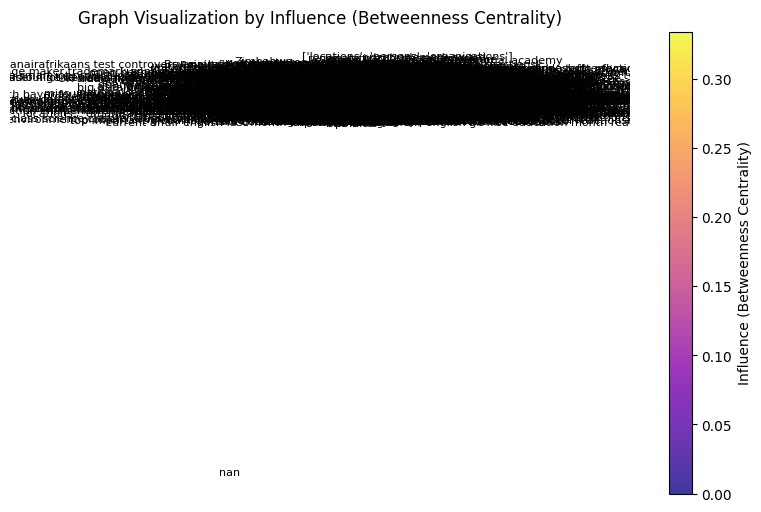

In [80]:
import ast
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Assuming your data is stored in a DataFrame named 'df_people'
# Extract relevant columns
df_subset = df_org[['topic', 'Date', 'theme', 'Head', 'Tail', 'sentiment', 'Relations', 'category', 'Views']]

# Step 1: Create a directed graph from the data
G = nx.DiGraph()

# Add nodes and edges to the graph
for _, row in df_subset.iterrows():
    topic = row['topic']
    sentiment = row['sentiment']
    relations = ast.literal_eval(row['Relations'])
    category = row['category']
    theme = row['theme']
    entities = [row['Head'], row['Tail']]
    time = row['Date']

    # Add nodes with type and time attributes
    G.add_node(topic, type='Topic', time=time)
    G.add_node(sentiment, type='Sentiment', time=time)
    G.add_node(theme, type='Theme', time=time)
    G.add_node(category, type='Category', time=time)

    for entity in entities:
        G.add_node(entity, type='Entity', time=time)

    # Add edges from Relations
    for relation in relations:
        head = relation['head']
        relation_type = relation['type']
        tail = relation['tail']
        G.add_edge(head, tail, type=relation_type, time=time)

        # Add additional edges for relationships
        G.add_edge(head, sentiment, type='Sentiment', time=time)
        G.add_edge(head, theme, type='Theme', time=time)
        G.add_edge(head, category, type='Category', time=time)
        G.add_edge(head, topic, type='Topic', time=time)

        G.add_edge(tail, sentiment, type='Sentiment', time=time)
        G.add_edge(tail, theme, type='Theme', time=time)
        G.add_edge(tail, category, type='Category', time=time)
        G.add_edge(tail, topic, type='Topic', time=time)

# Convert the directed graph to an undirected graph for influence analysis
G_undirected = G.to_undirected()

# Step 2: Ensure all nodes have a 'type' attribute
for node in G_undirected.nodes():
    if 'type' not in G_undirected.nodes[node]:
        G_undirected.nodes[node]['type'] = 'Unknown'  # Assign a default type if missing

# Step 3: Convert NetworkX graph to PyTorch Geometric format
# Get all unique nodes and label encode them
all_nodes = list(G_undirected.nodes)
node_encoder = LabelEncoder()
node_encoder.fit(all_nodes)
node_ids = node_encoder.transform(all_nodes)

# Create edge index (source and target nodes for each edge)
edge_index = []
for source, target in G_undirected.edges():
    edge_index.append([node_encoder.transform([source])[0], node_encoder.transform([target])[0]])

edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

# Use dummy node features (all ones)
num_nodes = len(G_undirected.nodes())
x = torch.ones((num_nodes, 1), dtype=torch.float)  # Feature matrix with a single feature

# Create the PyTorch Geometric data object
data = Data(x=x, edge_index=edge_index)

# Step 4: Define a simple Graph Convolutional Network (GCN)
class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Initialize the model
model = GCN(num_features=1, hidden_channels=16, num_classes=16)

# Step 5: Train the GCN model
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.mse_loss(out, torch.ones(out.shape))  # Dummy loss
    loss.backward()
    optimizer.step()
    return loss.item()

# Train for a few epochs
for epoch in range(100):
    loss = train()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss}')

# Step 6: Extract node embeddings from the trained model
model.eval()
with torch.no_grad():
    embeddings = model(data).numpy()

# Step 7: Analyze influence using betweenness centrality
betweenness_centrality = nx.betweenness_centrality(G_undirected)

# Assign the betweenness centrality as an attribute to each node
nx.set_node_attributes(G_undirected, betweenness_centrality, "influence")

# Assign embeddings to the nodes
embedding_as_string = {node: ','.join(map(str, embedding)) for node, embedding in zip(G_undirected.nodes, embeddings)}
nx.set_node_attributes(G_undirected, embedding_as_string, "embedding")

# Step 8: Save the Graph with Embeddings and Influence
nx.write_gexf(G_undirected, "influence_graph_with_embeddings_org.gexf")

# Step 9: Visualize the Graph by Influence
plt.figure(figsize=(10, 6))

# Use a layout algorithm for positioning nodes
pos = nx.spring_layout(G_undirected, seed=42)

# Scale node sizes by betweenness centrality
node_sizes = [5000 * betweenness_centrality[node] for node in G_undirected.nodes()]

# Draw the graph
nodes = nx.draw_networkx_nodes(
    G_undirected, pos,
    node_size=node_sizes,
    node_color=list(betweenness_centrality.values()),
    cmap='plasma', alpha=0.8
)
nx.draw_networkx_edges(G_undirected, pos, alpha=0.5, edge_color='gray')
nx.draw_networkx_labels(G_undirected, pos, font_size=8, font_color='black')

# Add a color bar for influence
plt.colorbar(nodes, label="Influence (Betweenness Centrality)")
plt.title("Graph Visualization by Influence (Betweenness Centrality)")
plt.axis("off")
plt.show()


In [81]:
import networkx as nx

# Assuming 'G' is your graph
# Calculate betweenness centrality for each node
betweenness_centralities = nx.betweenness_centrality(G)

# Sort nodes based on betweenness centrality
top_nodes_by_betweenness_centrality = sorted(betweenness_centralities.items(), key=lambda x: x[1], reverse=True)[:10]

print("Top ten nodes by betweenness centrality:")
for node, centrality in top_nodes_by_betweenness_centrality:
    print(f"Node: {node}")


Top ten nodes by betweenness centrality:
Node: education
Node: poverty
Node: university
Node: india
Node: brazil
Node: america
Node: nigeria
Node: rugby
Node: reactionsk
Node: organization


Epoch 0, Loss: 0.9636610150337219
Epoch 10, Loss: 0.27184149622917175
Epoch 20, Loss: 0.0632205456495285
Epoch 30, Loss: 0.02352667599916458
Epoch 40, Loss: 0.021664097905158997
Epoch 50, Loss: 0.01773778349161148
Epoch 60, Loss: 0.0158538818359375
Epoch 70, Loss: 0.015173918567597866
Epoch 80, Loss: 0.014547384344041348
Epoch 90, Loss: 0.014086613431572914


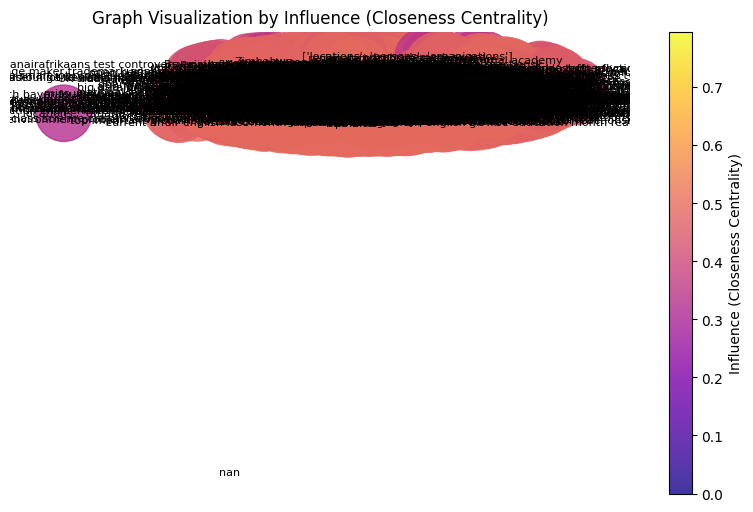

In [82]:
import ast
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Assuming your data is stored in a DataFrame named 'df_people'
# Extract relevant columns
df_subset = df_org[['topic', 'Date', 'theme', 'Head', 'Tail', 'sentiment', 'Relations', 'category', 'Views']]

# Step 1: Create a directed graph from the data
G = nx.DiGraph()

# Add nodes and edges to the graph
for _, row in df_subset.iterrows():
    topic = row['topic']
    sentiment = row['sentiment']
    relations = ast.literal_eval(row['Relations'])
    category = row['category']
    theme = row['theme']
    entities = [row['Head'], row['Tail']]
    time = row['Date']

    # Add nodes with type and time attributes
    G.add_node(topic, type='Topic', time=time)
    G.add_node(sentiment, type='Sentiment', time=time)
    G.add_node(theme, type='Theme', time=time)
    G.add_node(category, type='Category', time=time)

    for entity in entities:
        G.add_node(entity, type='Entity', time=time)

    # Add edges from Relations
    for relation in relations:
        head = relation['head']
        relation_type = relation['type']
        tail = relation['tail']
        G.add_edge(head, tail, type=relation_type, time=time)

        # Add additional edges for relationships
        G.add_edge(head, sentiment, type='Sentiment', time=time)
        G.add_edge(head, theme, type='Theme', time=time)
        G.add_edge(head, category, type='Category', time=time)
        G.add_edge(head, topic, type='Topic', time=time)

        G.add_edge(tail, sentiment, type='Sentiment', time=time)
        G.add_edge(tail, theme, type='Theme', time=time)
        G.add_edge(tail, category, type='Category', time=time)
        G.add_edge(tail, topic, type='Topic', time=time)

# Convert the directed graph to an undirected graph for influence analysis
G_undirected = G.to_undirected()

# Step 2: Ensure all nodes have a 'type' attribute
for node in G_undirected.nodes():
    if 'type' not in G_undirected.nodes[node]:
        G_undirected.nodes[node]['type'] = 'Unknown'  # Assign a default type if missing

# Step 3: Convert NetworkX graph to PyTorch Geometric format
# Get all unique nodes and label encode them
all_nodes = list(G_undirected.nodes)
node_encoder = LabelEncoder()
node_encoder.fit(all_nodes)
node_ids = node_encoder.transform(all_nodes)

# Create edge index (source and target nodes for each edge)
edge_index = []
for source, target in G_undirected.edges():
    edge_index.append([node_encoder.transform([source])[0], node_encoder.transform([target])[0]])

edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

# Use dummy node features (all ones)
num_nodes = len(G_undirected.nodes())
x = torch.ones((num_nodes, 1), dtype=torch.float)  # Feature matrix with a single feature

# Create the PyTorch Geometric data object
data = Data(x=x, edge_index=edge_index)

# Step 4: Define a simple Graph Convolutional Network (GCN)
class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Initialize the model
model = GCN(num_features=1, hidden_channels=16, num_classes=16)

# Step 5: Train the GCN model
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.mse_loss(out, torch.ones(out.shape))  # Dummy loss
    loss.backward()
    optimizer.step()
    return loss.item()

# Train for a few epochs
for epoch in range(100):
    loss = train()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss}')

# Step 6: Extract node embeddings from the trained model
model.eval()
with torch.no_grad():
    embeddings = model(data).numpy()

# Step 7: Analyze influence using closeness centrality
closeness_centrality = nx.closeness_centrality(G_undirected)

# Assign the closeness centrality as an attribute to each node
nx.set_node_attributes(G_undirected, closeness_centrality, "influence")

# Assign embeddings to the nodes
embedding_as_string = {node: ','.join(map(str, embedding)) for node, embedding in zip(G_undirected.nodes, embeddings)}
nx.set_node_attributes(G_undirected, embedding_as_string, "embedding")

# Step 8: Save the Graph with Embeddings and Influence
nx.write_gexf(G_undirected, "influence_graph_with_embeddings_closeness_org.gexf")

# Step 9: Visualize the Graph by Influence
plt.figure(figsize=(10, 6))

# Use a layout algorithm for positioning nodes
pos = nx.spring_layout(G_undirected, seed=42)

# Scale node sizes by closeness centrality
node_sizes = [5000 * closeness_centrality[node] for node in G_undirected.nodes()]

# Draw the graph
nodes = nx.draw_networkx_nodes(
    G_undirected, pos,
    node_size=node_sizes,
    node_color=list(closeness_centrality.values()),
    cmap='plasma', alpha=0.8
)
nx.draw_networkx_edges(G_undirected, pos, alpha=0.5, edge_color='gray')
nx.draw_networkx_labels(G_undirected, pos, font_size=8, font_color='black')

# Add a color bar for influence
plt.colorbar(nodes, label="Influence (Closeness Centrality)")
plt.title("Graph Visualization by Influence (Closeness Centrality)")
plt.axis("off")
plt.show()


In [83]:
import networkx as nx

# Assuming 'G' is your graph
# Calculate closeness centrality for each node
closeness_centralities = nx.closeness_centrality(G)

# Sort nodes based on closeness centrality
top_nodes_by_closeness_centrality = sorted(closeness_centralities.items(), key=lambda x: x[1], reverse=True)[:10]

print("Top ten nodes by closeness centrality:")
for node, centrality in top_nodes_by_closeness_centrality:
    print(f"Node: {node}")


Top ten nodes by closeness centrality:
Node: neutral
Node: ['organisations']
Node: others
Node: science exam questions and reactions
Node: poverty
Node: employment
Node: ['persons', 'organisations']
Node: health
Node: negative
Node: ['locations', 'organisations']


Epoch 0, Loss: 1.3983471393585205
Epoch 10, Loss: 0.3539067208766937
Epoch 20, Loss: 0.06692809611558914
Epoch 30, Loss: 0.02424260415136814
Epoch 40, Loss: 0.023549625650048256
Epoch 50, Loss: 0.017722230404615402
Epoch 60, Loss: 0.015443599782884121
Epoch 70, Loss: 0.015061089769005775
Epoch 80, Loss: 0.01421427447348833
Epoch 90, Loss: 0.013723062351346016


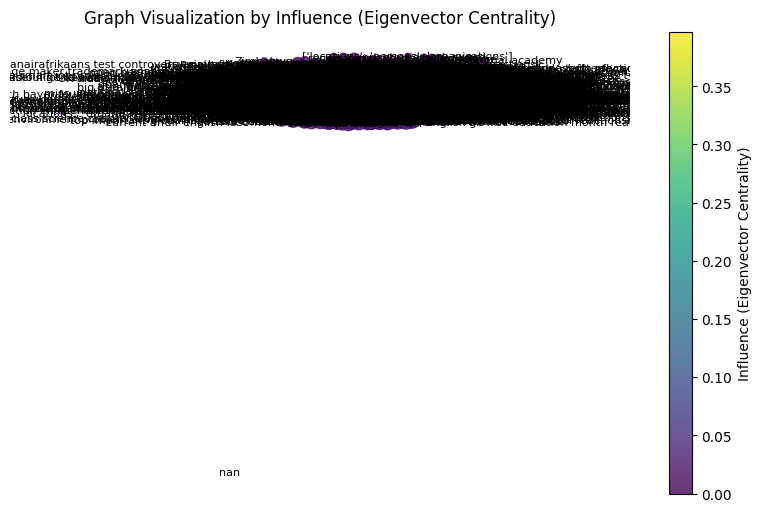

In [84]:
import ast
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Assuming your data is stored in a DataFrame named 'df_people'
# Extract relevant columns
df_subset = df_org[['topic', 'Date', 'theme', 'Head', 'Tail', 'sentiment', 'Relations', 'category', 'Views']]

# Step 1: Create a directed graph from the data
G = nx.DiGraph()

# Add nodes and edges to the graph
for _, row in df_subset.iterrows():
    topic = row['topic']
    sentiment = row['sentiment']
    relations = ast.literal_eval(row['Relations'])
    category = row['category']
    theme = row['theme']
    entities = [row['Head'], row['Tail']]
    time = row['Date']

    # Add nodes with type and time attributes
    G.add_node(topic, type='Topic', time=time)
    G.add_node(sentiment, type='Sentiment', time=time)
    G.add_node(theme, type='Theme', time=time)
    G.add_node(category, type='Category', time=time)

    for entity in entities:
        G.add_node(entity, type='Entity', time=time)

    # Add edges from Relations
    for relation in relations:
        head = relation['head']
        relation_type = relation['type']
        tail = relation['tail']
        G.add_edge(head, tail, type=relation_type, time=time)

        # Add additional edges for relationships
        G.add_edge(head, sentiment, type='Sentiment', time=time)
        G.add_edge(head, theme, type='Theme', time=time)
        G.add_edge(head, category, type='Category', time=time)
        G.add_edge(head, topic, type='Topic', time=time)

        G.add_edge(tail, sentiment, type='Sentiment', time=time)
        G.add_edge(tail, theme, type='Theme', time=time)
        G.add_edge(tail, category, type='Category', time=time)
        G.add_edge(tail, topic, type='Topic', time=time)

# Convert the directed graph to an undirected graph for influence analysis
G_undirected = G.to_undirected()

# Step 2: Ensure all nodes have a 'type' attribute
for node in G_undirected.nodes():
    if 'type' not in G_undirected.nodes[node]:
        G_undirected.nodes[node]['type'] = 'Unknown'  # Assign a default type if missing

# Step 3: Convert NetworkX graph to PyTorch Geometric format
# Get all unique nodes and label encode them
all_nodes = list(G_undirected.nodes)
node_encoder = LabelEncoder()
node_encoder.fit(all_nodes)
node_ids = node_encoder.transform(all_nodes)

# Create edge index (source and target nodes for each edge)
edge_index = []
for source, target in G_undirected.edges():
    edge_index.append([node_encoder.transform([source])[0], node_encoder.transform([target])[0]])

edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

# Use dummy node features (all ones)
num_nodes = len(G_undirected.nodes())
x = torch.ones((num_nodes, 1), dtype=torch.float)  # Feature matrix with a single feature

# Create the PyTorch Geometric data object
data = Data(x=x, edge_index=edge_index)

# Step 4: Define a simple Graph Convolutional Network (GCN)
class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Initialize the model
model = GCN(num_features=1, hidden_channels=16, num_classes=16)

# Step 5: Train the GCN model
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.mse_loss(out, torch.ones(out.shape))  # Dummy loss
    loss.backward()
    optimizer.step()
    return loss.item()

# Train for a few epochs
for epoch in range(100):
    loss = train()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss}')

# Step 6: Extract node embeddings from the trained model
model.eval()
with torch.no_grad():
    embeddings = model(data).numpy()

# Step 7: Analyze influence using eigenvector centrality
eigenvector_centrality = nx.eigenvector_centrality(G_undirected, max_iter=1000)

# Assign the eigenvector centrality as an attribute to each node
nx.set_node_attributes(G_undirected, eigenvector_centrality, "influence")

# Assign embeddings to the nodes
embedding_as_string = {node: ','.join(map(str, embedding)) for node, embedding in zip(G_undirected.nodes, embeddings)}
nx.set_node_attributes(G_undirected, embedding_as_string, "embedding")

# Step 8: Save the Graph with Embeddings and Influence
nx.write_gexf(G_undirected, "influence_graph_with_embeddings_eigenvector_org.gexf")

# Step 9: Visualize the Graph by Influence
plt.figure(figsize=(10, 6))

# Use a layout algorithm for positioning nodes
pos = nx.spring_layout(G_undirected, seed=42)

# Scale node sizes by eigenvector centrality
node_sizes = [5000 * eigenvector_centrality[node] for node in G_undirected.nodes()]

# Draw the graph
nodes = nx.draw_networkx_nodes(
    G_undirected, pos,
    node_size=node_sizes,
    node_color=list(eigenvector_centrality.values()),
    cmap='viridis', alpha=0.8
)
nx.draw_networkx_edges(G_undirected, pos, alpha=0.5, edge_color='gray')
nx.draw_networkx_labels(G_undirected, pos, font_size=8, font_color='black')

# Add a color bar for influence
plt.colorbar(nodes, label="Influence (Eigenvector Centrality)")
plt.title("Graph Visualization by Influence (Eigenvector Centrality)")
plt.axis("off")
plt.show()


In [85]:
# import networkx as nx

# # Assuming 'G' is your graph
# # Calculate eigenvector centrality for each node
# eigenvector_centralities = nx.eigenvector_centrality(G)

# # Sort nodes based on eigenvector centrality
# top_nodes_by_eigenvector_centrality = sorted(eigenvector_centralities.items(), key=lambda x: x[1], reverse=True)[:10]

# print("Top ten nodes by eigenvector centrality:")
# for node, centrality in top_nodes_by_eigenvector_centrality:
#     print(f"Node: {node}")


Link Analysis

Epoch 0, Loss: 1.3308532238006592
Epoch 10, Loss: 0.3717105984687805
Epoch 20, Loss: 0.10163120925426483
Epoch 30, Loss: 0.031673531979322433
Epoch 40, Loss: 0.02027389220893383
Epoch 50, Loss: 0.016760364174842834
Epoch 60, Loss: 0.014619862660765648
Epoch 70, Loss: 0.01409368496388197
Epoch 80, Loss: 0.013423681259155273
Epoch 90, Loss: 0.013010593131184578


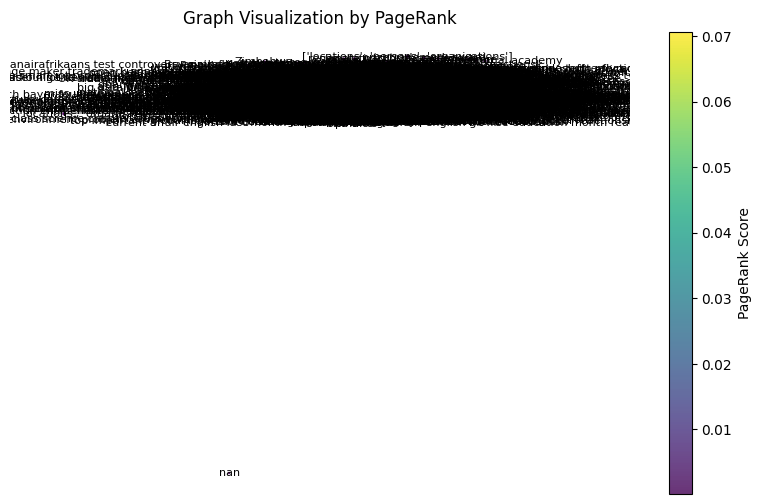

In [86]:
import ast
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Assuming your data is stored in a DataFrame named 'df_people'
# Extract relevant columns
df_subset = df_org[['topic', 'Date', 'theme', 'Head', 'Tail', 'sentiment', 'Relations', 'category', 'Views']]

# Step 1: Create a directed graph from the data
G = nx.DiGraph()

# Add nodes and edges to the graph
for _, row in df_subset.iterrows():
    topic = row['topic']
    sentiment = row['sentiment']
    relations = ast.literal_eval(row['Relations'])
    category = row['category']
    theme = row['theme']
    entities = [row['Head'], row['Tail']]
    time = row['Date']

    # Add nodes with type and time attributes
    G.add_node(topic, type='Topic', time=time)
    G.add_node(sentiment, type='Sentiment', time=time)
    G.add_node(theme, type='Theme', time=time)
    G.add_node(category, type='Category', time=time)

    for entity in entities:
        G.add_node(entity, type='Entity', time=time)

    # Add edges from Relations
    for relation in relations:
        head = relation['head']
        relation_type = relation['type']
        tail = relation['tail']
        G.add_edge(head, tail, type=relation_type, time=time)

        # Add additional edges for relationships
        G.add_edge(head, sentiment, type='Sentiment', time=time)
        G.add_edge(head, theme, type='Theme', time=time)
        G.add_edge(head, category, type='Category', time=time)
        G.add_edge(head, topic, type='Topic', time=time)

        G.add_edge(tail, sentiment, type='Sentiment', time=time)
        G.add_edge(tail, theme, type='Theme', time=time)
        G.add_edge(tail, category, type='Category', time=time)
        G.add_edge(tail, topic, type='Topic', time=time)

# Convert the directed graph to an undirected graph
G_undirected = G.to_undirected()

# Step 2: Ensure all nodes have a 'type' attribute
for node in G_undirected.nodes():
    if 'type' not in G_undirected.nodes[node]:
        G_undirected.nodes[node]['type'] = 'Unknown'  # Assign a default type if missing

# Step 3: Convert NetworkX graph to PyTorch Geometric format
# Get all unique nodes and label encode them
all_nodes = list(G_undirected.nodes)
node_encoder = LabelEncoder()
node_encoder.fit(all_nodes)
node_ids = node_encoder.transform(all_nodes)

# Create edge index (source and target nodes for each edge)
edge_index = []
for source, target in G_undirected.edges():
    edge_index.append([node_encoder.transform([source])[0], node_encoder.transform([target])[0]])

edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

# Use dummy node features (all ones)
num_nodes = len(G_undirected.nodes())
x = torch.ones((num_nodes, 1), dtype=torch.float)  # Feature matrix with a single feature

# Create the PyTorch Geometric data object
data = Data(x=x, edge_index=edge_index)

# Step 4: Define a simple Graph Convolutional Network (GCN)
class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Initialize the model
model = GCN(num_features=1, hidden_channels=16, num_classes=16)

# Step 5: Train the GCN model
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.mse_loss(out, torch.ones(out.shape))  # Dummy loss
    loss.backward()
    optimizer.step()
    return loss.item()

# Train for a few epochs
for epoch in range(100):
    loss = train()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss}')

# Step 6: Extract node embeddings from the trained model
model.eval()
with torch.no_grad():
    embeddings = model(data).numpy()

# Step 7: Perform link analysis using PageRank
pagerank_scores = nx.pagerank(G_undirected)

# Assign the PageRank scores as an attribute to each node
nx.set_node_attributes(G_undirected, pagerank_scores, "pagerank")

# Assign embeddings to the nodes
embedding_as_string = {node: ','.join(map(str, embedding)) for node, embedding in zip(G_undirected.nodes, embeddings)}
nx.set_node_attributes(G_undirected, embedding_as_string, "embedding")

# Step 8: Save the Graph with PageRank and Embeddings
nx.write_gexf(G_undirected, "pagerank_graph_with_embeddings_org.gexf")

# Step 9: Visualize the Graph by PageRank
plt.figure(figsize=(10, 6))

# Use a layout algorithm for positioning nodes
pos = nx.spring_layout(G_undirected, seed=42)

# Scale node sizes by PageRank scores
node_sizes = [5000 * pagerank_scores[node] for node in G_undirected.nodes()]

# Draw the graph
nodes = nx.draw_networkx_nodes(
    G_undirected, pos,
    node_size=node_sizes,
    node_color=list(pagerank_scores.values()),
    cmap='viridis', alpha=0.8
)
nx.draw_networkx_edges(G_undirected, pos, alpha=0.5, edge_color='gray')
nx.draw_networkx_labels(G_undirected, pos, font_size=8, font_color='black')

# Add a color bar for PageRank scores
plt.colorbar(nodes, label="PageRank Score")
plt.title("Graph Visualization by PageRank")
plt.axis("off")
plt.show()


In [87]:
import networkx as nx

# Assuming 'G' is your graph
# Calculate PageRank for each node
pageranks = nx.pagerank(G)

# Sort nodes based on PageRank
top_nodes_by_pagerank = sorted(pageranks.items(), key=lambda x: x[1], reverse=True)[:10]

print("Top ten nodes by PageRank:")
for node, rank in top_nodes_by_pagerank:
    print(f"Node: {node}")


Top ten nodes by PageRank:
Node: neutral
Node: ['organisations']
Node: others
Node: science exam questions and reactions
Node: poverty
Node: employment
Node: ['persons', 'organisations']
Node: health
Node: education
Node: ['locations', 'organisations']


Epoch 0, Loss: 1.0600287914276123
Epoch 10, Loss: 0.22146430611610413
Epoch 20, Loss: 0.04528682678937912
Epoch 30, Loss: 0.02876359596848488
Epoch 40, Loss: 0.019937027245759964
Epoch 50, Loss: 0.017569025978446007
Epoch 60, Loss: 0.01611277088522911
Epoch 70, Loss: 0.015184511430561543
Epoch 80, Loss: 0.01480949204415083
Epoch 90, Loss: 0.0143742049112916


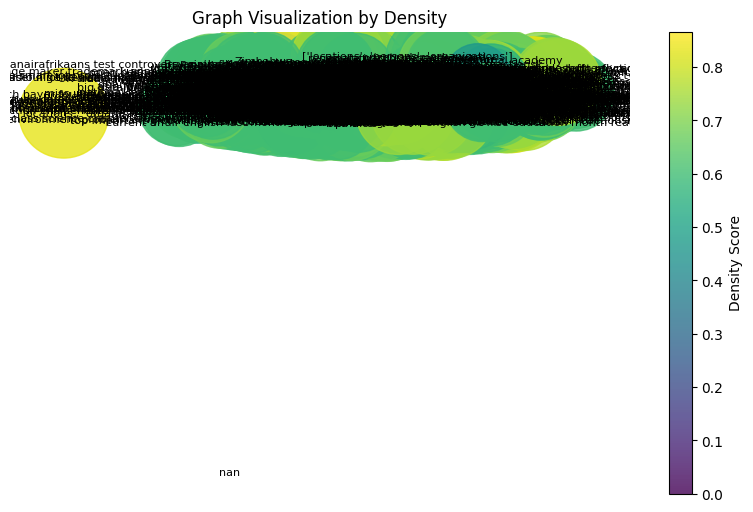

In [88]:
import ast
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Assuming your data is stored in a DataFrame named 'df_people'
# Extract relevant columns
df_subset = df_org[['topic', 'Date', 'theme', 'Head', 'Tail', 'sentiment', 'Relations', 'category', 'Views']]

# Step 1: Create a directed graph from the data
G = nx.DiGraph()

# Add nodes and edges to the graph
for _, row in df_subset.iterrows():
    topic = row['topic']
    sentiment = row['sentiment']
    relations = ast.literal_eval(row['Relations'])
    category = row['category']
    theme = row['theme']
    entities = [row['Head'], row['Tail']]
    time = row['Date']

    # Add nodes with type and time attributes
    G.add_node(topic, type='Topic', time=time)
    G.add_node(sentiment, type='Sentiment', time=time)
    G.add_node(theme, type='Theme', time=time)
    G.add_node(category, type='Category', time=time)

    for entity in entities:
        G.add_node(entity, type='Entity', time=time)

    # Add edges from Relations
    for relation in relations:
        head = relation['head']
        relation_type = relation['type']
        tail = relation['tail']
        G.add_edge(head, tail, type=relation_type, time=time)

        # Add additional edges for relationships
        G.add_edge(head, sentiment, type='Sentiment', time=time)
        G.add_edge(head, theme, type='Theme', time=time)
        G.add_edge(head, category, type='Category', time=time)
        G.add_edge(head, topic, type='Topic', time=time)

        G.add_edge(tail, sentiment, type='Sentiment', time=time)
        G.add_edge(tail, theme, type='Theme', time=time)
        G.add_edge(tail, category, type='Category', time=time)
        G.add_edge(tail, topic, type='Topic', time=time)

# Convert the directed graph to an undirected graph
G_undirected = G.to_undirected()

# Step 2: Ensure all nodes have a 'type' attribute
for node in G_undirected.nodes():
    if 'type' not in G_undirected.nodes[node]:
        G_undirected.nodes[node]['type'] = 'Unknown'  # Assign a default type if missing

# Step 3: Convert NetworkX graph to PyTorch Geometric format
# Get all unique nodes and label encode them
all_nodes = list(G_undirected.nodes)
node_encoder = LabelEncoder()
node_encoder.fit(all_nodes)
node_ids = node_encoder.transform(all_nodes)

# Create edge index (source and target nodes for each edge)
edge_index = []
for source, target in G_undirected.edges():
    edge_index.append([node_encoder.transform([source])[0], node_encoder.transform([target])[0]])

edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

# Use dummy node features (all ones)
num_nodes = len(G_undirected.nodes())
x = torch.ones((num_nodes, 1), dtype=torch.float)  # Feature matrix with a single feature

# Create the PyTorch Geometric data object
data = Data(x=x, edge_index=edge_index)

# Step 4: Define a simple Graph Convolutional Network (GCN)
class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Initialize the model
model = GCN(num_features=1, hidden_channels=16, num_classes=16)

# Step 5: Train the GCN model
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.mse_loss(out, torch.ones(out.shape))  # Dummy loss
    loss.backward()
    optimizer.step()
    return loss.item()

# Train for a few epochs
for epoch in range(100):
    loss = train()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss}')

# Step 6: Extract node embeddings from the trained model
model.eval()
with torch.no_grad():
    embeddings = model(data).numpy()

# Step 7: Calculate density for each node's neighborhood
density_scores = {}
for node in G_undirected.nodes:
    neighbors = list(G_undirected.neighbors(node))
    subgraph = G_undirected.subgraph(neighbors + [node])  # Include the node itself
    density_scores[node] = nx.density(subgraph)

# Assign the density scores as an attribute to each node
nx.set_node_attributes(G_undirected, density_scores, "density")

# Assign embeddings to the nodes
embedding_as_string = {node: ','.join(map(str, embedding)) for node, embedding in zip(G_undirected.nodes, embeddings)}
nx.set_node_attributes(G_undirected, embedding_as_string, "embedding")

# Step 8: Save the Graph with Density and Embeddings
nx.write_gexf(G_undirected, "density_graph_with_embeddings_org.gexf")

# Step 9: Visualize the Graph by Density
plt.figure(figsize=(10, 6))

# Use a layout algorithm for positioning nodes
pos = nx.spring_layout(G_undirected, seed=42)

# Scale node sizes by density scores
node_sizes = [5000 * density_scores[node] for node in G_undirected.nodes()]

# Draw the graph
nodes = nx.draw_networkx_nodes(
    G_undirected, pos,
    node_size=node_sizes,
    node_color=list(density_scores.values()),
    cmap='viridis', alpha=0.8
)
nx.draw_networkx_edges(G_undirected, pos, alpha=0.5, edge_color='gray')
nx.draw_networkx_labels(G_undirected, pos, font_size=8, font_color='black')

# Add a color bar for density scores
plt.colorbar(nodes, label="Density Score")
plt.title("Graph Visualization by Density")
plt.axis("off")
plt.show()


In [89]:
import networkx as nx

# Assuming 'G' is your graph
# Calculate density for each node
density = {node: nx.density(nx.ego_graph(G, node)) for node in G.nodes()}

# Sort nodes based on density
top_nodes_by_density = sorted(density.items(), key=lambda x: x[1], reverse=True)[:10]

print("Top ten nodes by density:")
for node, dens in top_nodes_by_density:
    print(f"Node: {node}")


Top ten nodes by density:
Node: viewsi reactionsk
Node: academic science
Node: accor group
Node: willis
Node: dec k viewsaccor
Node: television
Node: channel
Node: ind v au st test
Node: india v australia st test
Node: team brazil india


In [90]:
df_country

topic                       Date       theme  \
203             hacking for business                        nan      others   
204             hacking for business                        nan      others   
274           ghanaian election news                 2023-08-22  employment   
274           ghanaian election news                 2023-08-22     poverty   
275           ghanaian election news                 2023-08-22  employment   
...                              ...                        ...         ...   
66668  cricket match fails on tiktok                 2021-08-24   education   
66668  cricket match fails on tiktok                 2021-08-24    security   
66668  cricket match fails on tiktok                 2021-08-24      health   
66785                     trademarks  2019-08-09 09:21:04+00:00      others   
66787                     trademarks  2019-08-09 09:21:04+00:00      others   

                                                    Head  \
203    access finance smes seye olurotomi ugwumba center   
204    access finance smes seye olurotomi ugwumba center   
274    accra lagos road trip gone wrong official bord...   
274    accra lagos road trip gone wrong official bord...   
275    accra lagos road trip gone wrong official bord...   
...                                                  ...   
66668                     England v rugby cup rugby hour   
66668                     England v rugby cup rugby hour   
66668                     England v rugby cup rugby hour   
66785                           fifa cup fifa reactionsm   
66787                           fifa cup fifa reactionsm   

                                                    Tail sentiment  \
203                                        great nigeria   neutral   
204                                        great nigeria   neutral   
274    accra lagos road trip gone wrong official bord...  negative   
274    accra lagos road trip gone wrong official bord...  negative   
275    accra lagos road trip gone wrong official bord...  negative   
...                                                  ...       ...   
66668                                              rugby   neutral   
66668                                              rugby   neutral   
66668                                              rugby   neutral   
66785                                            germany  positive   
66787                                            germany  positive   

                                               Relations  \
203    [{'head': 'access finance smes seye olurotomi ...   
204    [{'head': 'access finance smes seye olurotomi ...   
274    [{'head': 'accra lagos road trip gone wrong of...   
274    [{'head': 'accra lagos road trip gone wrong of...   
275    [{'head': 'accra lagos road trip gone wrong of...   
...                                                  ...   
66668  [{'head': 'rugby cup', 'type': 'sport', 'tail'...   
66668  [{'head': 'rugby cup', 'type': 'sport', 'tail'...   
66668  [{'head': 'rugby cup', 'type': 'sport', 'tail'...   
66785  [{'head': 'fifa cup fifa reactionsm', 'type': ...   
66787  [{'head': 'fifa cup fifa reactionsm', 'type': ...   

                             category Views  
203    ['locations', 'organisations']   253  
204    ['locations', 'organisations']   253  
274    ['locations', 'organisations']   743  
274    ['locations', 'organisations']   743  
275    ['locations', 'organisations']   743  
...                               ...   ...  
66668                   ['locations']   500  
66668                   ['locations']   500  
66668                   ['locations']   500  
66785                   ['locations']     0  
66787                   ['locations']     0  

[732 rows x 9 columns]

Epoch 0, Loss: 1.073149561882019
Epoch 10, Loss: 0.6164801120758057
Epoch 20, Loss: 0.21478483080863953
Epoch 30, Loss: 0.08027716726064682
Epoch 40, Loss: 0.01955944299697876
Epoch 50, Loss: 0.01949230022728443
Epoch 60, Loss: 0.015372905880212784
Epoch 70, Loss: 0.013558527454733849
Epoch 80, Loss: 0.013199039734899998
Epoch 90, Loss: 0.012776150368154049


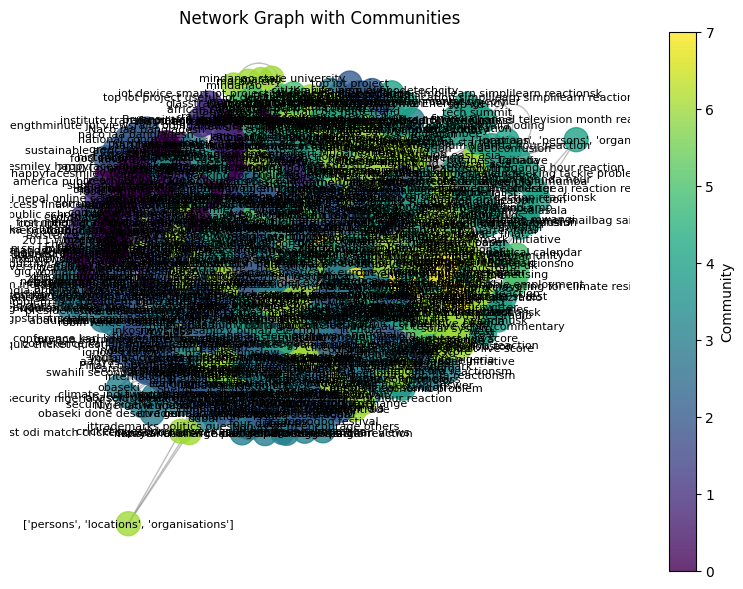

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


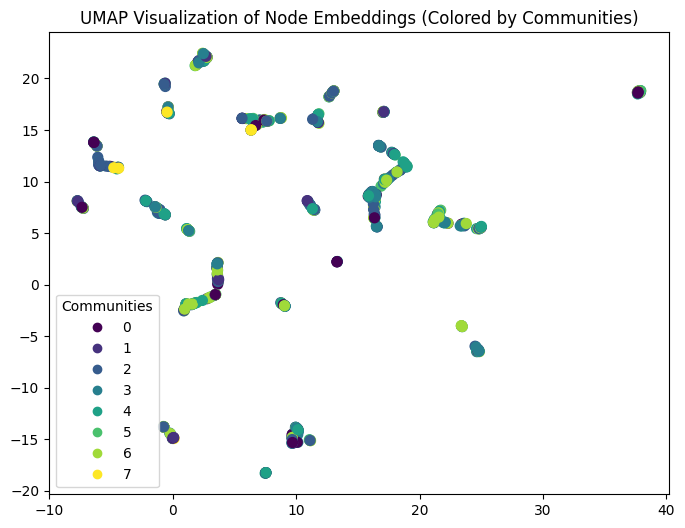

In [91]:
import ast
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import community as community_louvain  # For Louvain method
import umap  # UMAP for dimensionality reduction

# Assuming your data is stored in a DataFrame named 'df_people'
# Extract relevant columns
df_subset = df_country[['topic', 'Date', 'theme', 'Head', 'Tail', 'sentiment', 'Relations', 'category', 'Views']]

# Step 1: Create a directed graph from the data
G = nx.DiGraph()

# Add nodes and edges to the graph
for _, row in df_subset.iterrows():
    topic = row['topic']
    sentiment = row['sentiment']
    relations = ast.literal_eval(row['Relations'])
    category = row['category']
    theme = row['theme']
    entities = [row['Head'], row['Tail']]
    time = row['Date']

    # Add nodes with type and time attributes
    G.add_node(topic, type='Topic', time=time)
    G.add_node(sentiment, type='Sentiment', time=time)
    G.add_node(theme, type='Theme', time=time)
    G.add_node(category, type='Category', time=time)

    for entity in entities:
        G.add_node(entity, type='Entity', time=time)

    # Add edges from Relations
    for relation in relations:
        head = relation['head']
        relation_type = relation['type']
        tail = relation['tail']
        G.add_edge(head, tail, type=relation_type, time=time)

        # Add additional edges for relationships
        G.add_edge(head, sentiment, type='Sentiment', time=time)
        G.add_edge(head, theme, type='Theme', time=time)
        G.add_edge(head, category, type='Category', time=time)
        G.add_edge(head, topic, type='Topic', time=time)

        G.add_edge(tail, sentiment, type='Sentiment', time=time)
        G.add_edge(tail, theme, type='Theme', time=time)
        G.add_edge(tail, category, type='Category', time=time)
        G.add_edge(tail, topic, type='Topic', time=time)

# Convert the directed graph to an undirected graph for community detection
G_undirected = G.to_undirected()

# Step 2: Ensure all nodes have a 'type' attribute
for node in G_undirected.nodes():
    if 'type' not in G_undirected.nodes[node]:
        G_undirected.nodes[node]['type'] = 'Unknown'  # Assign a default type if missing

# Step 3: Convert NetworkX graph to PyTorch Geometric format

# Get all unique nodes and label encode them
all_nodes = list(G_undirected.nodes)
node_encoder = LabelEncoder()
node_encoder.fit(all_nodes)
node_ids = node_encoder.transform(all_nodes)

# Create edge index (source and target nodes for each edge)
edge_index = []
for source, target in G_undirected.edges():
    edge_index.append([node_encoder.transform([source])[0], node_encoder.transform([target])[0]])

edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

# Use dummy node features (all ones)
num_nodes = len(G_undirected.nodes())
x = torch.ones((num_nodes, 1), dtype=torch.float)  # Feature matrix with a single feature

# Create the PyTorch Geometric data object
data = Data(x=x, edge_index=edge_index)

# Step 4: Define a simple Graph Convolutional Network (GCN)

class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Initialize the model
model = GCN(num_features=1, hidden_channels=16, num_classes=16)

# Step 5: Train the GCN model
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.mse_loss(out, torch.ones(out.shape))  # Dummy loss
    loss.backward()
    optimizer.step()
    return loss.item()

# Train for a few epochs
for epoch in range(100):
    loss = train()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss}')

# Step 6: Extract node embeddings from the trained model
model.eval()
with torch.no_grad():
    embeddings = model(data)

# Step 7: Detect communities using the Louvain method
node_community = community_louvain.best_partition(G_undirected)

# Assign the community as an attribute to each node
for node, community in node_community.items():
    G_undirected.nodes[node]['community'] = community

# Step 8: Visualize the graph with a clearer layout
plt.figure(figsize=(10, 7))  # Adjusted figure size

# Use a layout algorithm for positioning nodes
pos = nx.spring_layout(G_undirected, seed=42)  # Spring layout for visualization

# Step 9: Color nodes by community
node_colors = [node_community.get(node, -1) for node in G_undirected.nodes]

# Draw the nodes with community colors
nodes = nx.draw_networkx_nodes(
    G_undirected, pos,
    node_color=node_colors, cmap='viridis',
    node_size=300, alpha=0.8
)

# Draw the edges
nx.draw_networkx_edges(
    G_undirected, pos,
    edge_color='gray', alpha=0.5
)

# Optionally draw labels (can be omitted for large graphs)
nx.draw_networkx_labels(
    G_undirected, pos,
    font_size=8, font_color='black'
)

# Add a color bar to represent communities
plt.colorbar(nodes, label='Community')  # Directly link the color bar to the drawn nodes

# Title and axis
plt.title("Network Graph with Communities")
plt.axis("off")
plt.show()

# Step 10: Reduce the embeddings to 2D using UMAP
umap_model = umap.UMAP(n_components=2)
embeddings_2d = umap_model.fit_transform(embeddings.detach().numpy())  # Convert tensor to numpy

# Visualize the 2D embeddings colored by community
plt.figure(figsize=(8, 6))  # Adjusted figure size
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=list(node_community.values()), cmap='viridis', s=50)
plt.legend(*scatter.legend_elements(), title="Communities")
plt.title("UMAP Visualization of Node Embeddings (Colored by Communities)")
plt.show()

# Step 11: Save the graph with community information
nx.write_gexf(G_undirected, "community_graph_country.gexf")

Epoch 0, Loss: 1.6277779340744019
Epoch 10, Loss: 0.5354461073875427
Epoch 20, Loss: 0.17302140593528748
Epoch 30, Loss: 0.05152088776230812
Epoch 40, Loss: 0.023094244301319122
Epoch 50, Loss: 0.017736269161105156
Epoch 60, Loss: 0.01641199365258217
Epoch 70, Loss: 0.01540449820458889
Epoch 80, Loss: 0.014784609898924828
Epoch 90, Loss: 0.014417714439332485


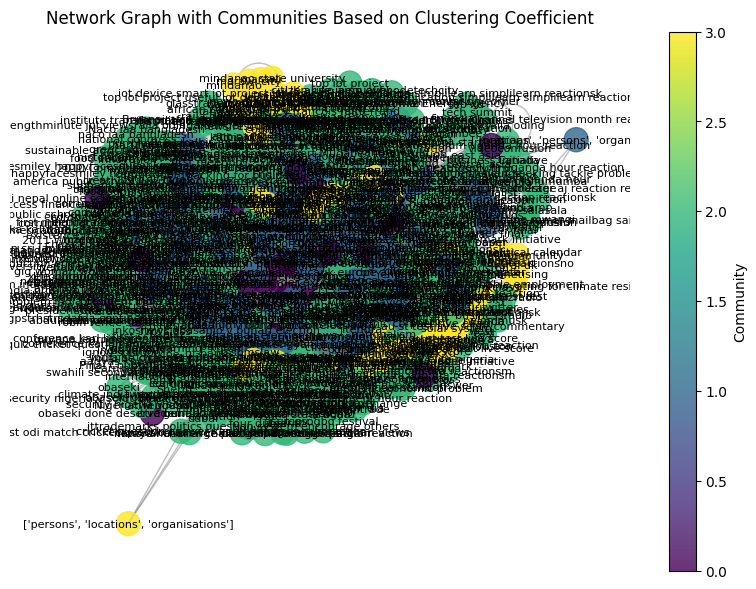

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


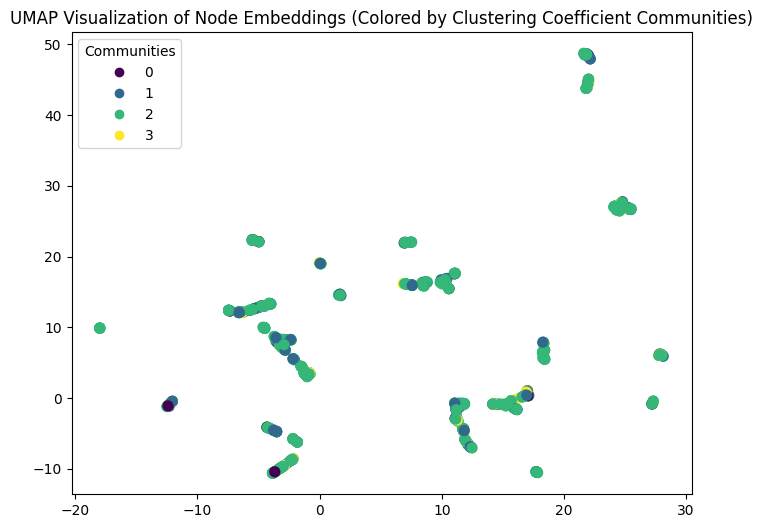

In [92]:
import ast
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import umap  # UMAP for dimensionality reduction

# Assuming your data is stored in a DataFrame named 'df_people'
# Extract relevant columns
df_subset = df_country[['topic', 'Date', 'theme', 'Head', 'Tail', 'sentiment', 'Relations', 'category', 'Views']]

# Step 1: Create a directed graph from the data
G = nx.DiGraph()

# Add nodes and edges to the graph
for _, row in df_subset.iterrows():
    topic = row['topic']
    sentiment = row['sentiment']
    relations = ast.literal_eval(row['Relations'])
    category = row['category']
    theme = row['theme']
    entities = [row['Head'], row['Tail']]
    time = row['Date']

    # Add nodes with type and time attributes
    G.add_node(topic, type='Topic', time=time)
    G.add_node(sentiment, type='Sentiment', time=time)
    G.add_node(theme, type='Theme', time=time)
    G.add_node(category, type='Category', time=time)

    for entity in entities:
        G.add_node(entity, type='Entity', time=time)

    # Add edges from Relations
    for relation in relations:
        head = relation['head']
        relation_type = relation['type']
        tail = relation['tail']
        G.add_edge(head, tail, type=relation_type, time=time)

        # Add additional edges for relationships
        G.add_edge(head, sentiment, type='Sentiment', time=time)
        G.add_edge(head, theme, type='Theme', time=time)
        G.add_edge(head, category, type='Category', time=time)
        G.add_edge(head, topic, type='Topic', time=time)

        G.add_edge(tail, sentiment, type='Sentiment', time=time)
        G.add_edge(tail, theme, type='Theme', time=time)
        G.add_edge(tail, category, type='Category', time=time)
        G.add_edge(tail, topic, type='Topic', time=time)

# Convert the directed graph to an undirected graph for community detection
G_undirected = G.to_undirected()

# Step 2: Ensure all nodes have a 'type' attribute
for node in G_undirected.nodes():
    if 'type' not in G_undirected.nodes[node]:
        G_undirected.nodes[node]['type'] = 'Unknown'  # Assign a default type if missing

# Step 3: Convert NetworkX graph to PyTorch Geometric format

# Get all unique nodes and label encode them
all_nodes = list(G_undirected.nodes)
node_encoder = LabelEncoder()
node_encoder.fit(all_nodes)
node_ids = node_encoder.transform(all_nodes)

# Create edge index (source and target nodes for each edge)
edge_index = []
for source, target in G_undirected.edges():
    edge_index.append([node_encoder.transform([source])[0], node_encoder.transform([target])[0]])

edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

# Use dummy node features (all ones)
num_nodes = len(G_undirected.nodes())
x = torch.ones((num_nodes, 1), dtype=torch.float)  # Feature matrix with a single feature

# Create the PyTorch Geometric data object
data = Data(x=x, edge_index=edge_index)

# Step 4: Define a simple Graph Convolutional Network (GCN)

class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Initialize the model
model = GCN(num_features=1, hidden_channels=16, num_classes=16)

# Step 5: Train the GCN model
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.mse_loss(out, torch.ones(out.shape))  # Dummy loss
    loss.backward()
    optimizer.step()
    return loss.item()

# Train for a few epochs
for epoch in range(100):
    loss = train()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss}')

# Step 6: Extract node embeddings from the trained model
model.eval()
with torch.no_grad():
    embeddings = model(data)

# Step 7: Compute the clustering coefficient for each node
clustering_coeff = nx.clustering(G_undirected)

# Assign the clustering coefficient as an attribute to each node
for node, coeff in clustering_coeff.items():
    G_undirected.nodes[node]['clustering_coefficient'] = coeff

# Step 8: Group nodes by their clustering coefficient (thresholding)
# Let's use simple binning to group nodes into communities based on clustering coefficient
thresholds = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]  # You can modify these thresholds
node_community = {}

for node, coeff in clustering_coeff.items():
    # Assign nodes to a community based on their clustering coefficient
    for i in range(len(thresholds) - 1):
        if thresholds[i] <= coeff < thresholds[i + 1]:
            node_community[node] = i
            break

# Step 9: Visualize the graph with a clearer layout
plt.figure(figsize=(10, 7))  # Adjusted figure size

# Use a layout algorithm for positioning nodes
pos = nx.spring_layout(G_undirected, seed=42)  # Spring layout for visualization

# Step 10: Color nodes by their community (based on clustering coefficient)
node_colors = [node_community.get(node, -1) for node in G_undirected.nodes]

# Draw the nodes with community colors
nodes = nx.draw_networkx_nodes(
    G_undirected, pos,
    node_color=node_colors, cmap='viridis',
    node_size=300, alpha=0.8
)

# Draw the edges
nx.draw_networkx_edges(
    G_undirected, pos,
    edge_color='gray', alpha=0.5
)

# Optionally draw labels (can be omitted for large graphs)
nx.draw_networkx_labels(
    G_undirected, pos,
    font_size=8, font_color='black'
)

# Add a color bar to represent communities
plt.colorbar(nodes, label='Community')  # Directly link the color bar to the drawn nodes

# Title and axis
plt.title("Network Graph with Communities Based on Clustering Coefficient")
plt.axis("off")
plt.show()

# Step 11: Save the graph with community information
nx.write_gexf(G_undirected, "community_graph_clustering_country.gexf")

# Step 12: Reduce the embeddings to 2D using UMAP for better visualization
umap_model = umap.UMAP(n_components=2)
embeddings_2d = umap_model.fit_transform(embeddings.detach().numpy())  # Convert tensor to numpy

# Visualize the 2D embeddings colored by community
plt.figure(figsize=(8, 6))  # Adjusted figure size
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=list(node_community.values()), cmap='viridis', s=50)
plt.legend(*scatter.legend_elements(), title="Communities")
plt.title("UMAP Visualization of Node Embeddings (Colored by Clustering Coefficient Communities)")
plt.show()


Epoch 0, Loss: 0.8394243717193604
Epoch 10, Loss: 0.12332300841808319
Epoch 20, Loss: 0.04250451177358627
Epoch 30, Loss: 0.0312512181699276
Epoch 40, Loss: 0.022699709981679916
Epoch 50, Loss: 0.019133063033223152
Epoch 60, Loss: 0.018275083974003792
Epoch 70, Loss: 0.017325522378087044
Epoch 80, Loss: 0.016705377027392387
Epoch 90, Loss: 0.016151711344718933


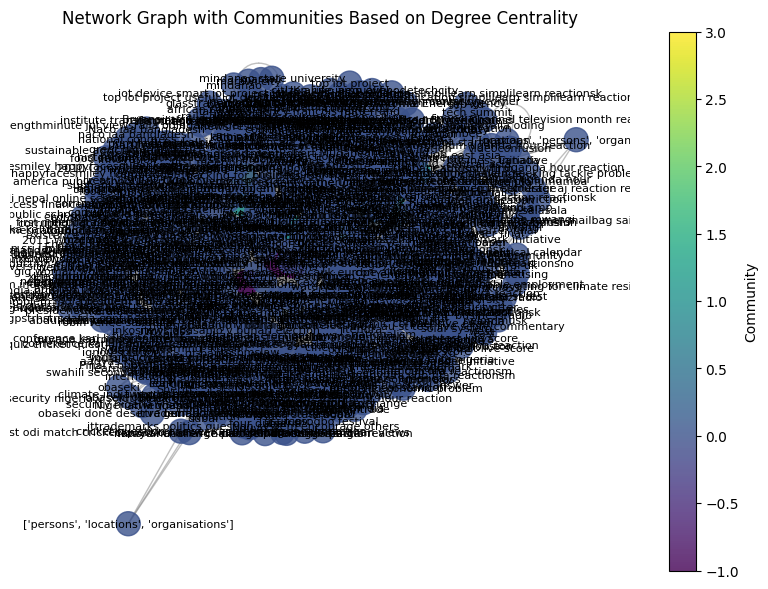

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


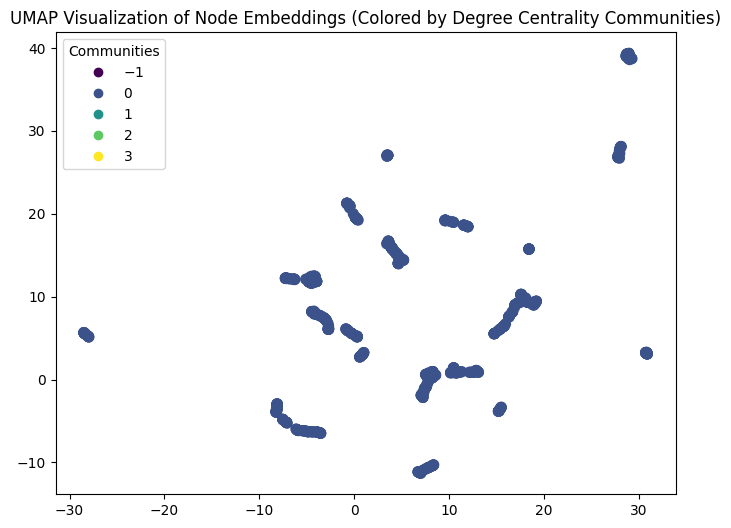

In [93]:
import ast
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import umap  # UMAP for dimensionality reduction

# Assuming your data is stored in a DataFrame named 'df_people'
# Extract relevant columns
df_subset = df_country[['topic', 'Date', 'theme', 'Head', 'Tail', 'sentiment', 'Relations', 'category', 'Views']]

# Step 1: Create a directed graph from the data
G = nx.DiGraph()

# Add nodes and edges to the graph
for _, row in df_subset.iterrows():
    topic = row['topic']
    sentiment = row['sentiment']
    relations = ast.literal_eval(row['Relations'])
    category = row['category']
    theme = row['theme']
    entities = [row['Head'], row['Tail']]
    time = row['Date']

    # Add nodes with type and time attributes
    G.add_node(topic, type='Topic', time=time)
    G.add_node(sentiment, type='Sentiment', time=time)
    G.add_node(theme, type='Theme', time=time)
    G.add_node(category, type='Category', time=time)

    for entity in entities:
        G.add_node(entity, type='Entity', time=time)

    # Add edges from Relations
    for relation in relations:
        head = relation['head']
        relation_type = relation['type']
        tail = relation['tail']
        G.add_edge(head, tail, type=relation_type, time=time)

        # Add additional edges for relationships
        G.add_edge(head, sentiment, type='Sentiment', time=time)
        G.add_edge(head, theme, type='Theme', time=time)
        G.add_edge(head, category, type='Category', time=time)
        G.add_edge(head, topic, type='Topic', time=time)

        G.add_edge(tail, sentiment, type='Sentiment', time=time)
        G.add_edge(tail, theme, type='Theme', time=time)
        G.add_edge(tail, category, type='Category', time=time)
        G.add_edge(tail, topic, type='Topic', time=time)

# Convert the directed graph to an undirected graph for community detection
G_undirected = G.to_undirected()

# Step 2: Ensure all nodes have a 'type' attribute
for node in G_undirected.nodes():
    if 'type' not in G_undirected.nodes[node]:
        G_undirected.nodes[node]['type'] = 'Unknown'  # Assign a default type if missing

# Step 3: Convert NetworkX graph to PyTorch Geometric format

# Get all unique nodes and label encode them
all_nodes = list(G_undirected.nodes)
node_encoder = LabelEncoder()
node_encoder.fit(all_nodes)
node_ids = node_encoder.transform(all_nodes)

# Create edge index (source and target nodes for each edge)
edge_index = []
for source, target in G_undirected.edges():
    edge_index.append([node_encoder.transform([source])[0], node_encoder.transform([target])[0]])

edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

# Use dummy node features (all ones)
num_nodes = len(G_undirected.nodes())
x = torch.ones((num_nodes, 1), dtype=torch.float)  # Feature matrix with a single feature

# Create the PyTorch Geometric data object
data = Data(x=x, edge_index=edge_index)

# Step 4: Define a simple Graph Convolutional Network (GCN)

class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Initialize the model
model = GCN(num_features=1, hidden_channels=16, num_classes=16)

# Step 5: Train the GCN model
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.mse_loss(out, torch.ones(out.shape))  # Dummy loss
    loss.backward()
    optimizer.step()
    return loss.item()

# Train for a few epochs
for epoch in range(100):
    loss = train()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss}')

# Step 6: Extract node embeddings from the trained model
model.eval()
with torch.no_grad():
    embeddings = model(data)

# Step 7: Compute the degree centrality for each node
degree_centrality = nx.degree_centrality(G_undirected)

# Assign the degree centrality as an attribute to each node
for node, degree in degree_centrality.items():
    G_undirected.nodes[node]['degree_centrality'] = degree

# Step 8: Group nodes by their degree centrality (thresholding)
# Let's use simple binning to group nodes into communities based on degree centrality
thresholds = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]  # You can modify these thresholds
node_community = {}

for node, degree in degree_centrality.items():
    # Assign nodes to a community based on their degree centrality
    for i in range(len(thresholds) - 1):
        if thresholds[i] <= degree < thresholds[i + 1]:
            node_community[node] = i
            break

# Ensure node_community matches the number of nodes in embeddings
community_values = [node_community.get(node, -1) for node in all_nodes]

# Step 9: Visualize the graph with a clearer layout
plt.figure(figsize=(10, 7))  # Adjusted figure size

# Use a layout algorithm for positioning nodes
pos = nx.spring_layout(G_undirected, seed=42)  # Spring layout for visualization

# Step 10: Color nodes by their community (based on degree centrality)
node_colors = [node_community.get(node, -1) for node in G_undirected.nodes]

# Draw the nodes with community colors
nodes = nx.draw_networkx_nodes(
    G_undirected, pos,
    node_color=node_colors, cmap='viridis',
    node_size=300, alpha=0.8
)

# Draw the edges
nx.draw_networkx_edges(
    G_undirected, pos,
    edge_color='gray', alpha=0.5
)

# Optionally draw labels (can be omitted for large graphs)
nx.draw_networkx_labels(
    G_undirected, pos,
    font_size=8, font_color='black'
)

# Add a color bar to represent communities
plt.colorbar(nodes, label='Community')  # Directly link the color bar to the drawn nodes

# Title and axis
plt.title("Network Graph with Communities Based on Degree Centrality")
plt.axis("off")
plt.show()

# Step 11: Save the graph with community information
nx.write_gexf(G_undirected, "community_graph_degree_country.gexf")

# Step 12: Reduce the embeddings to 2D using UMAP for better visualization
umap_model = umap.UMAP(n_components=2)
embeddings_2d = umap_model.fit_transform(embeddings.detach().numpy())  # Convert tensor to numpy

# Visualize the 2D embeddings colored by community
plt.figure(figsize=(8, 6))  # Adjusted figure size
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=community_values, cmap='viridis', s=50)
plt.legend(*scatter.legend_elements(), title="Communities")
plt.title("UMAP Visualization of Node Embeddings (Colored by Degree Centrality Communities)")
plt.show()


Epoch 0, Loss: 1.0915277004241943
Epoch 10, Loss: 0.19479858875274658
Epoch 20, Loss: 0.050446927547454834
Epoch 30, Loss: 0.0346980094909668
Epoch 40, Loss: 0.021411722525954247
Epoch 50, Loss: 0.019278060644865036
Epoch 60, Loss: 0.017317209392786026
Epoch 70, Loss: 0.016985323280096054
Epoch 80, Loss: 0.016373833641409874
Epoch 90, Loss: 0.015996724367141724


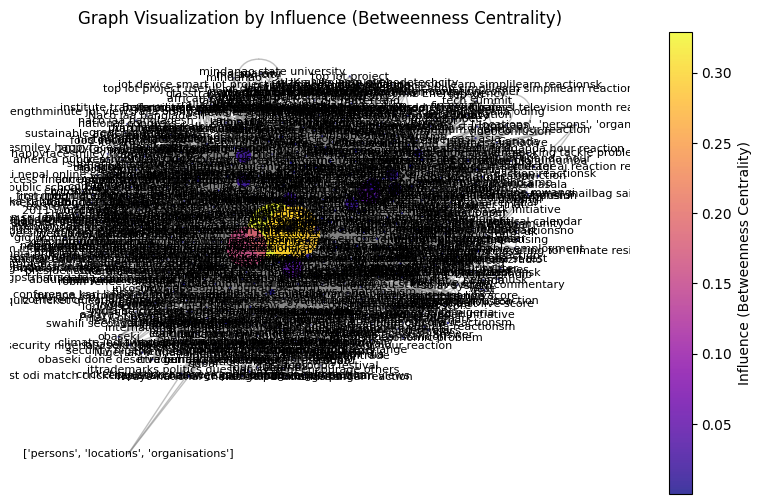

In [94]:
import ast
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Assuming your data is stored in a DataFrame named 'df_people'
# Extract relevant columns
df_subset = df_country[['topic', 'Date', 'theme', 'Head', 'Tail', 'sentiment', 'Relations', 'category', 'Views']]

# Step 1: Create a directed graph from the data
G = nx.DiGraph()

# Add nodes and edges to the graph
for _, row in df_subset.iterrows():
    topic = row['topic']
    sentiment = row['sentiment']
    relations = ast.literal_eval(row['Relations'])
    category = row['category']
    theme = row['theme']
    entities = [row['Head'], row['Tail']]
    time = row['Date']

    # Add nodes with type and time attributes
    G.add_node(topic, type='Topic', time=time)
    G.add_node(sentiment, type='Sentiment', time=time)
    G.add_node(theme, type='Theme', time=time)
    G.add_node(category, type='Category', time=time)

    for entity in entities:
        G.add_node(entity, type='Entity', time=time)

    # Add edges from Relations
    for relation in relations:
        head = relation['head']
        relation_type = relation['type']
        tail = relation['tail']
        G.add_edge(head, tail, type=relation_type, time=time)

        # Add additional edges for relationships
        G.add_edge(head, sentiment, type='Sentiment', time=time)
        G.add_edge(head, theme, type='Theme', time=time)
        G.add_edge(head, category, type='Category', time=time)
        G.add_edge(head, topic, type='Topic', time=time)

        G.add_edge(tail, sentiment, type='Sentiment', time=time)
        G.add_edge(tail, theme, type='Theme', time=time)
        G.add_edge(tail, category, type='Category', time=time)
        G.add_edge(tail, topic, type='Topic', time=time)

# Convert the directed graph to an undirected graph for influence analysis
G_undirected = G.to_undirected()

# Step 2: Ensure all nodes have a 'type' attribute
for node in G_undirected.nodes():
    if 'type' not in G_undirected.nodes[node]:
        G_undirected.nodes[node]['type'] = 'Unknown'  # Assign a default type if missing

# Step 3: Convert NetworkX graph to PyTorch Geometric format
# Get all unique nodes and label encode them
all_nodes = list(G_undirected.nodes)
node_encoder = LabelEncoder()
node_encoder.fit(all_nodes)
node_ids = node_encoder.transform(all_nodes)

# Create edge index (source and target nodes for each edge)
edge_index = []
for source, target in G_undirected.edges():
    edge_index.append([node_encoder.transform([source])[0], node_encoder.transform([target])[0]])

edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

# Use dummy node features (all ones)
num_nodes = len(G_undirected.nodes())
x = torch.ones((num_nodes, 1), dtype=torch.float)  # Feature matrix with a single feature

# Create the PyTorch Geometric data object
data = Data(x=x, edge_index=edge_index)

# Step 4: Define a simple Graph Convolutional Network (GCN)
class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Initialize the model
model = GCN(num_features=1, hidden_channels=16, num_classes=16)

# Step 5: Train the GCN model
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.mse_loss(out, torch.ones(out.shape))  # Dummy loss
    loss.backward()
    optimizer.step()
    return loss.item()

# Train for a few epochs
for epoch in range(100):
    loss = train()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss}')

# Step 6: Extract node embeddings from the trained model
model.eval()
with torch.no_grad():
    embeddings = model(data).numpy()

# Step 7: Analyze influence using betweenness centrality
betweenness_centrality = nx.betweenness_centrality(G_undirected)

# Assign the betweenness centrality as an attribute to each node
nx.set_node_attributes(G_undirected, betweenness_centrality, "influence")

# Assign embeddings to the nodes
embedding_as_string = {node: ','.join(map(str, embedding)) for node, embedding in zip(G_undirected.nodes, embeddings)}
nx.set_node_attributes(G_undirected, embedding_as_string, "embedding")

# Step 8: Save the Graph with Embeddings and Influence
nx.write_gexf(G_undirected, "influence_graph_with_embeddings_country.gexf")

# Step 9: Visualize the Graph by Influence
plt.figure(figsize=(10, 6))

# Use a layout algorithm for positioning nodes
pos = nx.spring_layout(G_undirected, seed=42)

# Scale node sizes by betweenness centrality
node_sizes = [5000 * betweenness_centrality[node] for node in G_undirected.nodes()]

# Draw the graph
nodes = nx.draw_networkx_nodes(
    G_undirected, pos,
    node_size=node_sizes,
    node_color=list(betweenness_centrality.values()),
    cmap='plasma', alpha=0.8
)
nx.draw_networkx_edges(G_undirected, pos, alpha=0.5, edge_color='gray')
nx.draw_networkx_labels(G_undirected, pos, font_size=8, font_color='black')

# Add a color bar for influence
plt.colorbar(nodes, label="Influence (Betweenness Centrality)")
plt.title("Graph Visualization by Influence (Betweenness Centrality)")
plt.axis("off")
plt.show()


Epoch 0, Loss: 0.9254398941993713
Epoch 10, Loss: 0.27668309211730957
Epoch 20, Loss: 0.06835156679153442
Epoch 30, Loss: 0.02944590523838997
Epoch 40, Loss: 0.02340836636722088
Epoch 50, Loss: 0.019096126779913902
Epoch 60, Loss: 0.017313962802290916
Epoch 70, Loss: 0.016315126791596413
Epoch 80, Loss: 0.015928898006677628
Epoch 90, Loss: 0.015558488667011261


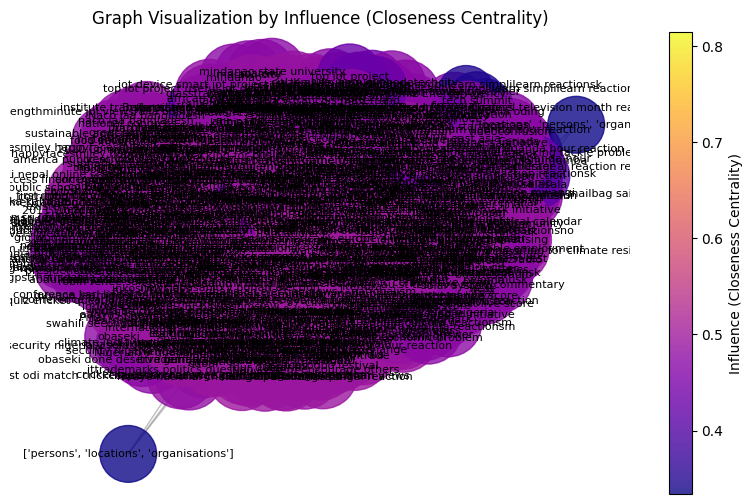

In [95]:
import ast
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Assuming your data is stored in a DataFrame named 'df_people'
# Extract relevant columns
df_subset = df_country[['topic', 'Date', 'theme', 'Head', 'Tail', 'sentiment', 'Relations', 'category', 'Views']]

# Step 1: Create a directed graph from the data
G = nx.DiGraph()

# Add nodes and edges to the graph
for _, row in df_subset.iterrows():
    topic = row['topic']
    sentiment = row['sentiment']
    relations = ast.literal_eval(row['Relations'])
    category = row['category']
    theme = row['theme']
    entities = [row['Head'], row['Tail']]
    time = row['Date']

    # Add nodes with type and time attributes
    G.add_node(topic, type='Topic', time=time)
    G.add_node(sentiment, type='Sentiment', time=time)
    G.add_node(theme, type='Theme', time=time)
    G.add_node(category, type='Category', time=time)

    for entity in entities:
        G.add_node(entity, type='Entity', time=time)

    # Add edges from Relations
    for relation in relations:
        head = relation['head']
        relation_type = relation['type']
        tail = relation['tail']
        G.add_edge(head, tail, type=relation_type, time=time)

        # Add additional edges for relationships
        G.add_edge(head, sentiment, type='Sentiment', time=time)
        G.add_edge(head, theme, type='Theme', time=time)
        G.add_edge(head, category, type='Category', time=time)
        G.add_edge(head, topic, type='Topic', time=time)

        G.add_edge(tail, sentiment, type='Sentiment', time=time)
        G.add_edge(tail, theme, type='Theme', time=time)
        G.add_edge(tail, category, type='Category', time=time)
        G.add_edge(tail, topic, type='Topic', time=time)

# Convert the directed graph to an undirected graph for influence analysis
G_undirected = G.to_undirected()

# Step 2: Ensure all nodes have a 'type' attribute
for node in G_undirected.nodes():
    if 'type' not in G_undirected.nodes[node]:
        G_undirected.nodes[node]['type'] = 'Unknown'  # Assign a default type if missing

# Step 3: Convert NetworkX graph to PyTorch Geometric format
# Get all unique nodes and label encode them
all_nodes = list(G_undirected.nodes)
node_encoder = LabelEncoder()
node_encoder.fit(all_nodes)
node_ids = node_encoder.transform(all_nodes)

# Create edge index (source and target nodes for each edge)
edge_index = []
for source, target in G_undirected.edges():
    edge_index.append([node_encoder.transform([source])[0], node_encoder.transform([target])[0]])

edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

# Use dummy node features (all ones)
num_nodes = len(G_undirected.nodes())
x = torch.ones((num_nodes, 1), dtype=torch.float)  # Feature matrix with a single feature

# Create the PyTorch Geometric data object
data = Data(x=x, edge_index=edge_index)

# Step 4: Define a simple Graph Convolutional Network (GCN)
class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Initialize the model
model = GCN(num_features=1, hidden_channels=16, num_classes=16)

# Step 5: Train the GCN model
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.mse_loss(out, torch.ones(out.shape))  # Dummy loss
    loss.backward()
    optimizer.step()
    return loss.item()

# Train for a few epochs
for epoch in range(100):
    loss = train()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss}')

# Step 6: Extract node embeddings from the trained model
model.eval()
with torch.no_grad():
    embeddings = model(data).numpy()

# Step 7: Analyze influence using closeness centrality
closeness_centrality = nx.closeness_centrality(G_undirected)

# Assign the closeness centrality as an attribute to each node
nx.set_node_attributes(G_undirected, closeness_centrality, "influence")

# Assign embeddings to the nodes
embedding_as_string = {node: ','.join(map(str, embedding)) for node, embedding in zip(G_undirected.nodes, embeddings)}
nx.set_node_attributes(G_undirected, embedding_as_string, "embedding")

# Step 8: Save the Graph with Embeddings and Influence
nx.write_gexf(G_undirected, "influence_graph_with_embeddings_closeness_country.gexf")

# Step 9: Visualize the Graph by Influence
plt.figure(figsize=(10, 6))

# Use a layout algorithm for positioning nodes
pos = nx.spring_layout(G_undirected, seed=42)

# Scale node sizes by closeness centrality
node_sizes = [5000 * closeness_centrality[node] for node in G_undirected.nodes()]

# Draw the graph
nodes = nx.draw_networkx_nodes(
    G_undirected, pos,
    node_size=node_sizes,
    node_color=list(closeness_centrality.values()),
    cmap='plasma', alpha=0.8
)
nx.draw_networkx_edges(G_undirected, pos, alpha=0.5, edge_color='gray')
nx.draw_networkx_labels(G_undirected, pos, font_size=8, font_color='black')

# Add a color bar for influence
plt.colorbar(nodes, label="Influence (Closeness Centrality)")
plt.title("Graph Visualization by Influence (Closeness Centrality)")
plt.axis("off")
plt.show()


Epoch 0, Loss: 1.7556180953979492
Epoch 10, Loss: 0.7686490416526794
Epoch 20, Loss: 0.36544713377952576
Epoch 30, Loss: 0.1098126769065857
Epoch 40, Loss: 0.036872055381536484
Epoch 50, Loss: 0.01762606017291546
Epoch 60, Loss: 0.01606018655002117
Epoch 70, Loss: 0.012950769625604153
Epoch 80, Loss: 0.012420565821230412
Epoch 90, Loss: 0.011968322098255157


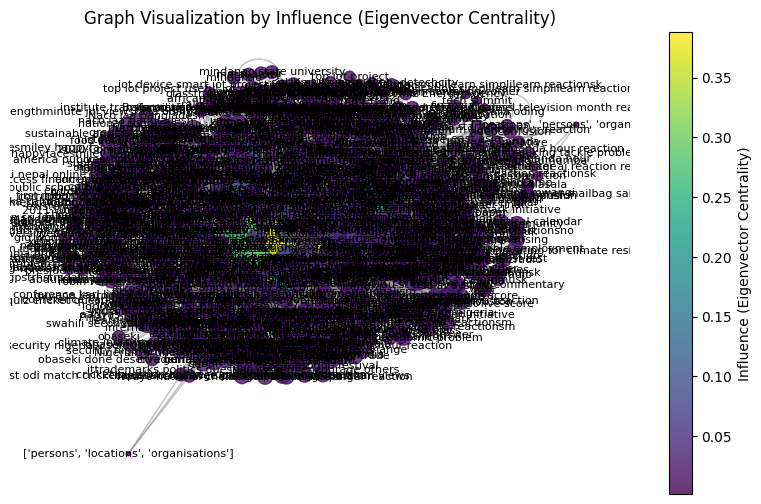

In [96]:
import ast
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Assuming your data is stored in a DataFrame named 'df_people'
# Extract relevant columns
df_subset = df_country[['topic', 'Date', 'theme', 'Head', 'Tail', 'sentiment', 'Relations', 'category', 'Views']]

# Step 1: Create a directed graph from the data
G = nx.DiGraph()

# Add nodes and edges to the graph
for _, row in df_subset.iterrows():
    topic = row['topic']
    sentiment = row['sentiment']
    relations = ast.literal_eval(row['Relations'])
    category = row['category']
    theme = row['theme']
    entities = [row['Head'], row['Tail']]
    time = row['Date']

    # Add nodes with type and time attributes
    G.add_node(topic, type='Topic', time=time)
    G.add_node(sentiment, type='Sentiment', time=time)
    G.add_node(theme, type='Theme', time=time)
    G.add_node(category, type='Category', time=time)

    for entity in entities:
        G.add_node(entity, type='Entity', time=time)

    # Add edges from Relations
    for relation in relations:
        head = relation['head']
        relation_type = relation['type']
        tail = relation['tail']
        G.add_edge(head, tail, type=relation_type, time=time)

        # Add additional edges for relationships
        G.add_edge(head, sentiment, type='Sentiment', time=time)
        G.add_edge(head, theme, type='Theme', time=time)
        G.add_edge(head, category, type='Category', time=time)
        G.add_edge(head, topic, type='Topic', time=time)

        G.add_edge(tail, sentiment, type='Sentiment', time=time)
        G.add_edge(tail, theme, type='Theme', time=time)
        G.add_edge(tail, category, type='Category', time=time)
        G.add_edge(tail, topic, type='Topic', time=time)

# Convert the directed graph to an undirected graph for influence analysis
G_undirected = G.to_undirected()

# Step 2: Ensure all nodes have a 'type' attribute
for node in G_undirected.nodes():
    if 'type' not in G_undirected.nodes[node]:
        G_undirected.nodes[node]['type'] = 'Unknown'  # Assign a default type if missing

# Step 3: Convert NetworkX graph to PyTorch Geometric format
# Get all unique nodes and label encode them
all_nodes = list(G_undirected.nodes)
node_encoder = LabelEncoder()
node_encoder.fit(all_nodes)
node_ids = node_encoder.transform(all_nodes)

# Create edge index (source and target nodes for each edge)
edge_index = []
for source, target in G_undirected.edges():
    edge_index.append([node_encoder.transform([source])[0], node_encoder.transform([target])[0]])

edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

# Use dummy node features (all ones)
num_nodes = len(G_undirected.nodes())
x = torch.ones((num_nodes, 1), dtype=torch.float)  # Feature matrix with a single feature

# Create the PyTorch Geometric data object
data = Data(x=x, edge_index=edge_index)

# Step 4: Define a simple Graph Convolutional Network (GCN)
class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Initialize the model
model = GCN(num_features=1, hidden_channels=16, num_classes=16)

# Step 5: Train the GCN model
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.mse_loss(out, torch.ones(out.shape))  # Dummy loss
    loss.backward()
    optimizer.step()
    return loss.item()

# Train for a few epochs
for epoch in range(100):
    loss = train()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss}')

# Step 6: Extract node embeddings from the trained model
model.eval()
with torch.no_grad():
    embeddings = model(data).numpy()

# Step 7: Analyze influence using eigenvector centrality
eigenvector_centrality = nx.eigenvector_centrality(G_undirected, max_iter=1000)

# Assign the eigenvector centrality as an attribute to each node
nx.set_node_attributes(G_undirected, eigenvector_centrality, "influence")

# Assign embeddings to the nodes
embedding_as_string = {node: ','.join(map(str, embedding)) for node, embedding in zip(G_undirected.nodes, embeddings)}
nx.set_node_attributes(G_undirected, embedding_as_string, "embedding")

# Step 8: Save the Graph with Embeddings and Influence
nx.write_gexf(G_undirected, "influence_graph_with_embeddings_eigenvector_country.gexf")

# Step 9: Visualize the Graph by Influence
plt.figure(figsize=(10, 6))

# Use a layout algorithm for positioning nodes
pos = nx.spring_layout(G_undirected, seed=42)

# Scale node sizes by eigenvector centrality
node_sizes = [5000 * eigenvector_centrality[node] for node in G_undirected.nodes()]

# Draw the graph
nodes = nx.draw_networkx_nodes(
    G_undirected, pos,
    node_size=node_sizes,
    node_color=list(eigenvector_centrality.values()),
    cmap='viridis', alpha=0.8
)
nx.draw_networkx_edges(G_undirected, pos, alpha=0.5, edge_color='gray')
nx.draw_networkx_labels(G_undirected, pos, font_size=8, font_color='black')

# Add a color bar for influence
plt.colorbar(nodes, label="Influence (Eigenvector Centrality)")
plt.title("Graph Visualization by Influence (Eigenvector Centrality)")
plt.axis("off")
plt.show()


Epoch 0, Loss: 1.4430370330810547
Epoch 10, Loss: 0.5692384243011475
Epoch 20, Loss: 0.24332334101200104
Epoch 30, Loss: 0.11204585433006287
Epoch 40, Loss: 0.05449582263827324
Epoch 50, Loss: 0.026128459721803665
Epoch 60, Loss: 0.016854198649525642
Epoch 70, Loss: 0.014042629860341549
Epoch 80, Loss: 0.013227328658103943
Epoch 90, Loss: 0.012943565845489502


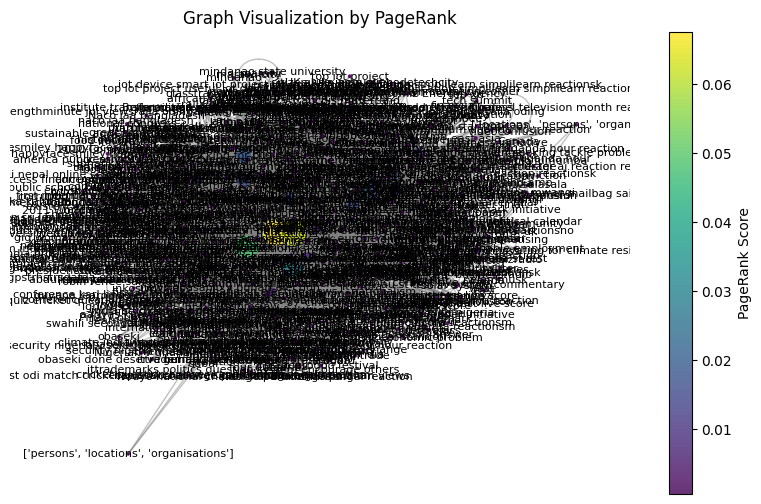

In [97]:
import ast
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Assuming your data is stored in a DataFrame named 'df_people'
# Extract relevant columns
df_subset = df_country[['topic', 'Date', 'theme', 'Head', 'Tail', 'sentiment', 'Relations', 'category', 'Views']]

# Step 1: Create a directed graph from the data
G = nx.DiGraph()

# Add nodes and edges to the graph
for _, row in df_subset.iterrows():
    topic = row['topic']
    sentiment = row['sentiment']
    relations = ast.literal_eval(row['Relations'])
    category = row['category']
    theme = row['theme']
    entities = [row['Head'], row['Tail']]
    time = row['Date']

    # Add nodes with type and time attributes
    G.add_node(topic, type='Topic', time=time)
    G.add_node(sentiment, type='Sentiment', time=time)
    G.add_node(theme, type='Theme', time=time)
    G.add_node(category, type='Category', time=time)

    for entity in entities:
        G.add_node(entity, type='Entity', time=time)

    # Add edges from Relations
    for relation in relations:
        head = relation['head']
        relation_type = relation['type']
        tail = relation['tail']
        G.add_edge(head, tail, type=relation_type, time=time)

        # Add additional edges for relationships
        G.add_edge(head, sentiment, type='Sentiment', time=time)
        G.add_edge(head, theme, type='Theme', time=time)
        G.add_edge(head, category, type='Category', time=time)
        G.add_edge(head, topic, type='Topic', time=time)

        G.add_edge(tail, sentiment, type='Sentiment', time=time)
        G.add_edge(tail, theme, type='Theme', time=time)
        G.add_edge(tail, category, type='Category', time=time)
        G.add_edge(tail, topic, type='Topic', time=time)

# Convert the directed graph to an undirected graph
G_undirected = G.to_undirected()

# Step 2: Ensure all nodes have a 'type' attribute
for node in G_undirected.nodes():
    if 'type' not in G_undirected.nodes[node]:
        G_undirected.nodes[node]['type'] = 'Unknown'  # Assign a default type if missing

# Step 3: Convert NetworkX graph to PyTorch Geometric format
# Get all unique nodes and label encode them
all_nodes = list(G_undirected.nodes)
node_encoder = LabelEncoder()
node_encoder.fit(all_nodes)
node_ids = node_encoder.transform(all_nodes)

# Create edge index (source and target nodes for each edge)
edge_index = []
for source, target in G_undirected.edges():
    edge_index.append([node_encoder.transform([source])[0], node_encoder.transform([target])[0]])

edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

# Use dummy node features (all ones)
num_nodes = len(G_undirected.nodes())
x = torch.ones((num_nodes, 1), dtype=torch.float)  # Feature matrix with a single feature

# Create the PyTorch Geometric data object
data = Data(x=x, edge_index=edge_index)

# Step 4: Define a simple Graph Convolutional Network (GCN)
class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Initialize the model
model = GCN(num_features=1, hidden_channels=16, num_classes=16)

# Step 5: Train the GCN model
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.mse_loss(out, torch.ones(out.shape))  # Dummy loss
    loss.backward()
    optimizer.step()
    return loss.item()

# Train for a few epochs
for epoch in range(100):
    loss = train()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss}')

# Step 6: Extract node embeddings from the trained model
model.eval()
with torch.no_grad():
    embeddings = model(data).numpy()

# Step 7: Perform link analysis using PageRank
pagerank_scores = nx.pagerank(G_undirected)

# Assign the PageRank scores as an attribute to each node
nx.set_node_attributes(G_undirected, pagerank_scores, "pagerank")

# Assign embeddings to the nodes
embedding_as_string = {node: ','.join(map(str, embedding)) for node, embedding in zip(G_undirected.nodes, embeddings)}
nx.set_node_attributes(G_undirected, embedding_as_string, "embedding")

# Step 8: Save the Graph with PageRank and Embeddings
nx.write_gexf(G_undirected, "pagerank_graph_with_embeddings_country.gexf")

# Step 9: Visualize the Graph by PageRank
plt.figure(figsize=(10, 6))

# Use a layout algorithm for positioning nodes
pos = nx.spring_layout(G_undirected, seed=42)

# Scale node sizes by PageRank scores
node_sizes = [5000 * pagerank_scores[node] for node in G_undirected.nodes()]

# Draw the graph
nodes = nx.draw_networkx_nodes(
    G_undirected, pos,
    node_size=node_sizes,
    node_color=list(pagerank_scores.values()),
    cmap='viridis', alpha=0.8
)
nx.draw_networkx_edges(G_undirected, pos, alpha=0.5, edge_color='gray')
nx.draw_networkx_labels(G_undirected, pos, font_size=8, font_color='black')

# Add a color bar for PageRank scores
plt.colorbar(nodes, label="PageRank Score")
plt.title("Graph Visualization by PageRank")
plt.axis("off")
plt.show()


Epoch 0, Loss: 1.395370364189148
Epoch 10, Loss: 0.4833207428455353
Epoch 20, Loss: 0.08543378114700317
Epoch 30, Loss: 0.03714941442012787
Epoch 40, Loss: 0.025906909257173538
Epoch 50, Loss: 0.018566645681858063
Epoch 60, Loss: 0.016174154356122017
Epoch 70, Loss: 0.015558036044239998
Epoch 80, Loss: 0.014913850463926792
Epoch 90, Loss: 0.01462620496749878


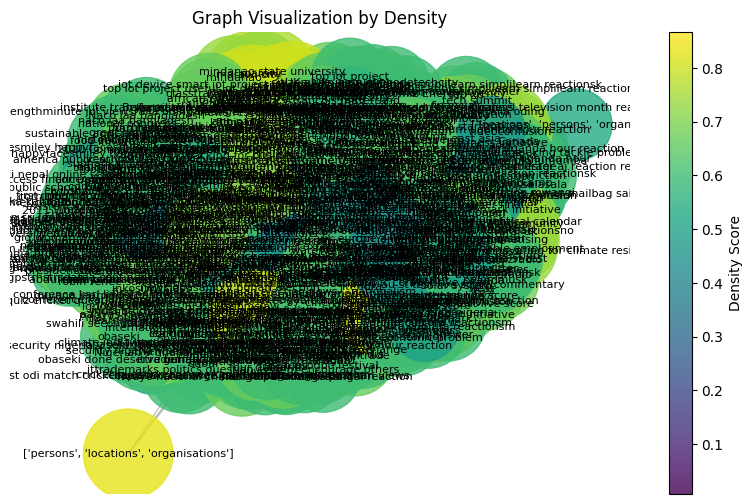

In [98]:
import ast
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Assuming your data is stored in a DataFrame named 'df_people'
# Extract relevant columns
df_subset = df_country[['topic', 'Date', 'theme', 'Head', 'Tail', 'sentiment', 'Relations', 'category', 'Views']]

# Step 1: Create a directed graph from the data
G = nx.DiGraph()

# Add nodes and edges to the graph
for _, row in df_subset.iterrows():
    topic = row['topic']
    sentiment = row['sentiment']
    relations = ast.literal_eval(row['Relations'])
    category = row['category']
    theme = row['theme']
    entities = [row['Head'], row['Tail']]
    time = row['Date']

    # Add nodes with type and time attributes
    G.add_node(topic, type='Topic', time=time)
    G.add_node(sentiment, type='Sentiment', time=time)
    G.add_node(theme, type='Theme', time=time)
    G.add_node(category, type='Category', time=time)

    for entity in entities:
        G.add_node(entity, type='Entity', time=time)

    # Add edges from Relations
    for relation in relations:
        head = relation['head']
        relation_type = relation['type']
        tail = relation['tail']
        G.add_edge(head, tail, type=relation_type, time=time)

        # Add additional edges for relationships
        G.add_edge(head, sentiment, type='Sentiment', time=time)
        G.add_edge(head, theme, type='Theme', time=time)
        G.add_edge(head, category, type='Category', time=time)
        G.add_edge(head, topic, type='Topic', time=time)

        G.add_edge(tail, sentiment, type='Sentiment', time=time)
        G.add_edge(tail, theme, type='Theme', time=time)
        G.add_edge(tail, category, type='Category', time=time)
        G.add_edge(tail, topic, type='Topic', time=time)

# Convert the directed graph to an undirected graph
G_undirected = G.to_undirected()

# Step 2: Ensure all nodes have a 'type' attribute
for node in G_undirected.nodes():
    if 'type' not in G_undirected.nodes[node]:
        G_undirected.nodes[node]['type'] = 'Unknown'  # Assign a default type if missing

# Step 3: Convert NetworkX graph to PyTorch Geometric format
# Get all unique nodes and label encode them
all_nodes = list(G_undirected.nodes)
node_encoder = LabelEncoder()
node_encoder.fit(all_nodes)
node_ids = node_encoder.transform(all_nodes)

# Create edge index (source and target nodes for each edge)
edge_index = []
for source, target in G_undirected.edges():
    edge_index.append([node_encoder.transform([source])[0], node_encoder.transform([target])[0]])

edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

# Use dummy node features (all ones)
num_nodes = len(G_undirected.nodes())
x = torch.ones((num_nodes, 1), dtype=torch.float)  # Feature matrix with a single feature

# Create the PyTorch Geometric data object
data = Data(x=x, edge_index=edge_index)

# Step 4: Define a simple Graph Convolutional Network (GCN)
class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Initialize the model
model = GCN(num_features=1, hidden_channels=16, num_classes=16)

# Step 5: Train the GCN model
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.mse_loss(out, torch.ones(out.shape))  # Dummy loss
    loss.backward()
    optimizer.step()
    return loss.item()

# Train for a few epochs
for epoch in range(100):
    loss = train()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss}')

# Step 6: Extract node embeddings from the trained model
model.eval()
with torch.no_grad():
    embeddings = model(data).numpy()

# Step 7: Calculate density for each node's neighborhood
density_scores = {}
for node in G_undirected.nodes:
    neighbors = list(G_undirected.neighbors(node))
    subgraph = G_undirected.subgraph(neighbors + [node])  # Include the node itself
    density_scores[node] = nx.density(subgraph)

# Assign the density scores as an attribute to each node
nx.set_node_attributes(G_undirected, density_scores, "density")

# Assign embeddings to the nodes
embedding_as_string = {node: ','.join(map(str, embedding)) for node, embedding in zip(G_undirected.nodes, embeddings)}
nx.set_node_attributes(G_undirected, embedding_as_string, "embedding")

# Step 8: Save the Graph with Density and Embeddings
nx.write_gexf(G_undirected, "density_graph_with_embeddings_country.gexf")

# Step 9: Visualize the Graph by Density
plt.figure(figsize=(10, 6))

# Use a layout algorithm for positioning nodes
pos = nx.spring_layout(G_undirected, seed=42)

# Scale node sizes by density scores
node_sizes = [5000 * density_scores[node] for node in G_undirected.nodes()]

# Draw the graph
nodes = nx.draw_networkx_nodes(
    G_undirected, pos,
    node_size=node_sizes,
    node_color=list(density_scores.values()),
    cmap='viridis', alpha=0.8
)
nx.draw_networkx_edges(G_undirected, pos, alpha=0.5, edge_color='gray')
nx.draw_networkx_labels(G_undirected, pos, font_size=8, font_color='black')

# Add a color bar for density scores
plt.colorbar(nodes, label="Density Score")
plt.title("Graph Visualization by Density")
plt.axis("off")
plt.show()
